Figures S7 to S28 in the Supplementary Information

In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import seaborn as sns
import matplotlib.ticker as mticker


# Loading files
file_names = [
    "AUGIN.xlsx", "CNQIA.xlsx", "CNDIN.xlsx", "DKSOR.xlsx", 
    "ESLJU.xlsx", "NLLOO.xlsx", "AUDAS.xlsx", "USOHO.xlsx", 
    "MYPSO.xlsx", "USSRM.xlsx", "USSRC.xlsx", "AURIG.xlsx", 
    "USSRG.xlsx"
]

# defining markers
markers = ['o', 's', '^', 'D', '*', 'X', '<', '>', 'd', '8', 'p', 'h', 'D']

# Creating the colorblind-friendly palette and defining color and line style for each PFT
palette = sns.color_palette("colorblind", 8)
spec_colors = {
    'USSRM': palette[0],  
    'AURIG': palette[1],  
    'USSRC': palette[3],  
    'DKSOR': '#000000'  
}
pft_colors = {
    'Woody Savanna': spec_colors['USSRM'], 
    'Evergreen Needle Forest': palette[2], 
    'Deciduous Broadleaf Forest': spec_colors['DKSOR'], 
    'Open Shrubland': spec_colors['USSRC'],
    'Evergreen Broadleaf Forest': palette[7],  
    'Grassland': spec_colors['AURIG'],
    'Savanna': palette[5]
}

site_labels = {
    'AUGIN': ('Woody Savanna', 'AU-Gin'),
    'USSRM': ('Woody Savanna', 'US-SRM'),
    'CNQIA': ('Evergreen Needle Forest', 'CN-Qia'),
    'NLLOO': ('Evergreen Needle Forest', 'NL-Loo'),
    'DKSOR': ('Deciduous Broadleaf Forest', 'DK-Sor'),
    'USOHO': ('Deciduous Broadleaf Forest', 'US-Oho'),
    'ESLJU': ('Open Shrubland', 'ES-LJu'),
    'USSRC': ('Open Shrubland', 'US-SRC'),
    'CNDIN': ('Evergreen Broadleaf Forest', 'CN-Din'),
    'MYPSO': ('Evergreen Broadleaf Forest', 'MY-PSO'),
    'AURIG': ('Grassland', 'AU-Rig'),
    'USSRG': ('Grassland', 'US-SRG'),
    'AUDAS': ('Savanna', 'AU-DaS'),
}


Figure S7 in the Supplementary information - Relationship between average NEE asymmetry and daily average temperature for top 1%
fluctuations for all sites

In [3]:
#Matching temperature data
tpm_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"/Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/MATCHINGTEMP/{file}")
        t_mtchng = df.iloc[0, 1]   
        peakstm = df.iloc[:, 0]
        meanactm = np.mean(peakstm)
        stdactm = np.std(peakstm)
        tpm_data[label] = {"t_mtchng": t_mtchng, "meanactm": meanactm, "stdactm": stdactm, "marker": marker, "color": color}


In [4]:

x_data = np.array([v["t_mtchng"] for v in tpm_data.values()], dtype=float)
y_data = np.array([v["meanactm"] for v in tpm_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_temp(x, K, n):     return 0.5 * (x**n) / (K + x**n)          # scaled Hill for temperature
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)           # general Hill

def fit_models(x, y, models, is_temp=True):
    results = []
    n_samples = len(y)
    if is_temp:
        MODEL_SET = {
            "Linear":      (f_linear,     [1.0, 0.0]),
            "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
            "Power":       (f_power,      [1.0, 1.0]),
            "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
            "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
            "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
            "Hill":        (f_hill_temp,  [float(np.median(x)), 0.5]),
        }
    else:
        MODEL_SET = {
            "Linear":      (f_linear,     [1.0, 0.0]),
            "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
            "Power":       (f_power,      [1.0, 1.0]),
            "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
            "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
            "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
            "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),
        }

    for name in models:
        func, p0 = MODEL_SET[name]
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({"name": name, "func": func, "params": popt,
                            "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                            "aic": aic, "aicc": aicc, "bic": bic})
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

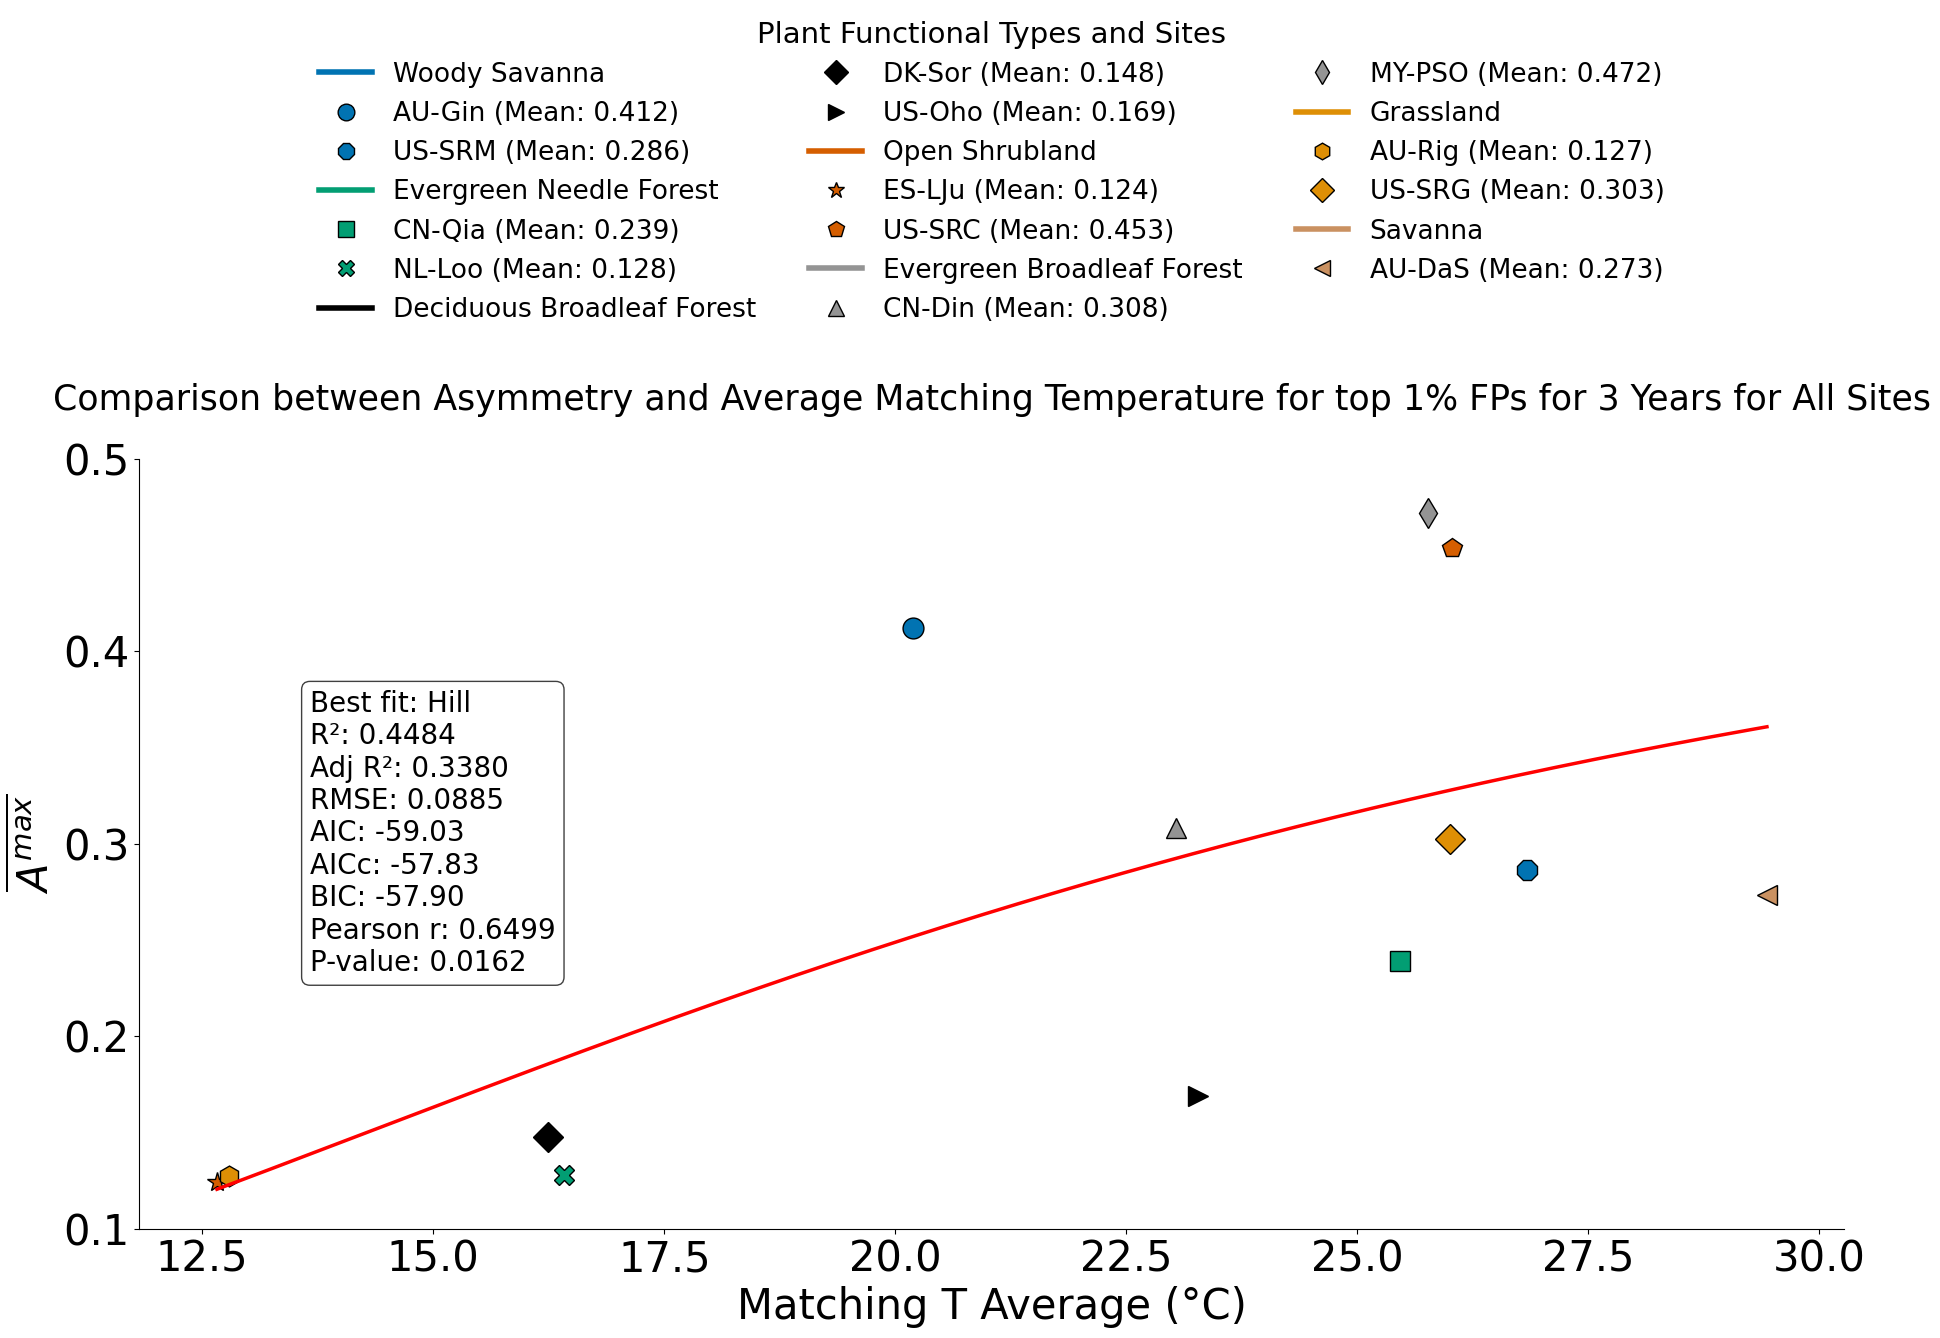

In [5]:
# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models(x_data, y_data, candidates, is_temp=True)
best = fits[0] if len(fits) else None

fig, ax_main = plt.subplots(figsize=(22, 10))

# Plotting 
for site, d in tpm_data.items():
    ax_main.plot(d["t_mtchng"], d["meanactm"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)

ax_main.set_xlabel('Matching T Average (°C)', fontsize=30)
ax_main.set_ylabel('$\\overline{A^{max}}$', fontsize=30)
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title(
    'Comparison between Asymmetry and Average Matching Temperature for top 1% FPs for 3 Years for All Sites',
    fontsize=25, pad=35  # try 20–35
)
ax_main.set_ylim(0.1, 0.5)
ax_main.set_yticks(np.arange(0.1, 0.51, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
x_range = x_max - x_min
padding = x_range * 0.05  # 5% padding on each side
ax_main.set_xlim(x_min - padding, x_max + padding)

if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 800)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'

props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax_main.text(0.10, 0.70, textstr, transform=ax_main.transAxes, fontsize=20,
             verticalalignment='top', bbox=props)

pft_groups = {}
for site_val, (pft, site_label) in site_labels.items():
    if site_label in tpm_data:
        pft_groups.setdefault(pft, []).append(site_label)

legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = tpm_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['meanactm']:.3f})",
                                              markerfacecolor=color, markersize=12,
                                              markeredgecolor='black'))

legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.6), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()

Figure S8 in the Supplementary Information - Relationship between average NEE asymmetry and 3yr shortwave radiation average for top 1%
fluctuations for all sites

/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/474338779.py:27: RuntimeWarning: invalid value encountered in log
  def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c


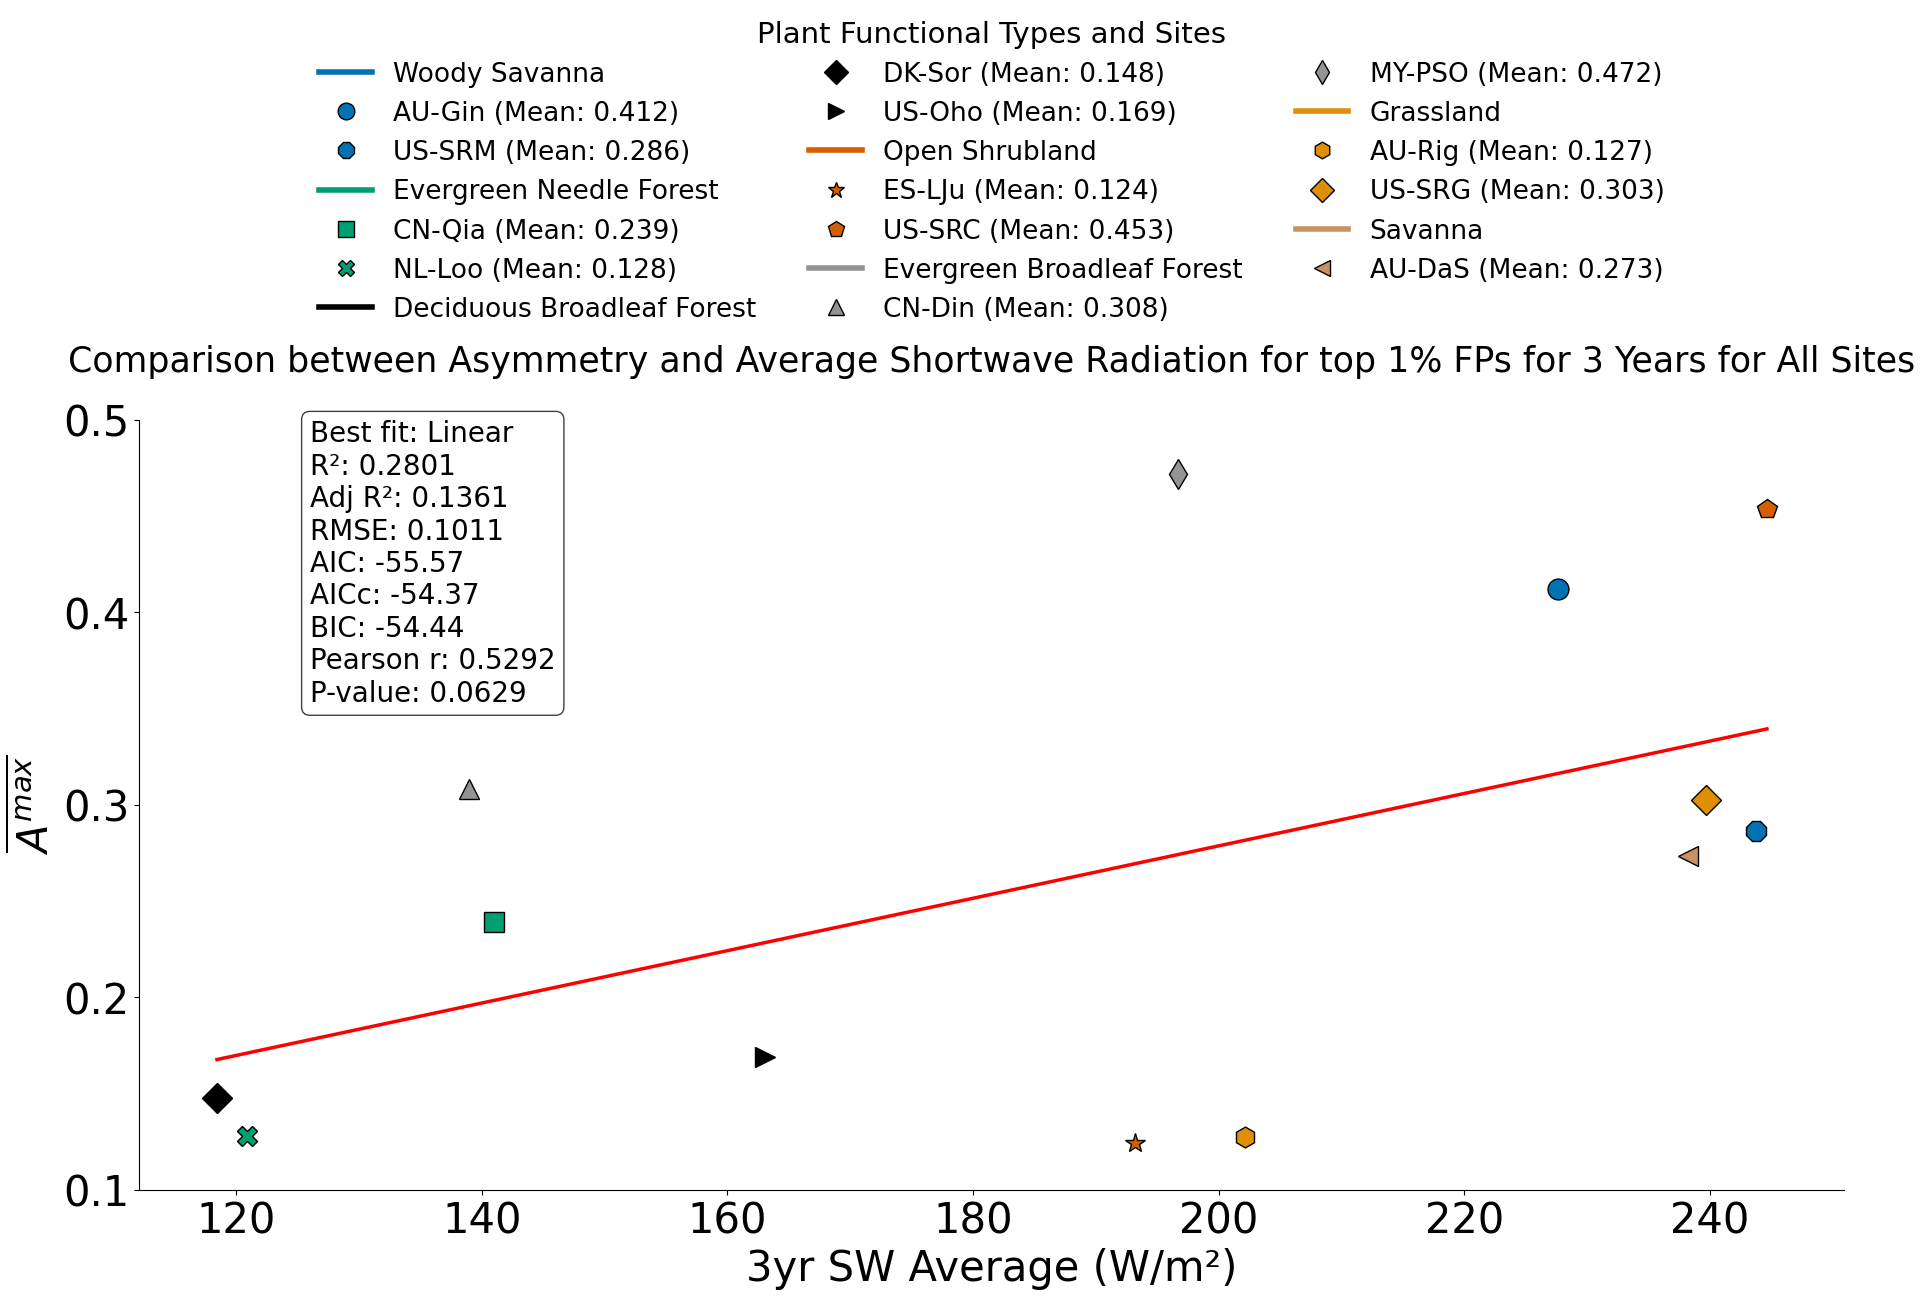

In [6]:
#3yr shortwave data
sw_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"/Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/3YRSW/{file}")
        sw_3yr = df.iloc[0, 1]   
        peakssw = df.iloc[:, 0]
        meanacsw = np.mean(peakssw)
        stdacsw = np.std(peakssw)
        sw_data[label] = {"sw_3yr": sw_3yr, "meanacsw": meanacsw, "stdacsw": stdacsw, "marker": marker, "color": color}


x_data = np.array([v["sw_3yr"] for v in sw_data.values()], dtype=float)
y_data = np.array([v["meanacsw"] for v in sw_data.values()], dtype=float)
correlation, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)  # general Hill only

def fit_models_sw(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),  # general Hill (no temp scaling)
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({
                "name": name, "func": func, "params": popt,
                "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                "aic": aic, "aicc": aicc, "bic": bic
            })
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_sw(x_data, y_data)
best = fits[0] if len(fits) else None

# Plotting 
fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in sw_data.items():
    ax_main.plot(d["sw_3yr"], d["meanacsw"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)
ax_main.set_xlabel('3yr SW Average (W/m²)', fontsize=30)
ax_main.set_ylabel('$\\overline{A^{max}}$', fontsize=30)
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title(
    'Comparison between Asymmetry and Average Shortwave Radiation for top 1% FPs for 3 Years for All Sites',
    fontsize=25, pad=35
)
ax_main.set_ylim(0.1, 0.5)
ax_main.set_yticks(np.arange(0.1, 0.51, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {correlation:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {correlation:.4f}\nP-value: {p_value:.4f}'

props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax_main.text(0.10, 1.0, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=props)

pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in sw_data:
        pft_groups.setdefault(pft, []).append(site_label)
legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = sw_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['meanacsw']:.3f})",
                                              markerfacecolor=color, markersize=12,
                                              markeredgecolor='black'))
legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()

Figure S9 in the Supplementary information - Relationship between average NEE asymmetry and daily average shortwave radiation for top 1%
fluctuations for all sites

In [7]:
# Daily shortwave data
swm_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"/Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/MATCHINGSW/{file}")
        sw_mtchng = df.iloc[0, 1]   
        peaksswm = df.iloc[:, 0]
        meanacswm = np.mean(peaksswm)
        stdacswm = np.std(peaksswm)
        swm_data[label] = {"sw_mtchng": sw_mtchng, "meanacswm": meanacswm, "stdacswm": stdacswm, "marker": marker, "color": color}


/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/1757538233.py:10: RuntimeWarning: invalid value encountered in log
  def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c


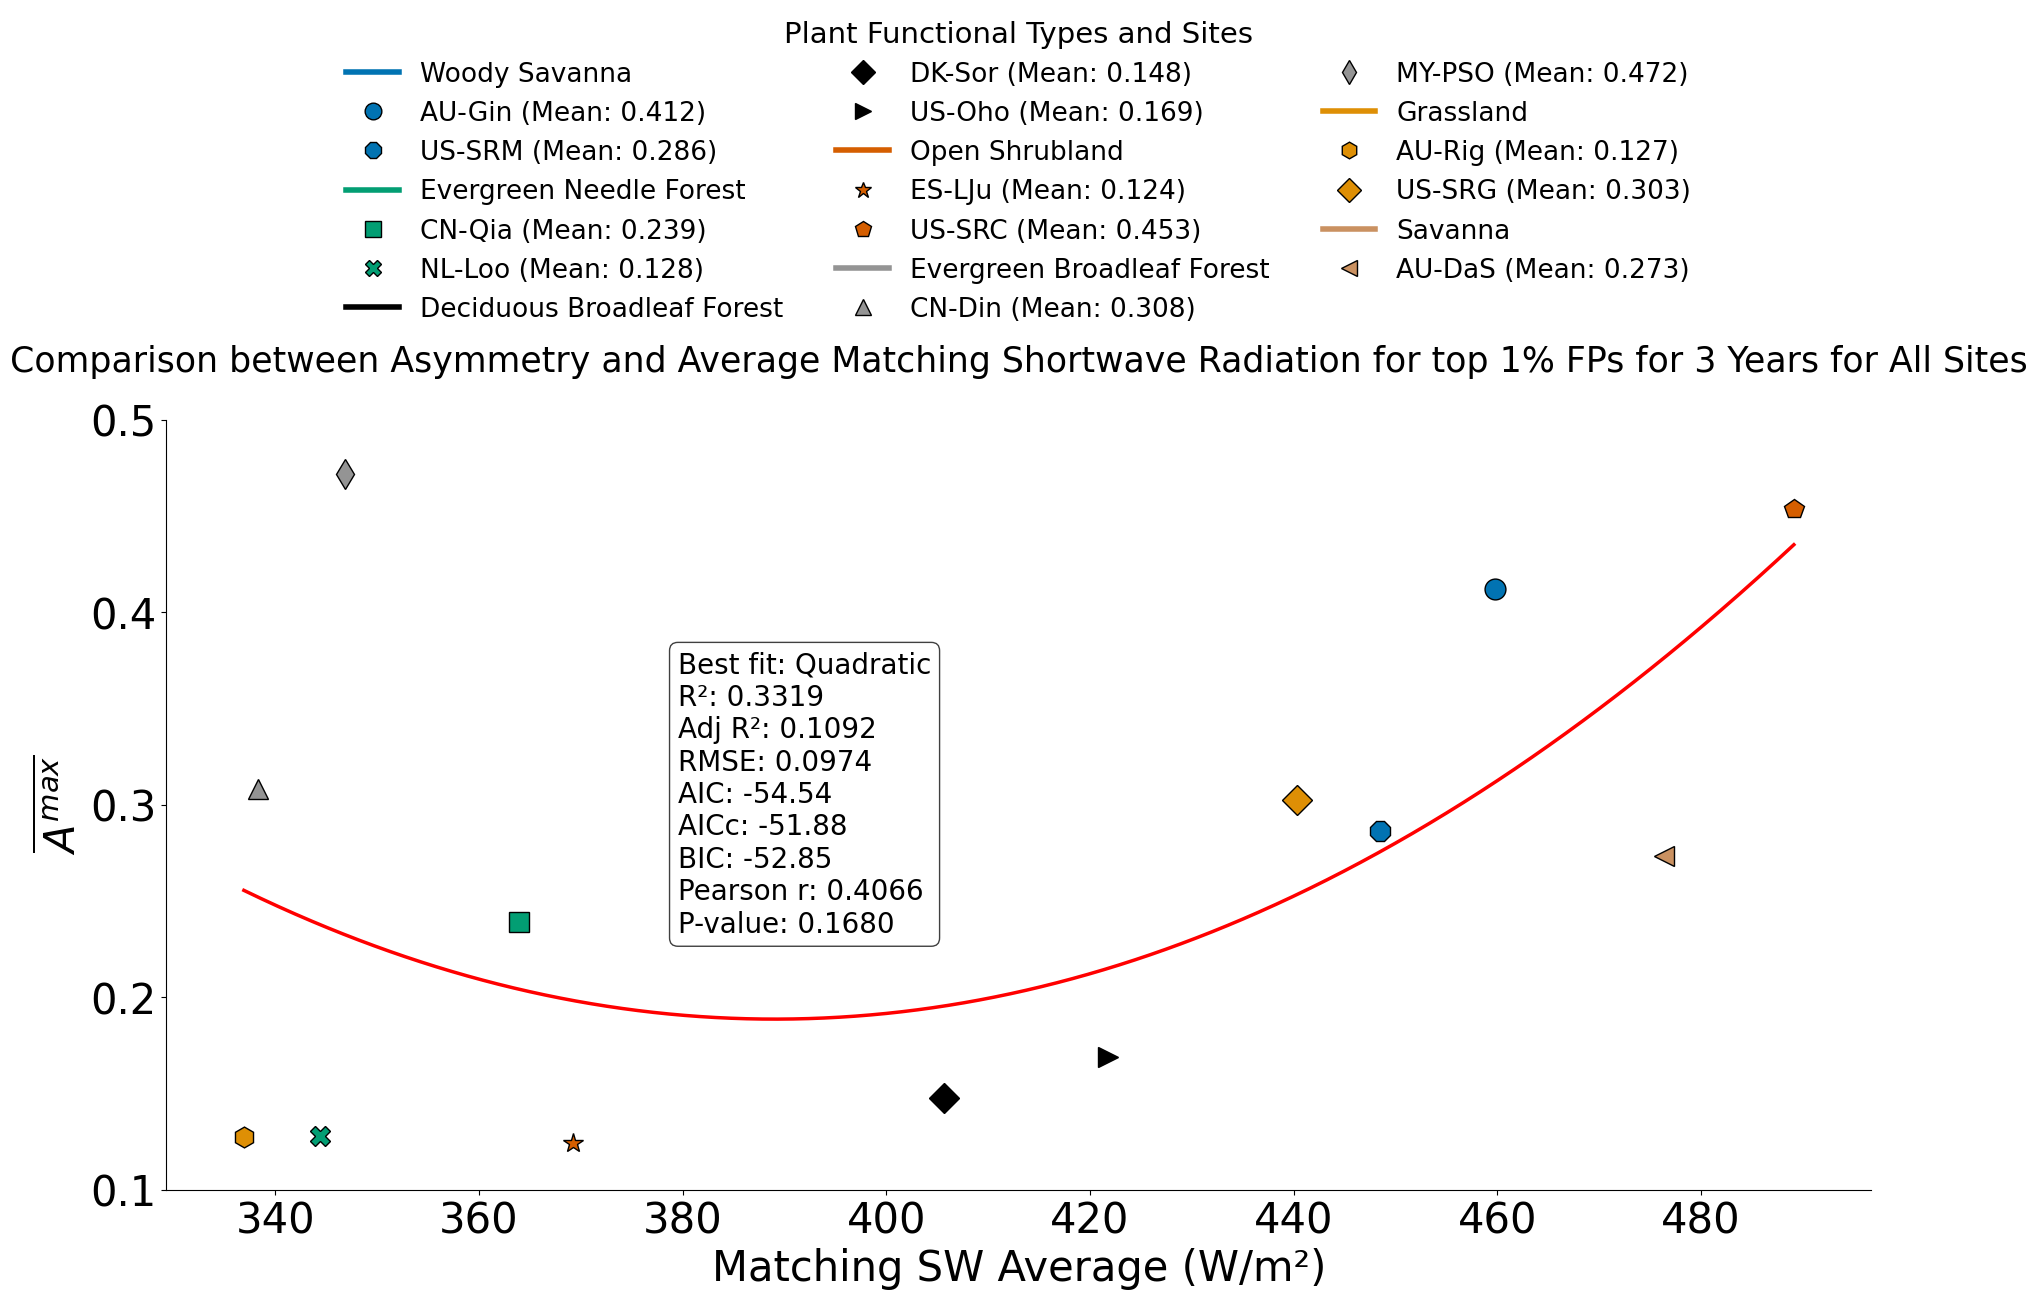

In [8]:
x_data = np.array([v["sw_mtchng"] for v in swm_data.values()], dtype=float)
y_data = np.array([v["meanacswm"] for v in swm_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)  # general Hill only

def fit_models_swm(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({
                "name": name, "func": func, "params": popt,
                "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                "aic": aic, "aicc": aicc, "bic": bic
            })
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_swm(x_data, y_data)
best = fits[0] if len(fits) else None

# Plotting 
fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in swm_data.items():
    ax_main.plot(d["sw_mtchng"], d["meanacswm"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)
ax_main.set_xlabel('Matching SW Average (W/m²)', fontsize=30)
ax_main.set_ylabel('$\\overline{A^{max}}$', fontsize=30)
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title(
    'Comparison between Asymmetry and Average Matching Shortwave Radiation for top 1% FPs for 3 Years for All Sites',
    fontsize=25, pad=35
)
ax_main.set_ylim(0.1, 0.5)
ax_main.set_yticks(np.arange(0.1, 0.51, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'

props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax_main.text(0.30, 0.70, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=props)

pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in swm_data:
        pft_groups.setdefault(pft, []).append(site_label)

legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = swm_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['meanacswm']:.3f})",
                                              markerfacecolor=color, markersize=12,
                                              markeredgecolor='black'))

legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()

Figure S10 in the Supplementary information - Relationship between average NEE asymmetry and 3yr soil moisture average for top 1% fluctuations for all sites

In [9]:
# 3yr soil moisture data
sm_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"//Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/3YRSM/{file}")
        sm_3yr = df.iloc[0, 1]   
        peakssm = df.iloc[:, 0]
        meanacsm = np.mean(peakssm)
        stdacsm = np.std(peakssm)
        sm_data[label] = {"sm_3yr": sm_3yr, "meanacsm": meanacsm, "stdacsm": stdacsm, "marker": marker, "color": color}

In [10]:
x_data = np.array([v["sm_3yr"] for v in sm_data.values()], dtype=float)
y_data = np.array([v["meanacsm"] for v in sm_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)  # general Hill only

def fit_models_sm(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({"name": name, "func": func, "params": popt,
                            "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                            "aic": aic, "aicc": aicc, "bic": bic})
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/996998296.py:10: RuntimeWarning: invalid value encountered in log
  def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
/Users/nikhi/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_minpack_py.py:493: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T


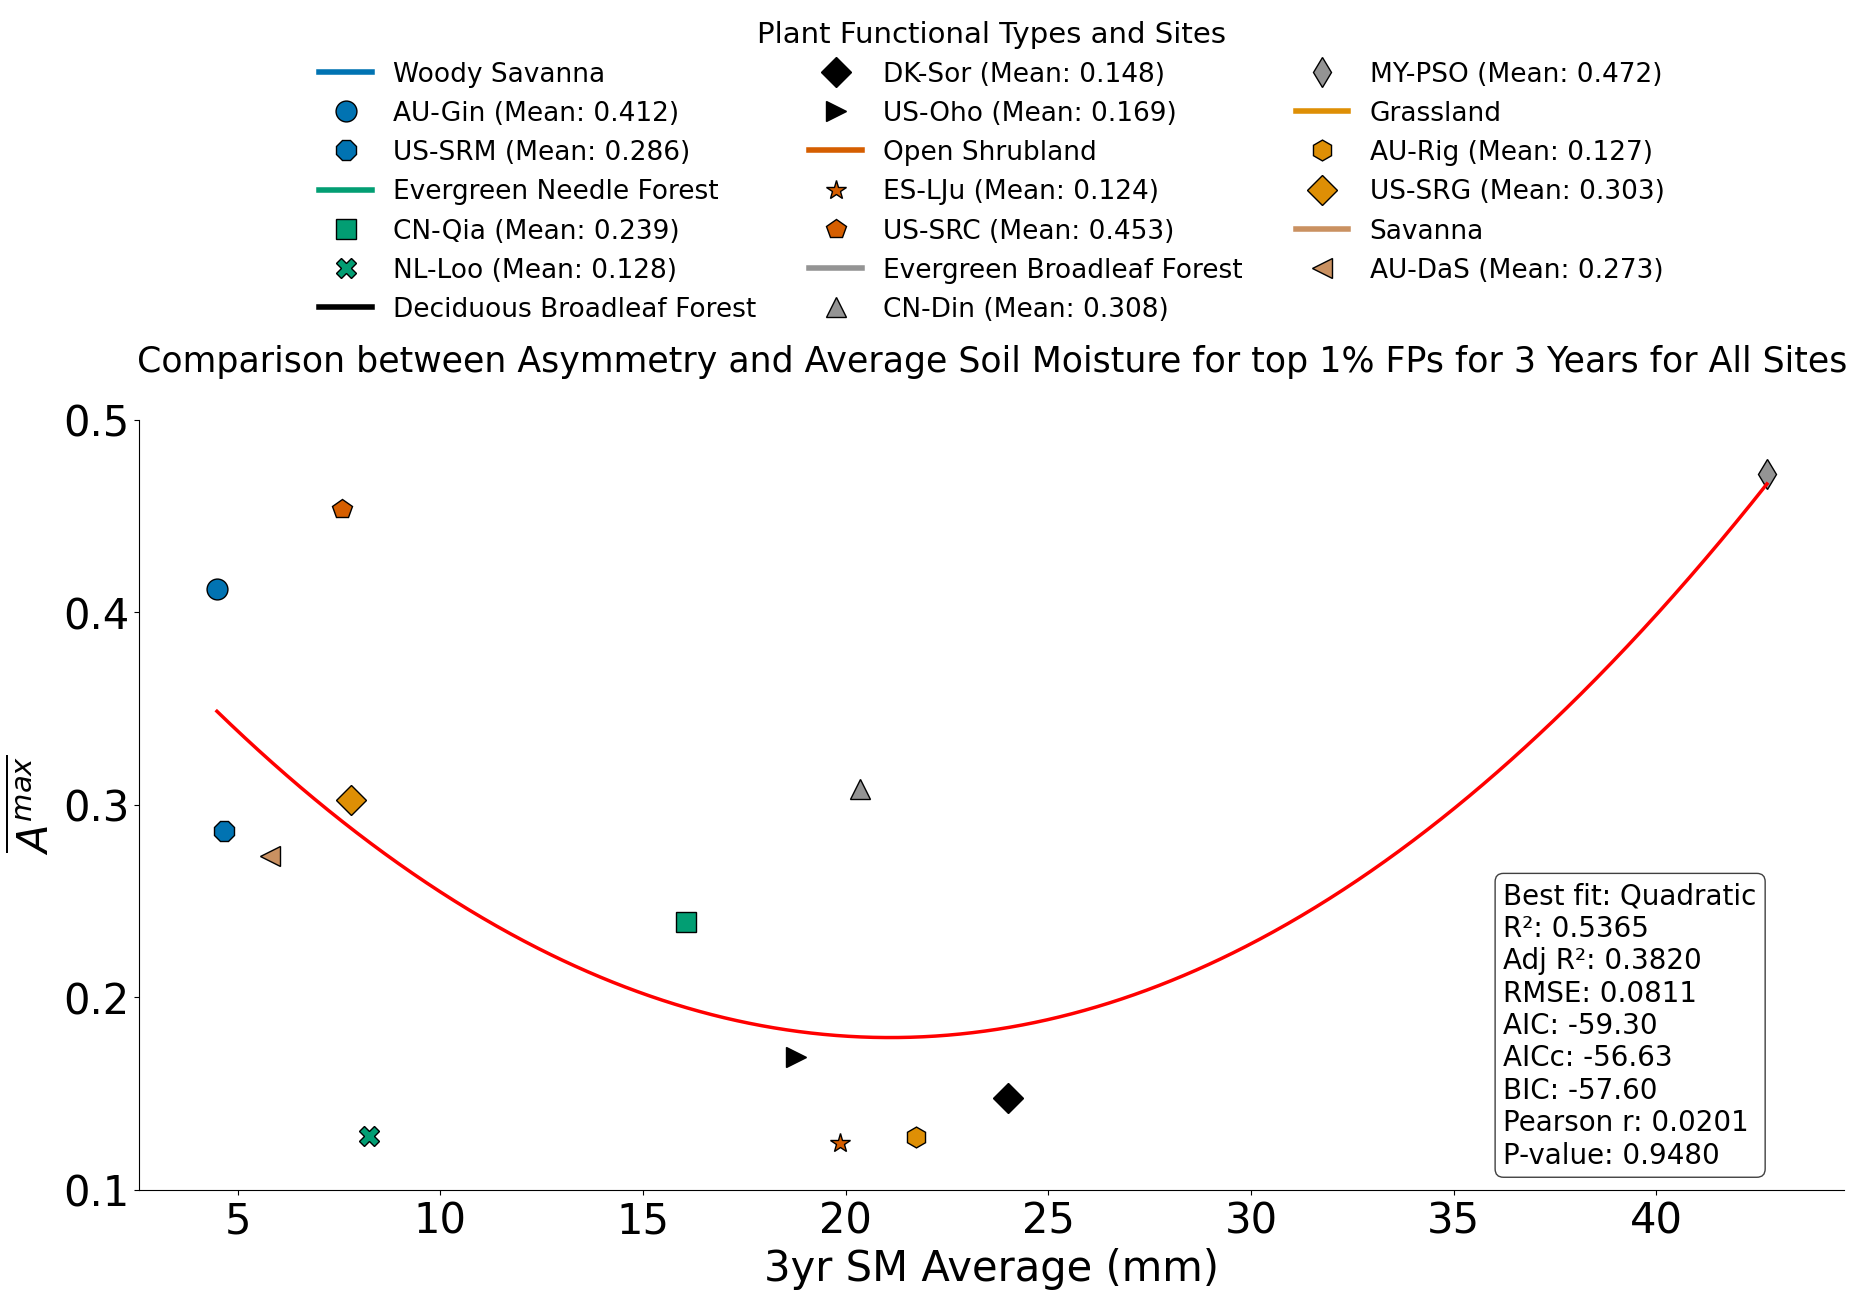

In [11]:
# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_sm(x_data, y_data)
best = fits[0] if len(fits) else None

# Plotting 
fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in sm_data.items():
    ax_main.plot(d["sm_3yr"], d["meanacsm"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)

ax_main.set_xlabel('3yr SM Average (mm)', fontsize=30)
ax_main.set_ylabel('$\\overline{A^{max}}$', fontsize=30)
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title('Comparison between Asymmetry and Average Soil Moisture for top 1% FPs for 3 Years for All Sites',
                  fontsize=25, pad=35)
ax_main.set_ylim(0.1, 0.5)
ax_main.set_yticks(np.arange(0.1, 0.51, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'
ax_main.text(0.80, 0.4, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in sm_data:
        pft_groups.setdefault(pft, []).append(site_label)

legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = sm_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['meanacsm']:.3f})",
                                              markerfacecolor=color, markersize=15,
                                              markeredgecolor='black'))
legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()

Figure S11 in the Supplementary information - Relationship between average NEE asymmetry and daily average soil moisture for top 1%
fluctuations for all sites

In [12]:
# Daily soil moisture data
smm_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"/Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/MATCHINGSM/{file}")
        sm_mtchng = df.iloc[0, 1]   
        peakssmm = df.iloc[:, 0]
        meanacsmm = np.mean(peakssmm)
        stdacsmm = np.std(peakssmm)
        smm_data[label] = {"sm_mtchng": sm_mtchng, "meanacsmm": meanacsmm, "stdacsmm": stdacsmm, "marker": marker, "color": color}


/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/426713156.py:10: RuntimeWarning: invalid value encountered in log
  def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
/Users/nikhi/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_minpack_py.py:493: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T


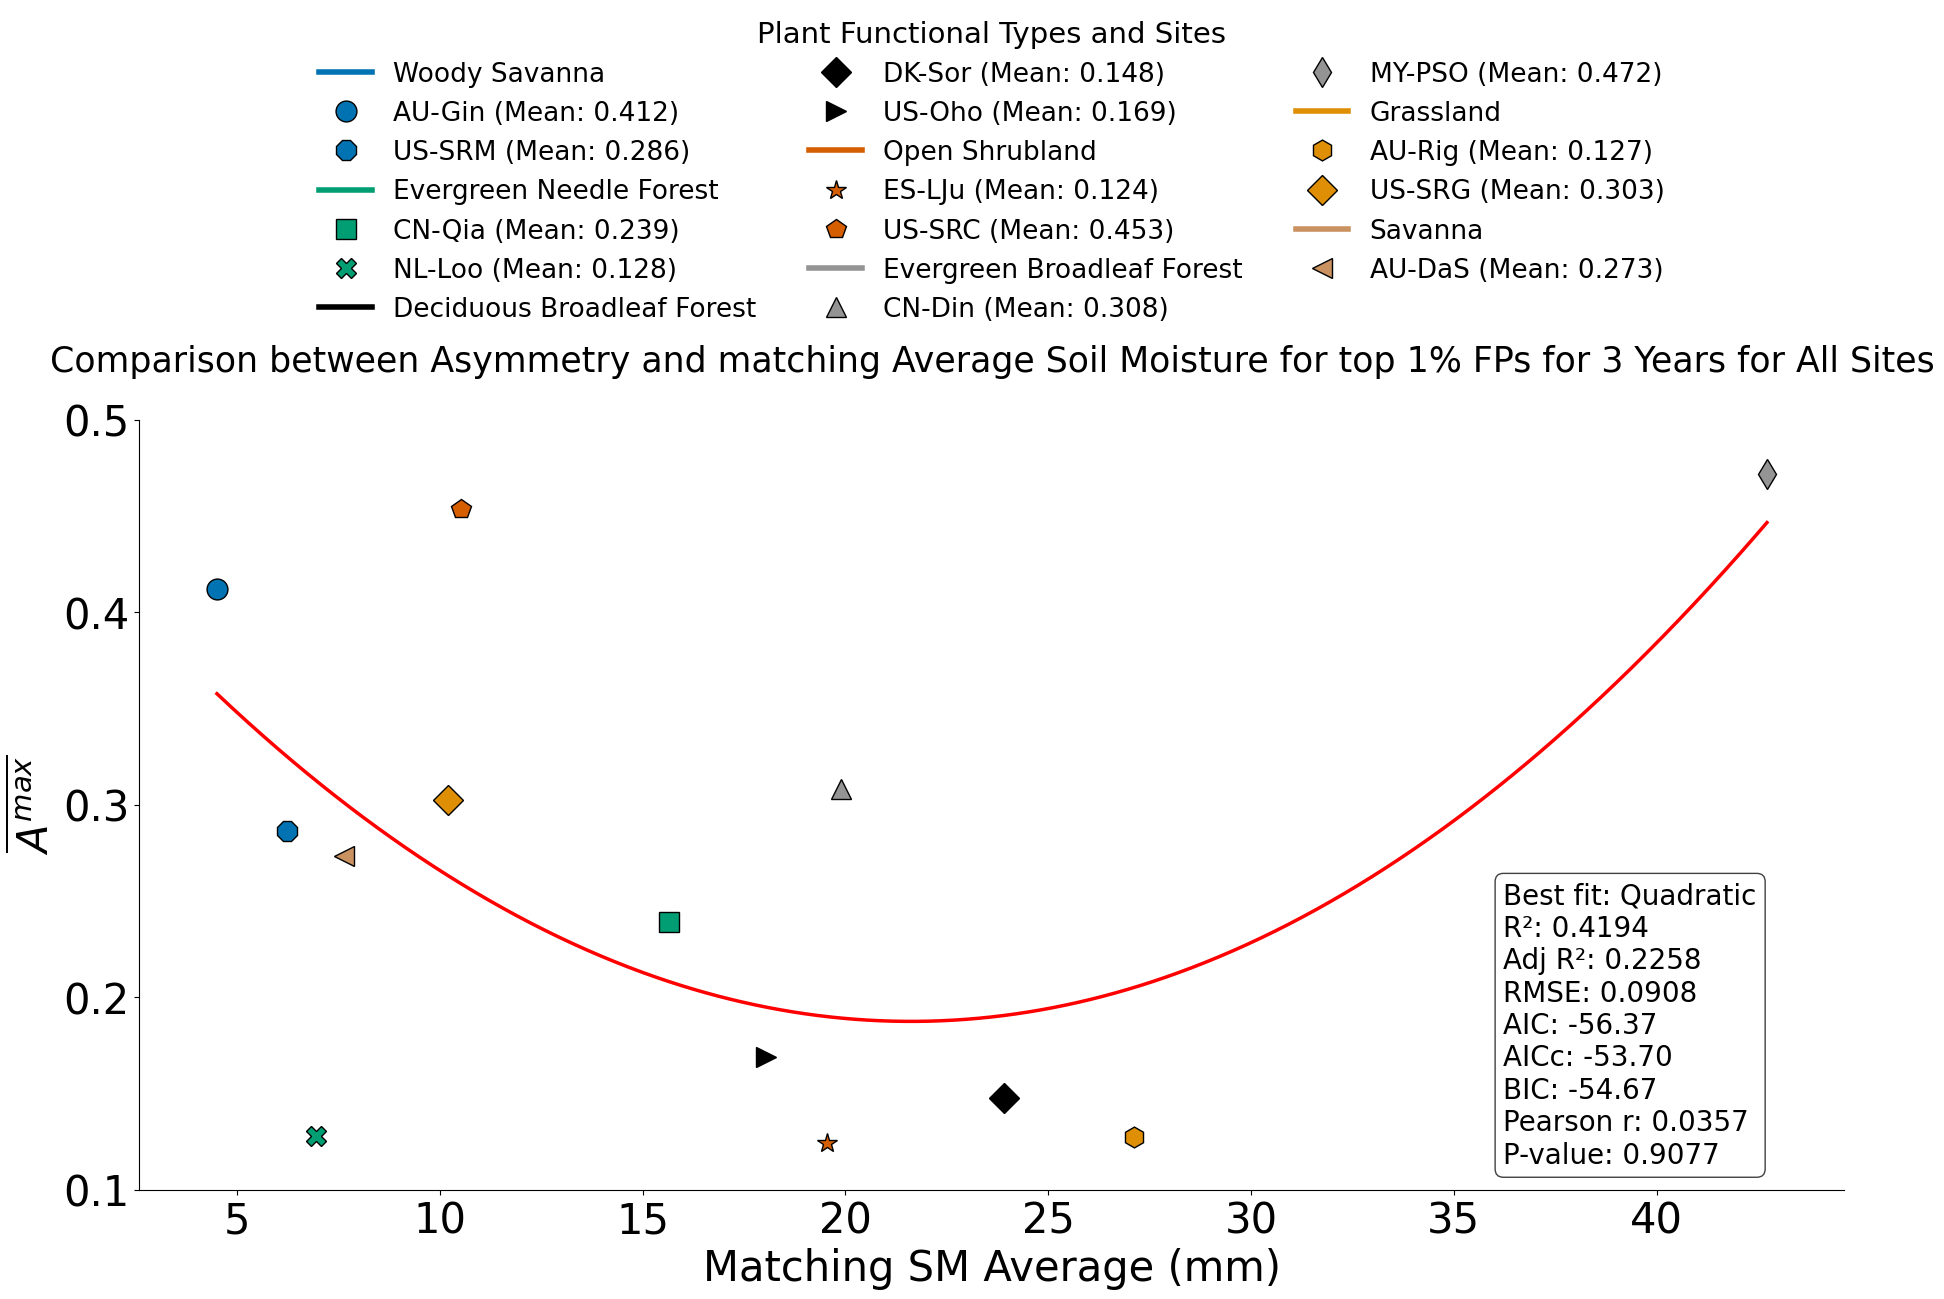

In [13]:
x_data = np.array([v["sm_mtchng"] for v in smm_data.values()], dtype=float)
y_data = np.array([v["meanacsmm"] for v in smm_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)

def fit_models_smm(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({"name": name, "func": func, "params": popt,
                            "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                            "aic": aic, "aicc": aicc, "bic": bic})
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_smm(x_data, y_data)
best = fits[0] if len(fits) else None

fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in smm_data.items():
    ax_main.plot(d["sm_mtchng"], d["meanacsmm"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)
ax_main.set_xlabel('Matching SM Average (mm)', fontsize=30)
ax_main.set_ylabel('$\\overline{A^{max}}$', fontsize=30)
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title('Comparison between Asymmetry and matching Average Soil Moisture for top 1% FPs for 3 Years for All Sites',
                  fontsize=25, pad=35)
ax_main.set_ylim(0.1, 0.5)
ax_main.set_yticks(np.arange(0.1, 0.51, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'
ax_main.text(0.80, 0.4, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

# Legend (same placement)
pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in smm_data:
        pft_groups.setdefault(pft, []).append(site_label)

legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = smm_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['meanacsmm']:.3f})",
                                              markerfacecolor=color, markersize=15,
                                              markeredgecolor='black'))
legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()


Figure S12 in the Supplementary information - Relationship between average NEE asymmetry and 3yr precipitation average for top 1%
fluctuations for all sites

In [14]:
# 3yr precipitation data
prec_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"//Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/3YRPREC/{file}")
        prec_3yr = df.iloc[0, 1]   
        peaksprec = df.iloc[:, 0]
        meanacprec = np.mean(peaksprec)
        stdacprec = np.std(peaksprec)
        prec_data[label] = {"prec_3yr": prec_3yr, "meanacprec": meanacprec, "stdacprec": stdacprec, "marker": marker, "color": color}

/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/4172238465.py:10: RuntimeWarning: invalid value encountered in log
  def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/4172238465.py:11: RuntimeWarning: overflow encountered in exp
  def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))


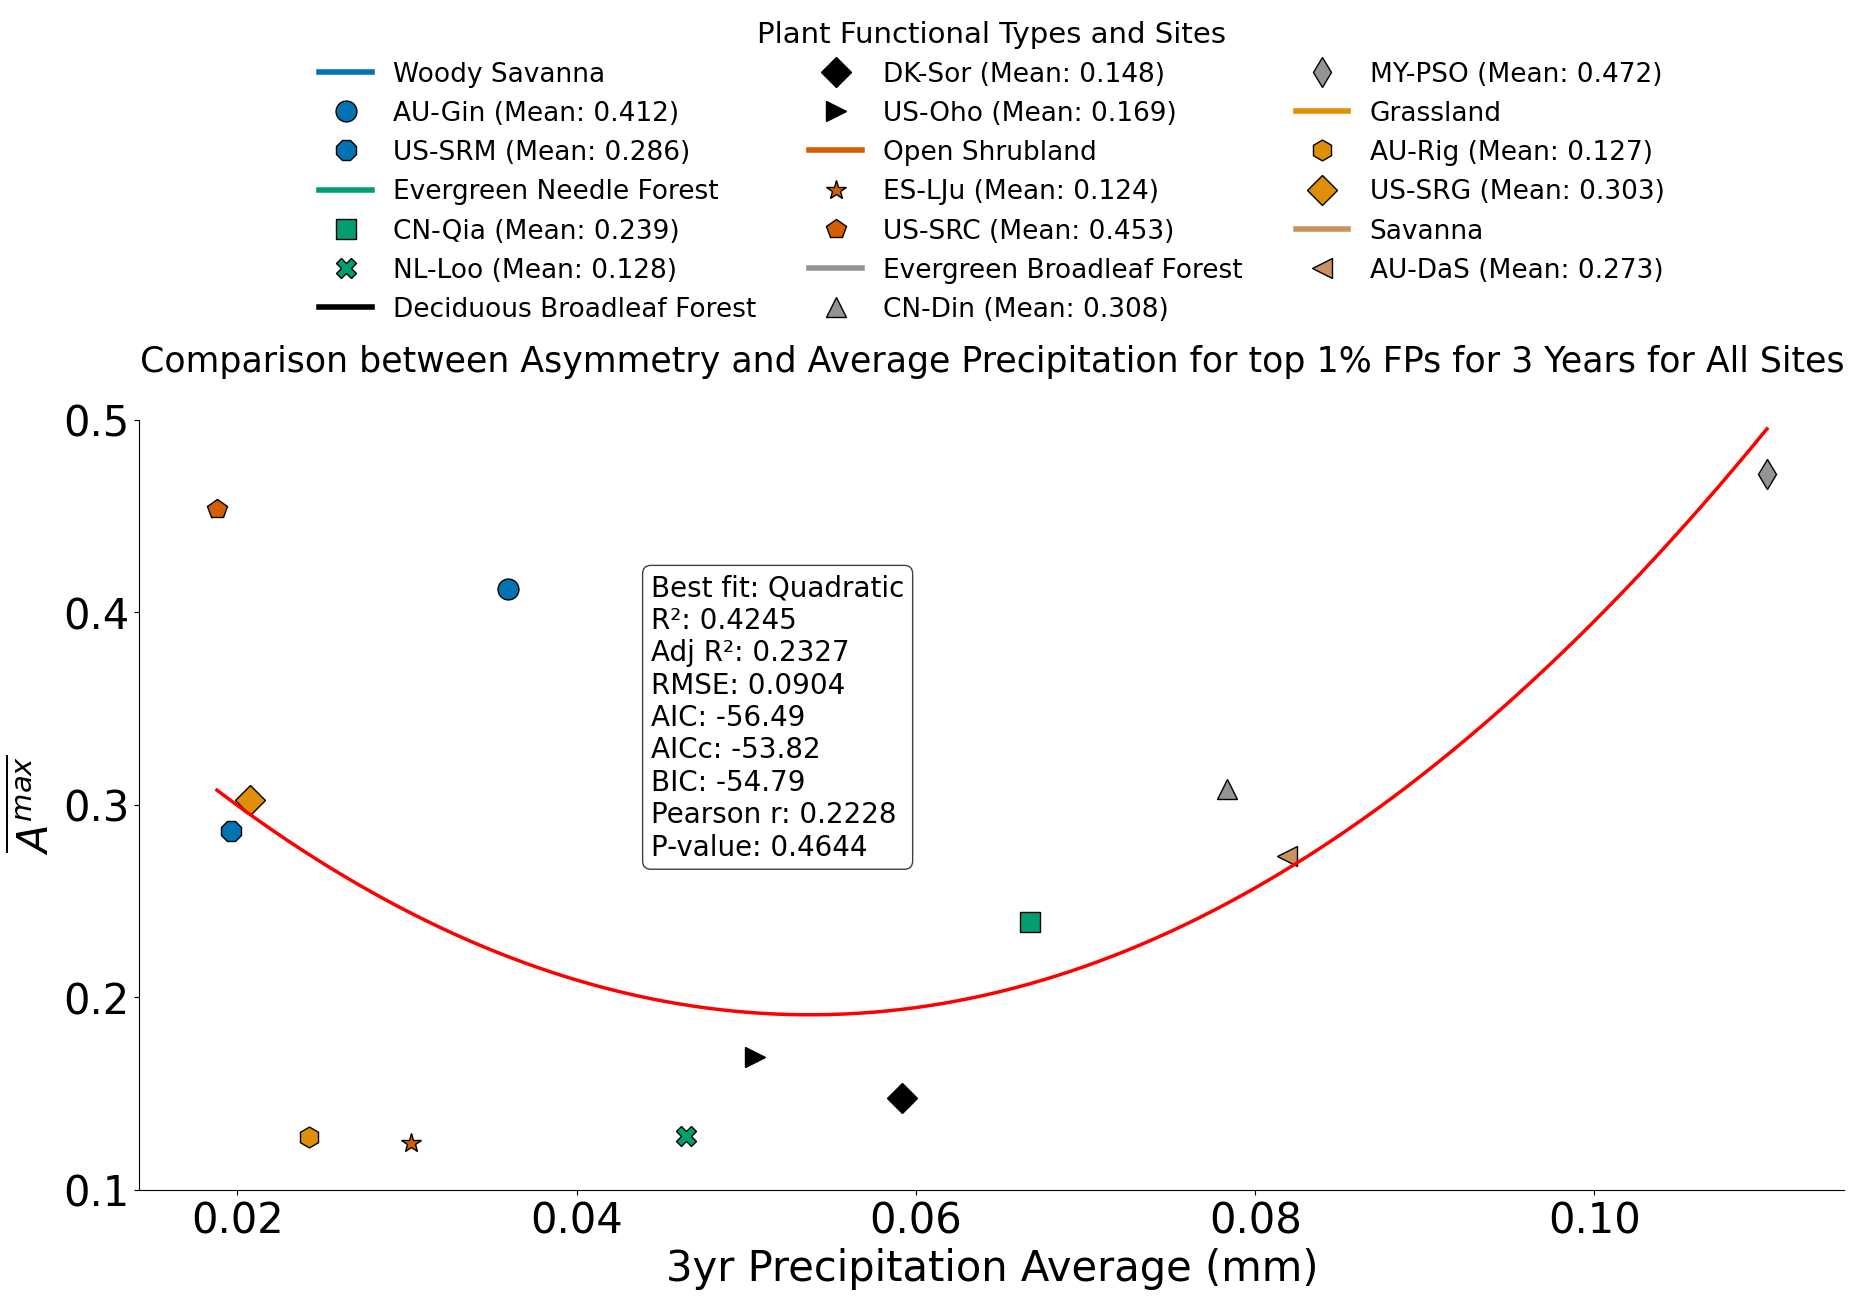

In [15]:
x_data = np.array([v["prec_3yr"] for v in prec_data.values()], dtype=float)
y_data = np.array([v["meanacprec"] for v in prec_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)

def fit_models_prec(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({"name": name, "func": func, "params": popt,
                            "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                            "aic": aic, "aicc": aicc, "bic": bic})
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_prec(x_data, y_data)
best = fits[0] if len(fits) else None

fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in prec_data.items():
    ax_main.plot(d["prec_3yr"], d["meanacprec"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)
ax_main.set_xlabel('3yr Precipitation Average (mm)', fontsize=30)
ax_main.set_ylabel('$\\overline{A^{max}}$', fontsize=30)
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title('Comparison between Asymmetry and Average Precipitation for top 1% FPs for 3 Years for All Sites',
                  fontsize=25, pad=35)
ax_main.set_ylim(0.1, 0.5)
ax_main.set_yticks(np.arange(0.1, 0.51, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'
ax_main.text(0.3, 0.8, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in prec_data:
        pft_groups.setdefault(pft, []).append(site_label)

legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = prec_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['meanacprec']:.3f})",
                                              markerfacecolor=color, markersize=15,
                                              markeredgecolor='black'))
legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()



Figure S13 in the Supplementary information - Relationship between average NEE asymmetry and daily average precipitation for top 1%
fluctuations for all sites

In [16]:
# Daily precipitation data
precm_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"/Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/MATCHINGPREC/{file}")
        prec_mtchng = df.iloc[0, 1]   
        peaksprecm = df.iloc[:, 0]
        meanacprecm = np.mean(peaksprecm)
        stdacprecm = np.std(peaksprecm)
        precm_data[label] = {"prec_mtchng": prec_mtchng, "meanacprecm": meanacprecm, "stdacprecm": stdacprecm, "marker": marker, "color": color}




/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/2698851450.py:10: RuntimeWarning: invalid value encountered in log
  def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/2698851450.py:28: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)


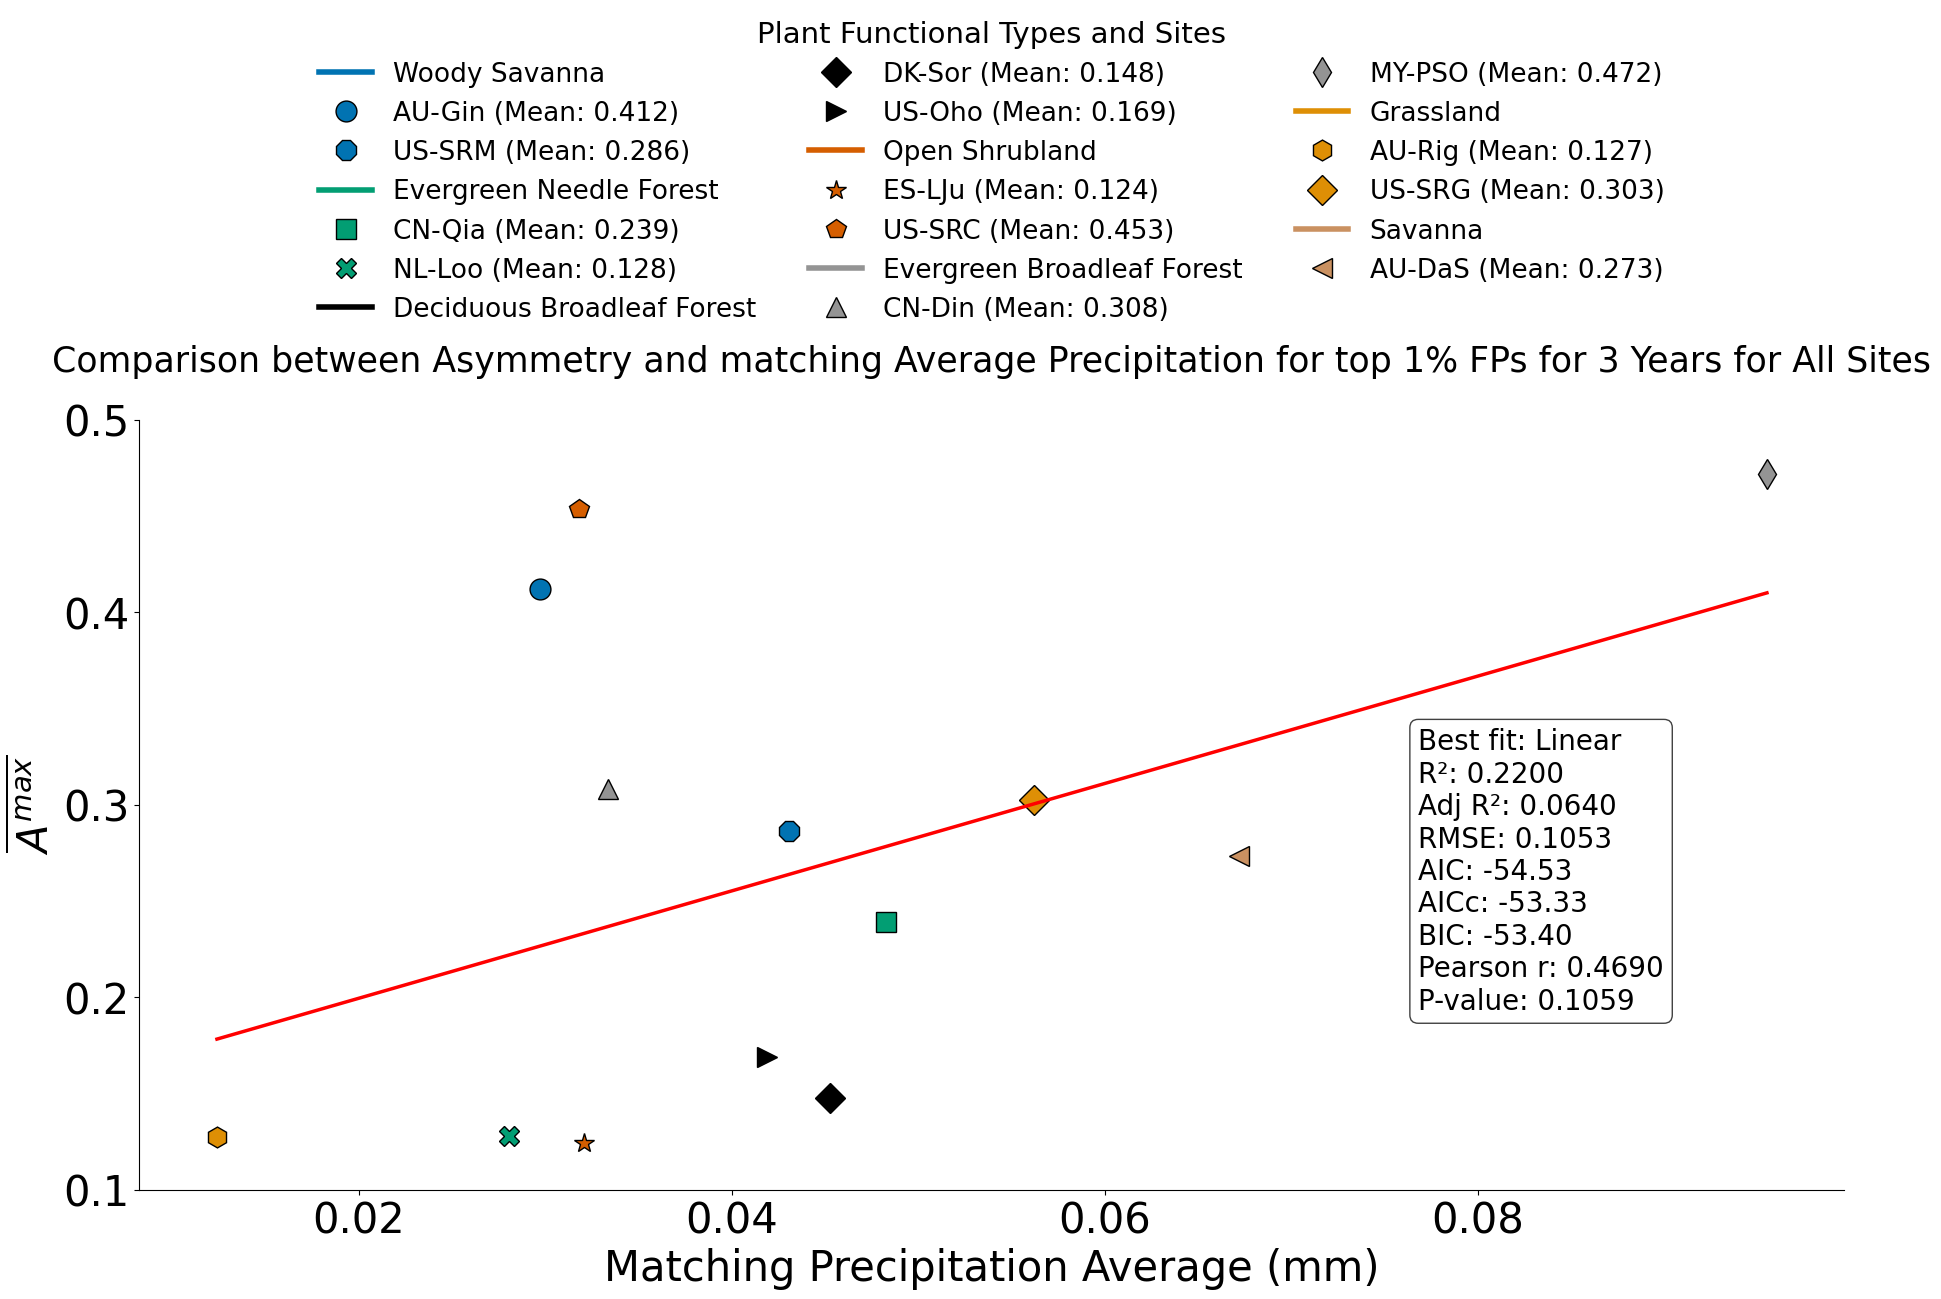

In [17]:
x_data = np.array([v["prec_mtchng"] for v in precm_data.values()], dtype=float)
y_data = np.array([v["meanacprecm"] for v in precm_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)

def fit_models_prec(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({"name": name, "func": func, "params": popt,
                            "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                            "aic": aic, "aicc": aicc, "bic": bic})
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_prec(x_data, y_data)
best = fits[0] if len(fits) else None

# Plotting
fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in precm_data.items():
    ax_main.plot(d["prec_mtchng"], d["meanacprecm"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)
ax_main.set_xlabel('Matching Precipitation Average (mm)', fontsize=30)
ax_main.set_ylabel('$\\overline{A^{max}}$', fontsize=30)
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title('Comparison between Asymmetry and matching Average Precipitation for top 1% FPs for 3 Years for All Sites',
                  fontsize=25, pad=35)
ax_main.set_ylim(0.1, 0.5)
ax_main.set_yticks(np.arange(0.1, 0.51, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))


if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'
ax_main.text(0.75, 0.6, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in prec_data:
        pft_groups.setdefault(pft, []).append(site_label)

legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = precm_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['meanacprecm']:.3f})",
                                              markerfacecolor=color, markersize=15,
                                              markeredgecolor='black'))
legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()

Figure S14 in the Supplementary information - Relationship between average NEE asymmetry and 3yr average vapor pressure deficit for top 1%
fluctuations for all sites

In [18]:
# 3yr average vapor pressure deficit data
vpd_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"/Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/3YRVPD/{file}")
        vpd_3yr = df.iloc[0, 1]   
        peaksvpd = df.iloc[:, 0]
        meanacvpd = np.mean(peaksvpd)
        stdacvpd = np.std(peaksvpd)
        vpd_data[label] = {"vpd_3yr": vpd_3yr, "meanacvpd": meanacvpd, "stdacvpd": stdacvpd, "marker": marker, "color": color}

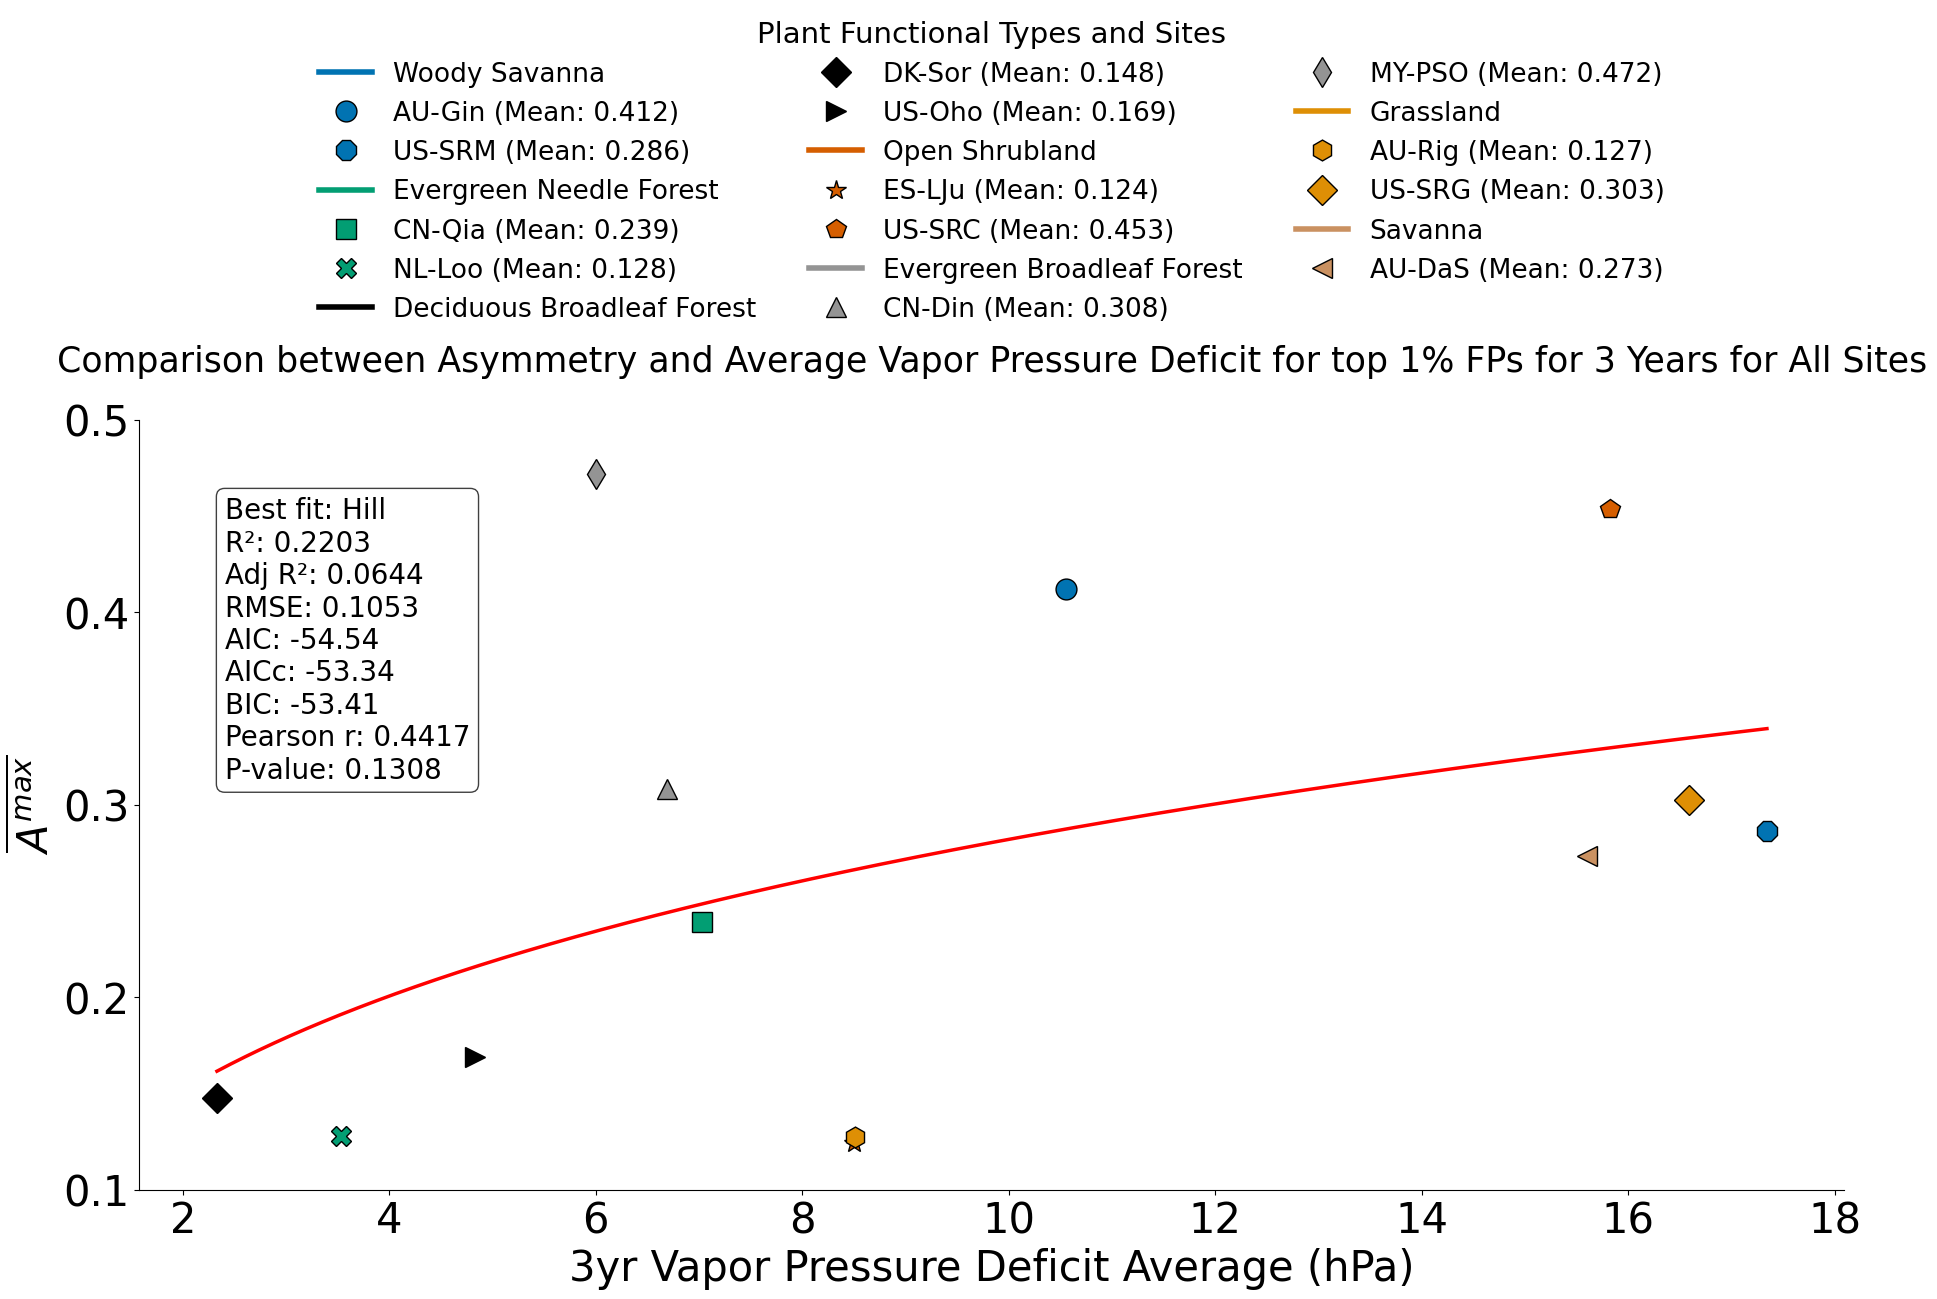

In [19]:
x_data = np.array([v["vpd_3yr"] for v in vpd_data.values()], dtype=float)
y_data = np.array([v["meanacvpd"] for v in vpd_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)

def fit_models_vpd(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({"name": name, "func": func, "params": popt,
                            "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                            "aic": aic, "aicc": aicc, "bic": bic})
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_vpd(x_data, y_data)
best = fits[0] if len(fits) else None

# Plotting
fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in vpd_data.items():
    ax_main.plot(d["vpd_3yr"], d["meanacvpd"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)

ax_main.set_xlabel('3yr Vapor Pressure Deficit Average (hPa)', fontsize=30)
ax_main.set_ylabel('$\\overline{A^{max}}$', fontsize=30)
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title('Comparison between Asymmetry and Average Vapor Pressure Deficit for top 1% FPs for 3 Years for All Sites',
                  fontsize=25, pad=35)
ax_main.set_ylim(0.1, 0.5)
ax_main.set_yticks(np.arange(0.1, 0.51, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'
ax_main.text(0.05, 0.9, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in vpd_data:
        pft_groups.setdefault(pft, []).append(site_label)

legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = vpd_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['meanacvpd']:.3f})",
                                              markerfacecolor=color, markersize=15,
                                              markeredgecolor='black'))
legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()

Figure S15 in the Supplementary information - Relationship between average NEE asymmetry and daily average vapor pressure deficit for top
1% fluctuations for all sites

In [20]:
# Daily vapor pressure deficit data
vpdm_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"//Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/MATCHINGVPD/{file}")
        vpd_mtchng = df.iloc[0, 1]   
        peaksvpdm = df.iloc[:, 0]
        meanacvpdm = np.mean(peaksvpdm)
        stdacvpdm = np.std(peaksvpdm)
        vpdm_data[label] = {"vpd_mtchng": vpd_mtchng, "meanacvpdm": meanacvpdm, "stdacvpdm": stdacvpdm, "marker": marker, "color": color}


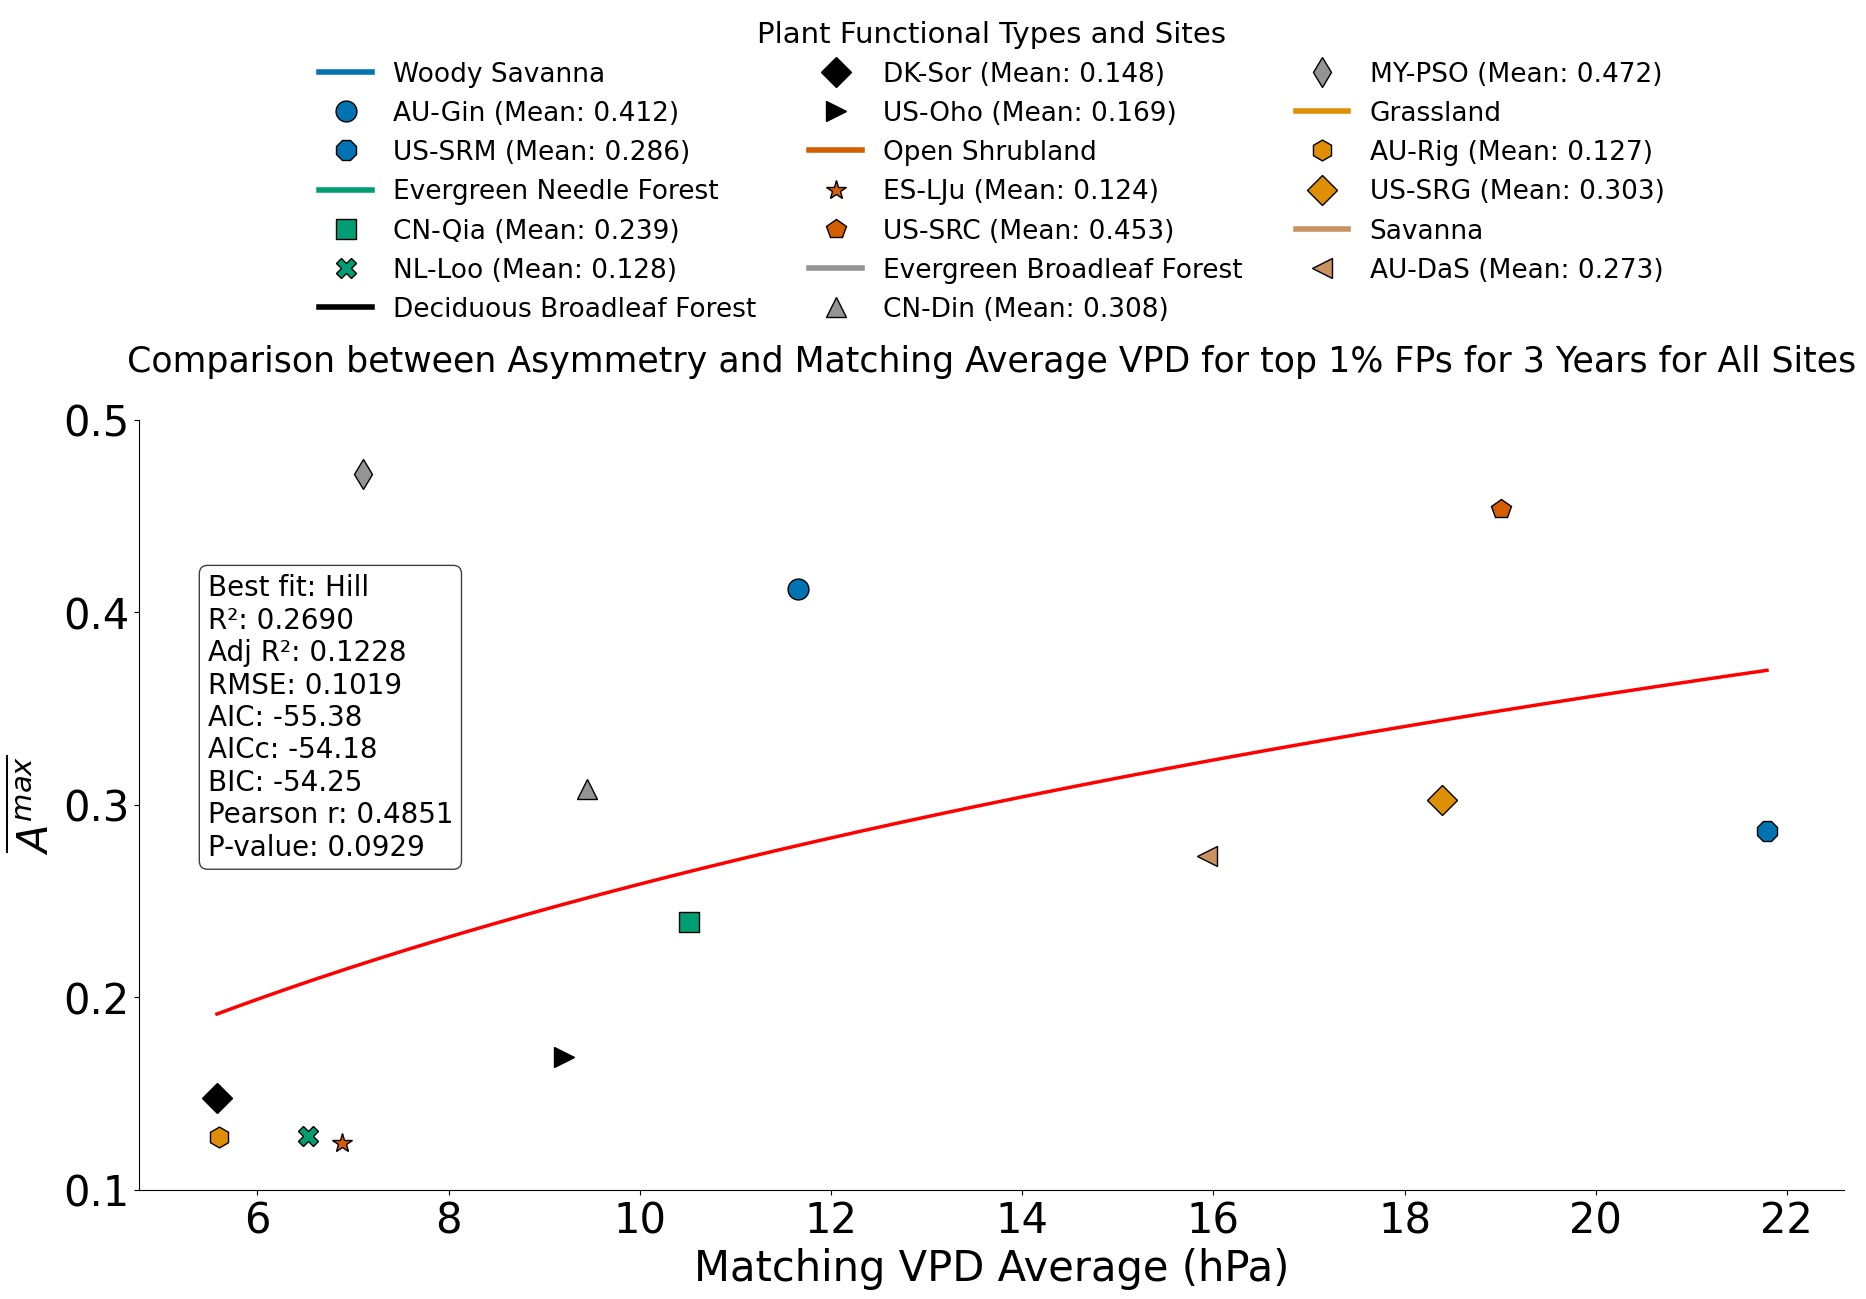

In [21]:
x_data = np.array([v["vpd_mtchng"] for v in vpdm_data.values()], dtype=float)
y_data = np.array([v["meanacvpdm"] for v in vpdm_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)

def fit_models_vpdm(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({"name": name, "func": func, "params": popt,
                            "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                            "aic": aic, "aicc": aicc, "bic": bic})
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_vpdm(x_data, y_data)
best = fits[0] if len(fits) else None

# Plotting
fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in vpdm_data.items():
    ax_main.plot(d["vpd_mtchng"], d["meanacvpdm"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)

ax_main.set_xlabel('Matching VPD Average (hPa)', fontsize=30)
ax_main.set_ylabel('$\\overline{A^{max}}$', fontsize=30)
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title('Comparison between Asymmetry and Matching Average VPD for top 1% FPs for 3 Years for All Sites',
                  fontsize=25, pad=35)
ax_main.set_ylim(0.1, 0.5)
ax_main.set_yticks(np.arange(0.1, 0.51, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'
ax_main.text(0.04, 0.8, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.75))

pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in vpdm_data:
        pft_groups.setdefault(pft, []).append(site_label)

legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = vpdm_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['meanacvpdm']:.3f})",
                                              markerfacecolor=color, markersize=15,
                                              markeredgecolor='black'))
legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()


Figure S16 in the Supplementary information - Relationship between average NEE asymmetry and 3yr Mean Annual Temperature: 3yr Mean
Annual Precipitation for top 1% fluctuations for all sites

In [22]:
# 3yr Mean Annual Temperature and 3yr Mean Annual Precipitation data
tp_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"/Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/3YRTEMP_PREC/{file}")
        tp_3yr = df.iloc[0, 1]   
        peakstp = df.iloc[:, 0]
        meanactp = np.mean(peakstp)
        stdactp = np.std(peakstp)
        tp_data[label] = {"tp_3yr": tp_3yr, "meanactp": meanactp, "stdactp": stdactp, "marker": marker, "color": color}

/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/109432179.py:10: RuntimeWarning: invalid value encountered in log
  def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/109432179.py:11: RuntimeWarning: overflow encountered in exp
  def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/109432179.py:12: RuntimeWarning: invalid value encountered in scalar power
  def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)  # general Hill only


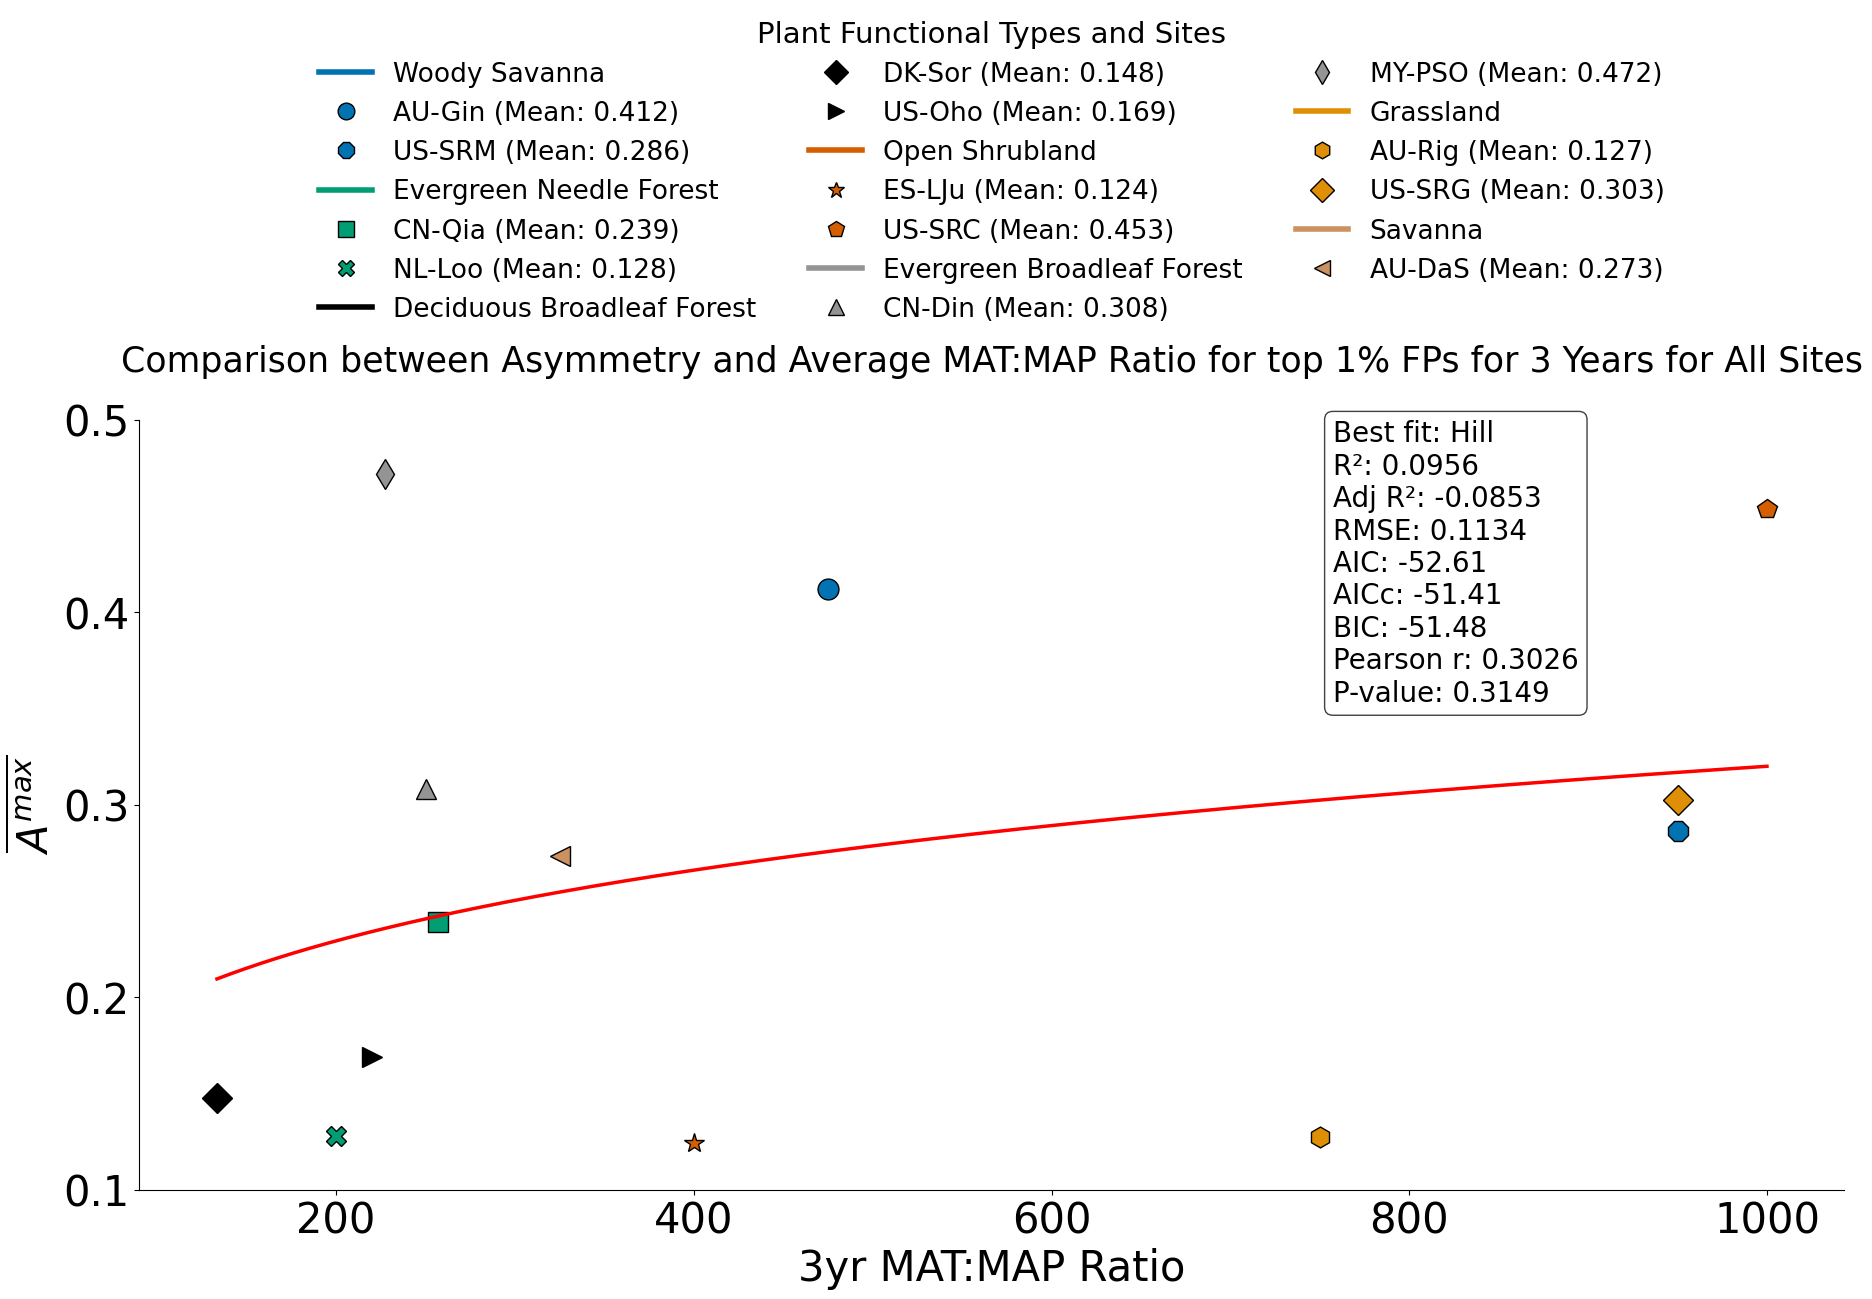

In [23]:
x_data = np.array([v["tp_3yr"] for v in tp_data.values()], dtype=float)
y_data = np.array([v["meanactp"] for v in tp_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)  # general Hill only

def fit_models_tp(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),  # general Hill (no temp scaling)
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({
                "name": name, "func": func, "params": popt,
                "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                "aic": aic, "aicc": aicc, "bic": bic
            })
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_tp(x_data, y_data)
best = fits[0] if len(fits) else None

# Plotting
fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in tp_data.items():
    ax_main.plot(d["tp_3yr"], d["meanactp"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)

ax_main.set_xlabel('3yr MAT:MAP Ratio', fontsize=30)
ax_main.set_ylabel('$\\overline{A^{max}}$', fontsize=30)
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title(
    'Comparison between Asymmetry and Average MAT:MAP Ratio for top 1% FPs for 3 Years for All Sites',
    fontsize=25, pad=35
)
ax_main.set_ylim(0.1, 0.5)
ax_main.set_yticks(np.arange(0.1, 0.51, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'

props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax_main.text(0.7, 1.0, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=props)

pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in tp_data:
        pft_groups.setdefault(pft, []).append(site_label)

legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = tp_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['meanactp']:.3f})",
                                              markerfacecolor=color, markersize=12,
                                              markeredgecolor='black'))

legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()


Figure S17 in the Supplementary information - Relationship between average NEE asymmetry and daily Mean Annual Temperature: daily Mean
Annual Precipitation for top 1% fluctuations for all

In [24]:
# Daily Mean Annual Temperature and daily Mean Annual Precipitation data
mtchngtp_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"/Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/MTCHNGTEMP_PRECTOP1/{file}")
        tp_mtchng = df.iloc[0, 1]   
        peakstp_mtchng = df.iloc[:, 0]
        meanactp_mtchng = np.mean(peakstp_mtchng)
        stdactp_mtchng = np.std(peakstp_mtchng)
        mtchngtp_data[label] = {"tp_mtchng": tp_mtchng, "meanactp_mtchng": meanactp_mtchng, "stdactp_mtchng": stdactp_mtchng, "marker": marker, "color": color}

/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/495820893.py:10: RuntimeWarning: invalid value encountered in log
  def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
/Users/nikhi/Library/Python/3.9/lib/python/site-packages/scipy/optimize/_minpack_py.py:493: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T


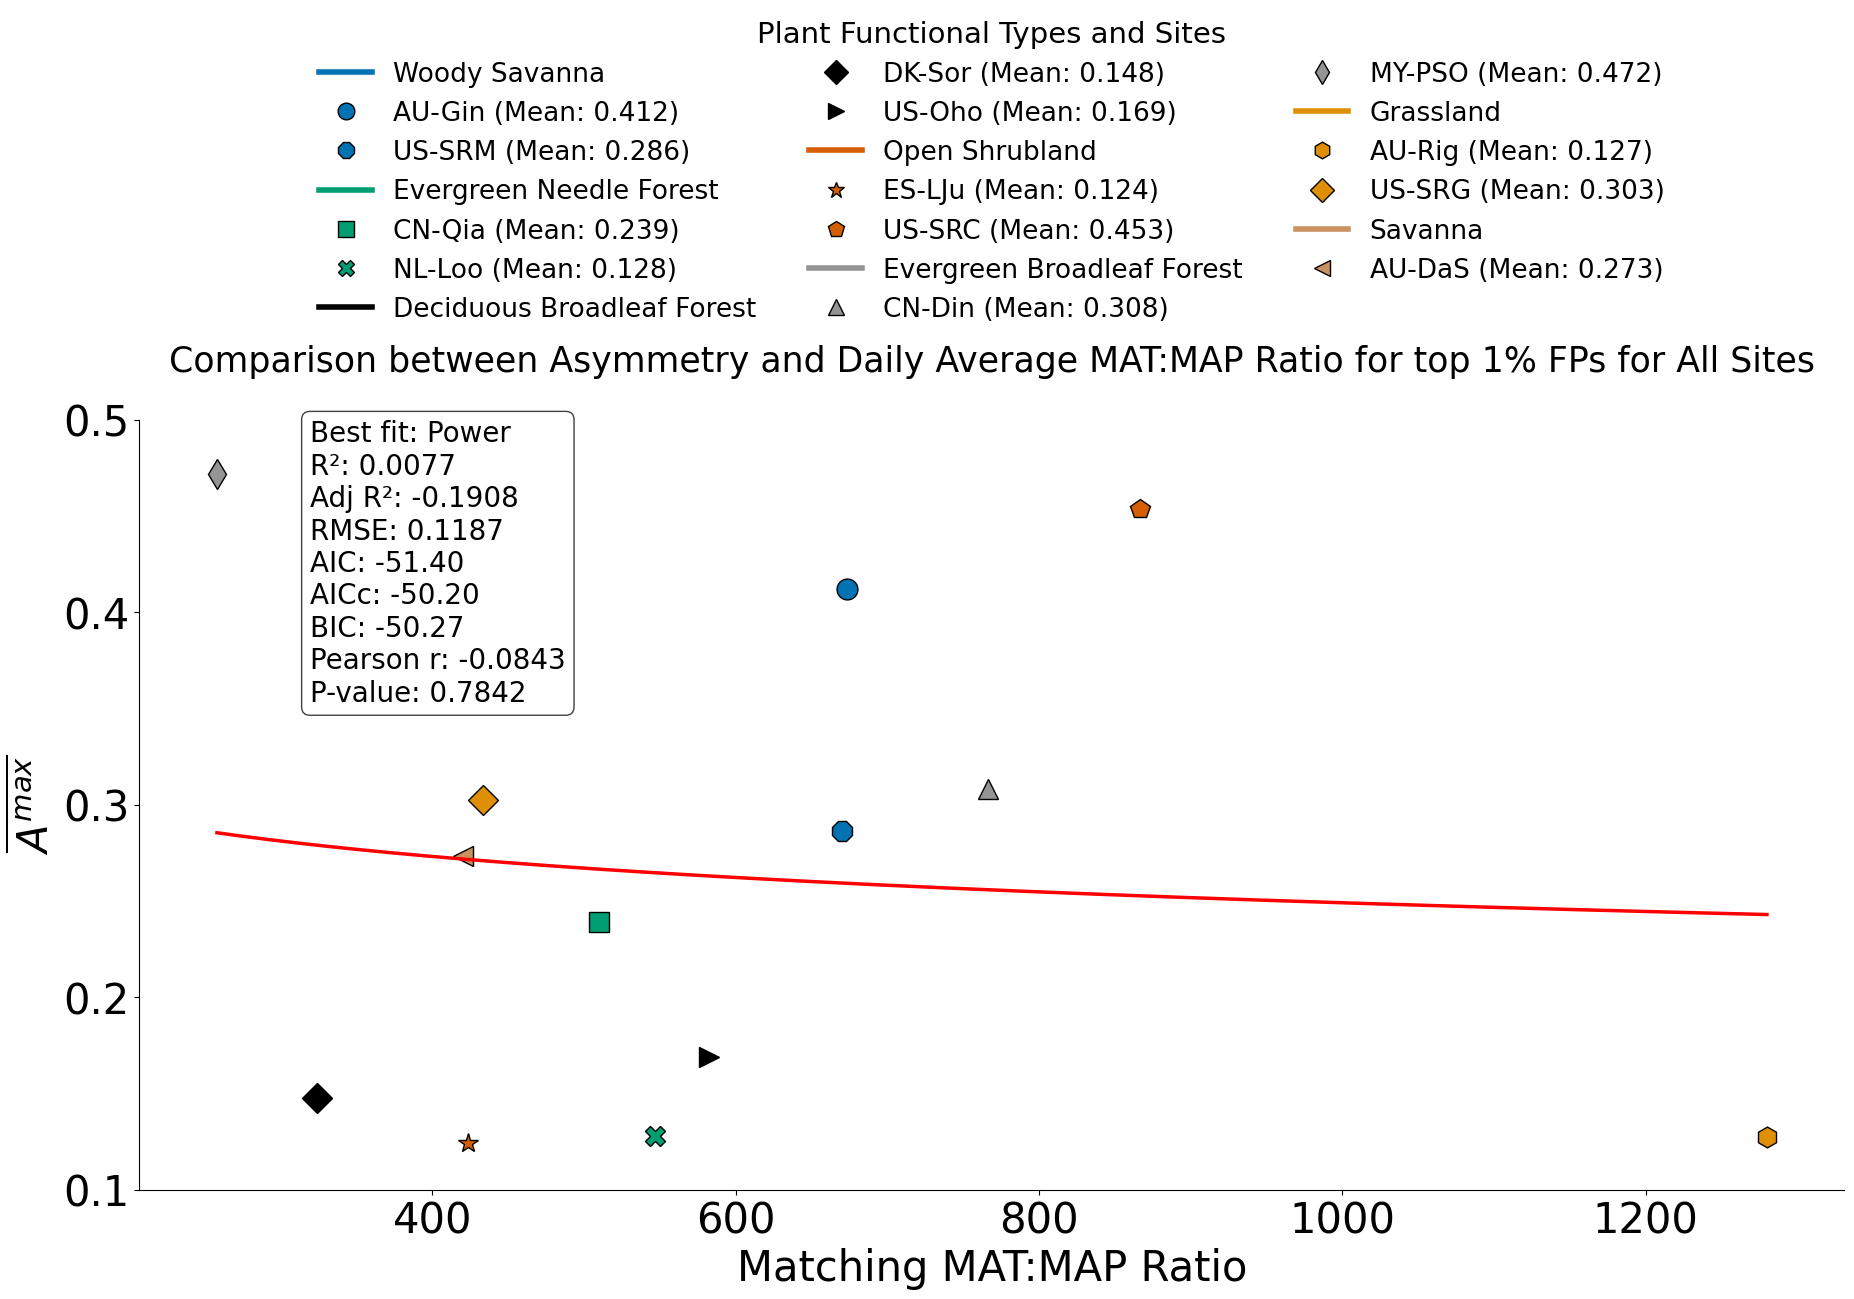

In [25]:
x_data = np.array([v["tp_mtchng"] for v in mtchngtp_data.values()], dtype=float)
y_data = np.array([v["meanactp_mtchng"] for v in mtchngtp_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)  # general Hill only

def fit_models_mtchngtp(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),  # general Hill (no temp scaling)
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({
                "name": name, "func": func, "params": popt,
                "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                "aic": aic, "aicc": aicc, "bic": bic
            })
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_mtchngtp(x_data, y_data)
best = fits[0] if len(fits) else None

# Plotting
fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in mtchngtp_data.items():
    ax_main.plot(d["tp_mtchng"], d["meanactp_mtchng"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)
ax_main.set_xlabel('Matching MAT:MAP Ratio', fontsize=30)
ax_main.set_ylabel('$\\overline{A^{max}}$', fontsize=30)
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title(
    'Comparison between Asymmetry and Daily Average MAT:MAP Ratio for top 1% FPs for All Sites',
    fontsize=25, pad=35
)
ax_main.set_ylim(0.1, 0.5)
ax_main.set_yticks(np.arange(0.1, 0.51, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))

if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'

props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax_main.text(0.10, 1.0, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=props)

# Legend (same placement as before)
pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in mtchngtp_data:
        pft_groups.setdefault(pft, []).append(site_label)

legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = mtchngtp_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['meanactp_mtchng']:.3f})",
                                              markerfacecolor=color, markersize=12,
                                              markeredgecolor='black'))

legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()


Figure S18 in the Supplementary information - Relationship between average NEE asymmetry and 3yr temperature average for all fluctuations
for all sites

In [26]:
# 3yr temperature average data
t3yr_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"/Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/ALLFLUC_TEMP/{file}")
        t_3yr = df.iloc[0, 1]   
        allflucpeakst = df.iloc[:, 0]
        meanact = np.mean(allflucpeakst)
        stdact = np.std(allflucpeakst)
        t3yr_data[label] = {"t_3yr": t_3yr, "meanact": meanact, "stdact": stdact, "marker": marker, "color": color}

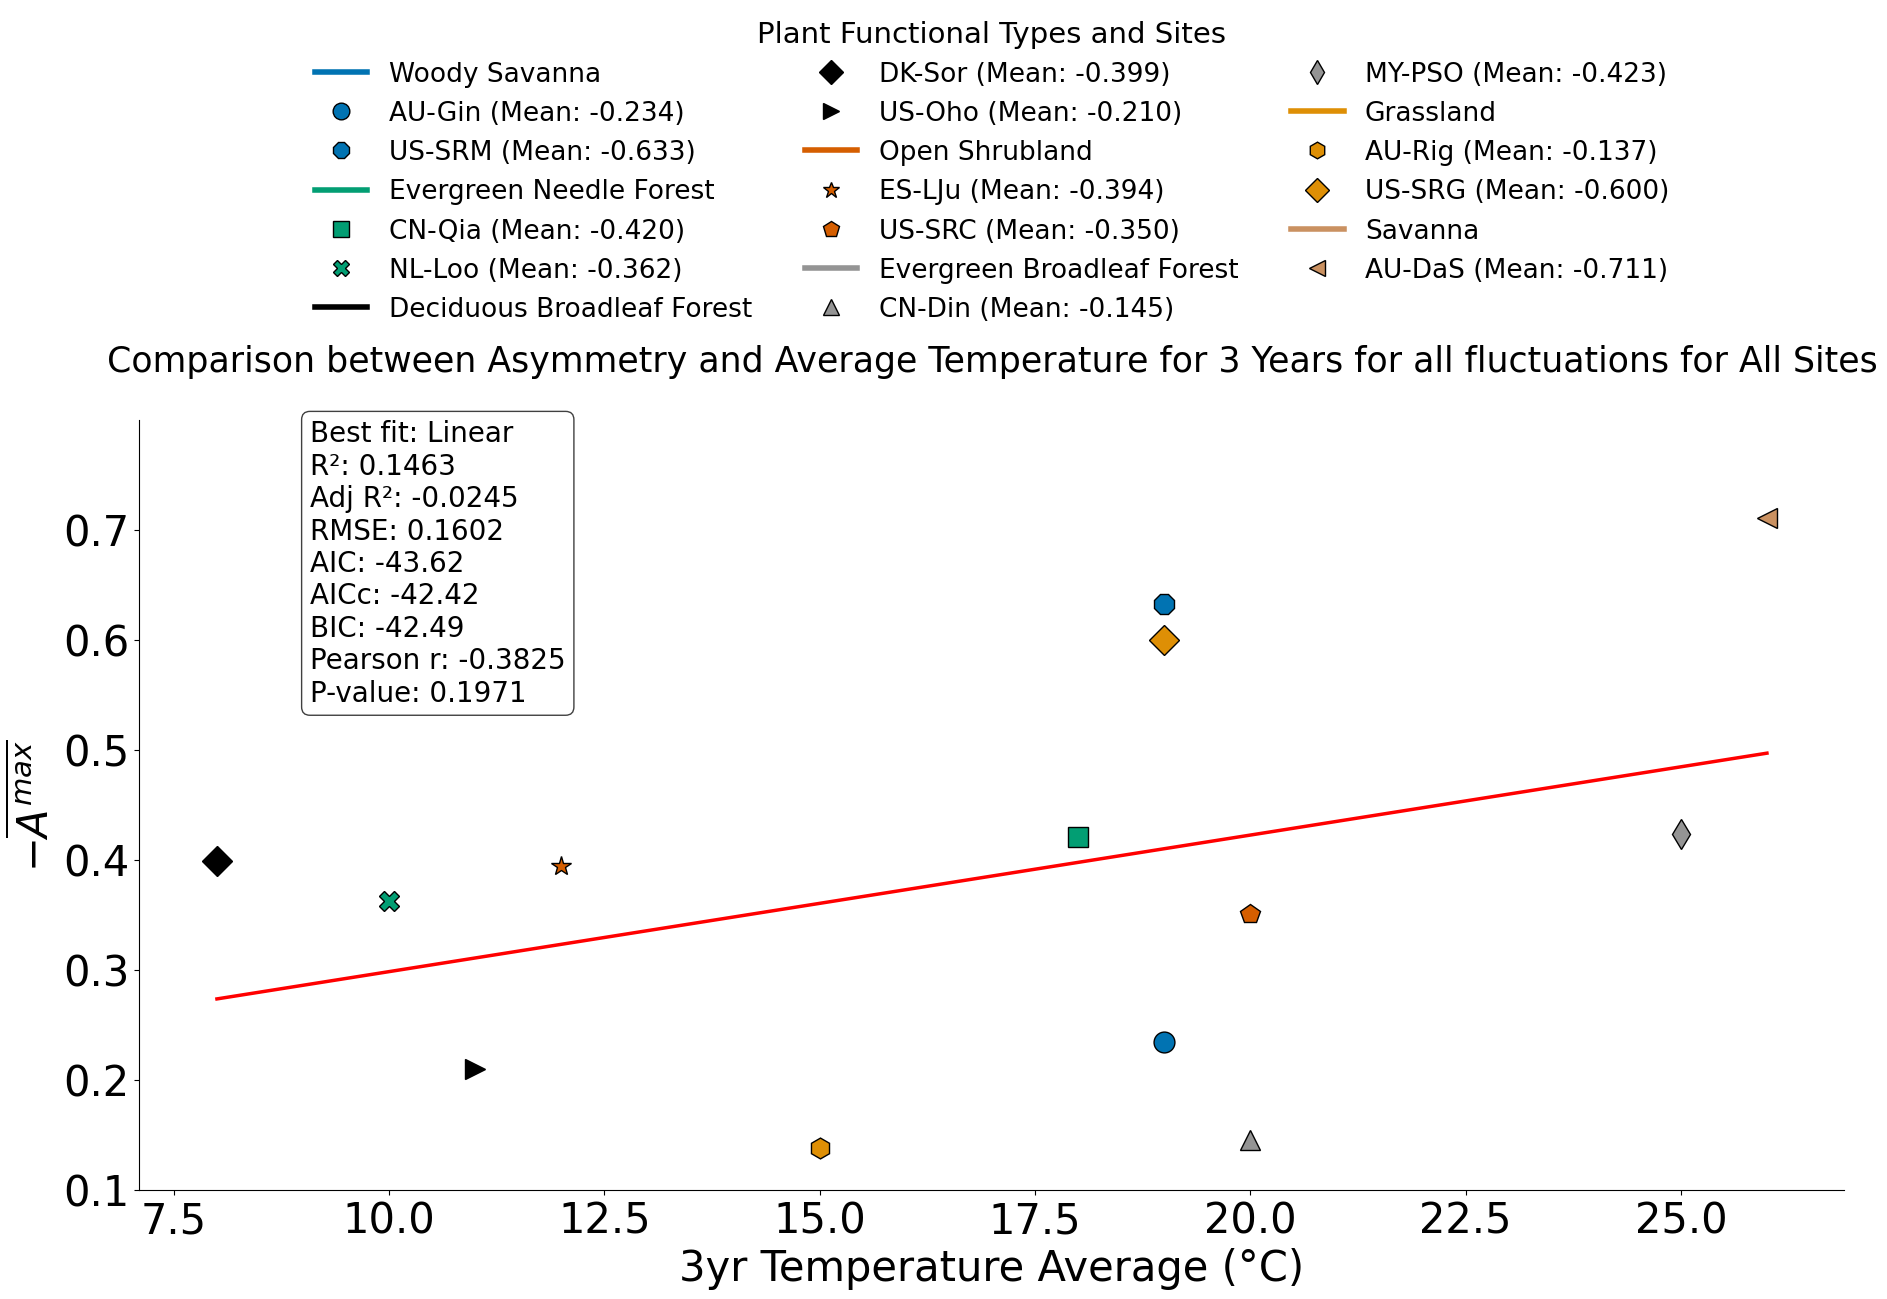

In [27]:
x_data = np.array([v["t_3yr"] for v in t3yr_data.values()], dtype=float)
y_data = np.array([v["meanact"] for v in t3yr_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)  # general Hill only

def fit_models_t3yr(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),  # general Hill (no temp scaling)
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({
                "name": name, "func": func, "params": popt,
                "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                "aic": aic, "aicc": aicc, "bic": bic
            })
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_t3yr(x_data, y_data)
best = fits[0] if len(fits) else None

# Plotting
fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in t3yr_data.items():
    ax_main.plot(d["t_3yr"], d["meanact"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)

ax_main.set_xlabel('3yr Temperature Average (°C)', fontsize=30)
ax_main.set_ylabel('$-\\overline{A^{max}}$', fontsize=30)
ax_main.set_ylim(-0.1, -0.8)
ax_main.set_yticks(-np.arange(0.1, 0.71, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, pos: f"{abs(v):.1f}"))
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title(
    'Comparison between Asymmetry and Average Temperature for 3 Years for all fluctuations for All Sites',
    fontsize=25, pad=35
)

if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'

props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax_main.text(0.1, 1.0, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=props)

pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in t3yr_data:
        pft_groups.setdefault(pft, []).append(site_label)

legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = t3yr_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['meanact']:.3f})",
                                              markerfacecolor=color, markersize=12,
                                              markeredgecolor='black'))

legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()

Figure S19 in the Supplementary information - Relationship between average NEE asymmetry and daily temperature average for all fluctuations
for all sites

In [28]:
# Daily temperature average data
mtch_t_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"/Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/ALLFLUC_TEMP/{file}")  
        allflucpeakst = df.iloc[:, 0]
        t_mtch = df.iloc[0, 2]
        mtch_meanact = np.mean(allflucpeakst)
        mtch_stdact = np.std(allflucpeakst)
        mtch_t_data[label] = {"t_mtch": t_mtch, "mtch_meanact": mtch_meanact, "mtch_stdact": mtch_stdact, "marker": marker, "color": color}

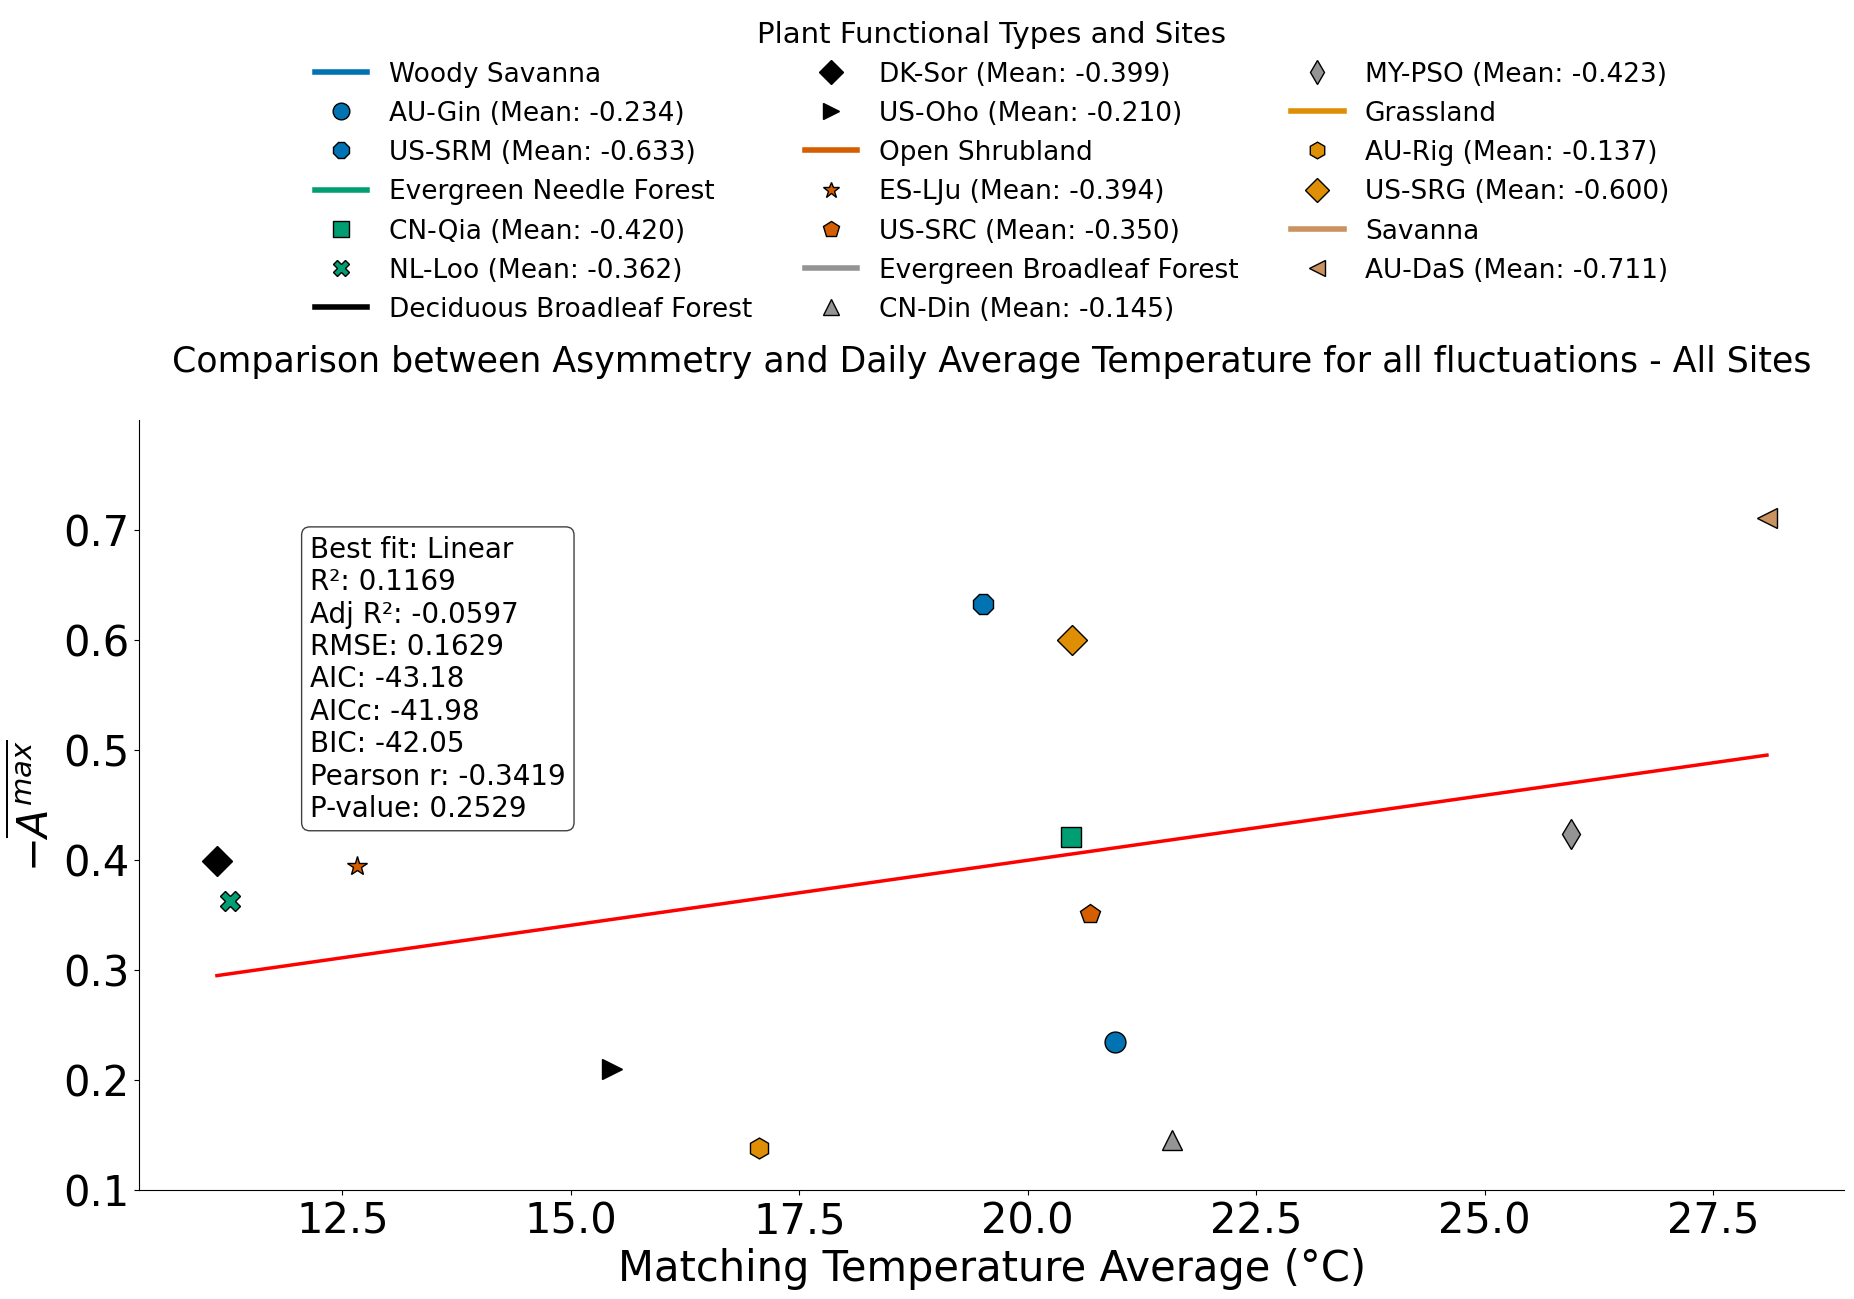

In [29]:
x_data = np.array([v["t_mtch"] for v in mtch_t_data.values()], dtype=float)
y_data = np.array([v["mtch_meanact"] for v in mtch_t_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)  # general Hill only

def fit_models_mtch_t(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),  # general Hill (no temp scaling)
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({
                "name": name, "func": func, "params": popt,
                "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                "aic": aic, "aicc": aicc, "bic": bic
            })
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_mtch_t(x_data, y_data)
best = fits[0] if len(fits) else None

# Plotting
fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in mtch_t_data.items():
    ax_main.plot(d["t_mtch"], d["mtch_meanact"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)
ax_main.set_xlabel('Matching Temperature Average (°C)', fontsize=30)
ax_main.set_ylabel('$-\\overline{A^{max}}$', fontsize=30)
ax_main.set_ylim(-0.1, -0.8)
ax_main.set_yticks(-np.arange(0.1, 0.71, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, pos: f"{abs(v):.1f}"))
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title(
    'Comparison between Asymmetry and Daily Average Temperature for all fluctuations - All Sites',
    fontsize=25, pad=35
)

if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

# Stats box
if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'

props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax_main.text(0.10, 0.85, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=props)

pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in mtch_t_data:
        pft_groups.setdefault(pft, []).append(site_label)
legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = mtch_t_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['mtch_meanact']:.3f})",
                                              markerfacecolor=color, markersize=12,
                                              markeredgecolor='black'))

legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()

Figure S20 in the Supplementary information - Relationship between average NEE asymmetry and 3yr shortwave radiation average for all
fluctuations for all sites

In [30]:
# 3yr shortwave radiation average data
sw_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"/Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/ALLFLUC_SW/{file}")
        sw_3yr = df.iloc[0, 1]   
        allflucpeakssw = df.iloc[:, 0]
        meanacsw = np.mean(allflucpeakssw)
        stdacsw = np.std(allflucpeakssw)
        sw_data[label] = {"sw_3yr": sw_3yr, "meanacsw": meanacsw, "stdacsw": stdacsw, "marker": marker, "color": color}

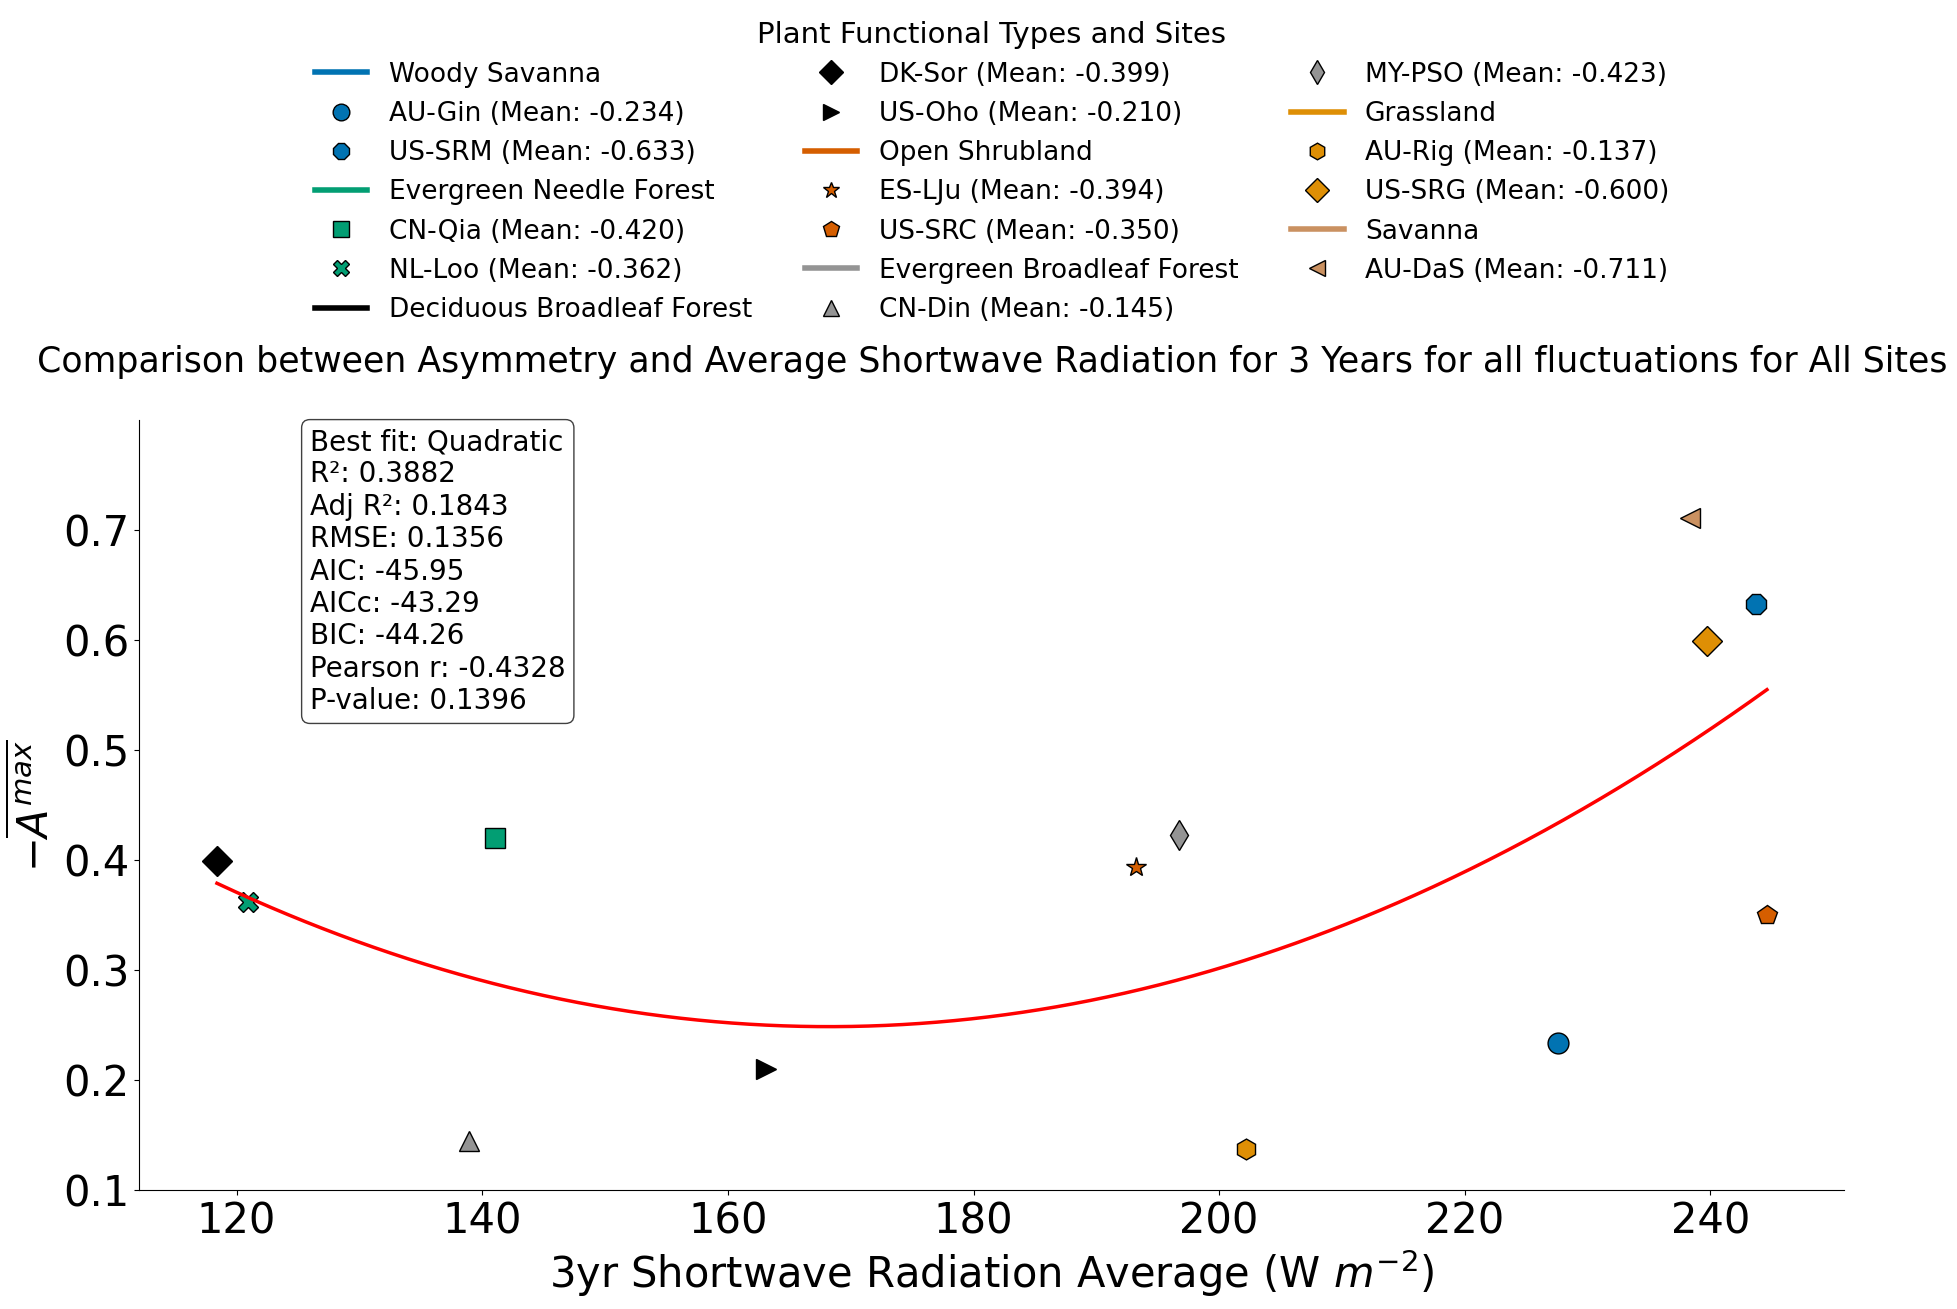

In [31]:
x_data = np.array([v["sw_3yr"] for v in sw_data.values()], dtype=float)
y_data = np.array([v["meanacsw"] for v in sw_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)  # general Hill only

def fit_models_sw(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),  # general Hill (no temp scaling)
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({
                "name": name, "func": func, "params": popt,
                "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                "aic": aic, "aicc": aicc, "bic": bic
            })
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_sw(x_data, y_data)
best = fits[0] if len(fits) else None

# Plotting
fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in sw_data.items():
    ax_main.plot(d["sw_3yr"], d["meanacsw"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)

ax_main.set_xlabel('3yr Shortwave Radiation Average (W $m^{-2}$)', fontsize=30)
ax_main.set_ylabel('$-\\overline{A^{max}}$', fontsize=30)
ax_main.set_ylim(-0.1, -0.8)
ax_main.set_yticks(-np.arange(0.1, 0.71, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, pos: f"{abs(v):.1f}"))
ax_main.set_ylabel('$-\\overline{A^{max}}$', fontsize=30)
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title(
    'Comparison between Asymmetry and Average Shortwave Radiation for 3 Years for all fluctuations for All Sites',
    fontsize=25, pad=35
)

if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'

props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax_main.text(0.10, 0.99, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=props)

pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in sw_data:
        pft_groups.setdefault(pft, []).append(site_label)

legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = sw_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['meanacsw']:.3f})",
                                              markerfacecolor=color, markersize=12,
                                              markeredgecolor='black'))

legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()



Figure S21 in the Supplementary information - Relationship between average NEE asymmetry and daily shortwave radiation average for all
fluctuations for all

In [32]:
# Daily shortwave radiation average data
mtch_sw_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"/Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/ALLFLUC_SW/{file}")  
        allflucpeakssw = df.iloc[:, 0]
        sw_mtch = df.iloc[0, 2]
        mtch_meanacsw = np.mean(allflucpeakssw)
        mtch_stdacsw = np.std(allflucpeakssw)
        mtch_sw_data[label] = {"sw_mtch": sw_mtch, "mtch_meanacsw": mtch_meanacsw, "mtch_stdacsw": mtch_stdacsw, "marker": marker, "color": color}

/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/963223564.py:11: RuntimeWarning: overflow encountered in exp
  def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/963223564.py:28: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)


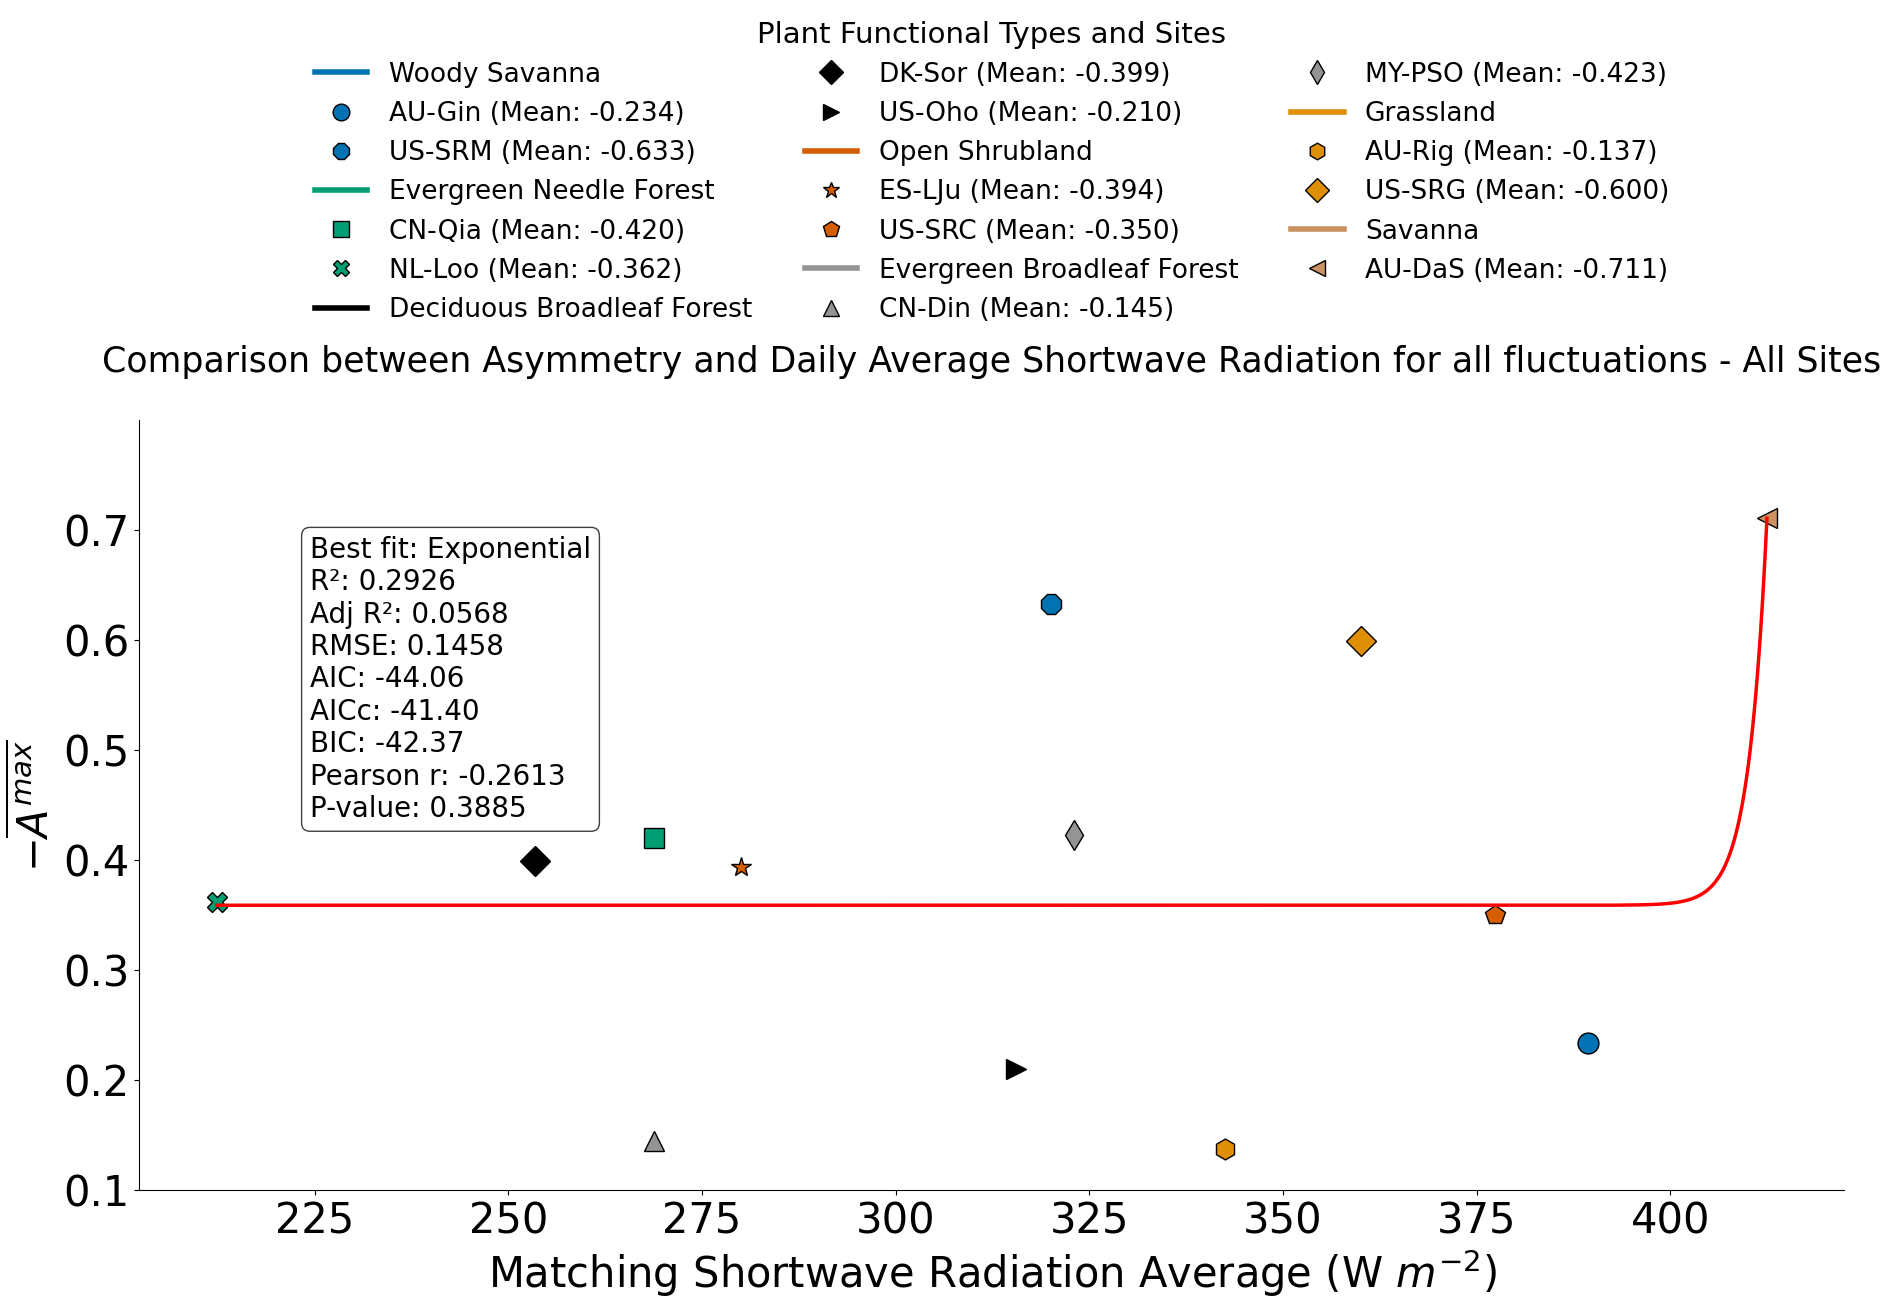

In [33]:
x_data = np.array([v["sw_mtch"] for v in mtch_sw_data.values()], dtype=float)
y_data = np.array([v["mtch_meanacsw"] for v in mtch_sw_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)  # general Hill only

def fit_models_mtch_sw(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),  # general Hill (no temp scaling)
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({
                "name": name, "func": func, "params": popt,
                "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                "aic": aic, "aicc": aicc, "bic": bic
            })
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_mtch_sw(x_data, y_data)
best = fits[0] if len(fits) else None

# Plotting
fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in mtch_sw_data.items():
    ax_main.plot(d["sw_mtch"], d["mtch_meanacsw"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)

ax_main.set_xlabel('Matching Shortwave Radiation Average (W $m^{-2}$)', fontsize=30)
ax_main.set_ylabel('$-\\overline{A^{max}}$', fontsize=30)
ax_main.set_ylim(-0.1, -0.8)
ax_main.set_yticks(-np.arange(0.1, 0.71, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, pos: f"{abs(v):.1f}"))
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title(
    'Comparison between Asymmetry and Daily Average Shortwave Radiation for all fluctuations - All Sites',
    fontsize=25, pad=35
)

if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'

props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax_main.text(0.10, 0.85, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=props)

pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in mtch_sw_data:
        pft_groups.setdefault(pft, []).append(site_label)

legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = mtch_sw_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['mtch_meanacsw']:.3f})",
                                              markerfacecolor=color, markersize=12,
                                              markeredgecolor='black'))

legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()



Figure S22 in the Supplementary information - Relationship between average NEE asymmetry and 3yr soil moisture average for all fluctuations
for all sites

In [34]:
# 3yr soil moisture average data
sm_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"/Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/ALLFLUC_SM/{file}")
        sm_3yr = df.iloc[0, 1]   
        allflucpeakssm = df.iloc[:, 0]
        meanacsm = np.mean(allflucpeakssm)
        stdacsm = np.std(allflucpeakssm)
        sm_data[label] = {"sm_3yr": sm_3yr, "meanacsm": meanacsm, "stdacsm": stdacsm, "marker": marker, "color": color}


/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/3274804345.py:11: RuntimeWarning: overflow encountered in exp
  def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/3274804345.py:28: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)


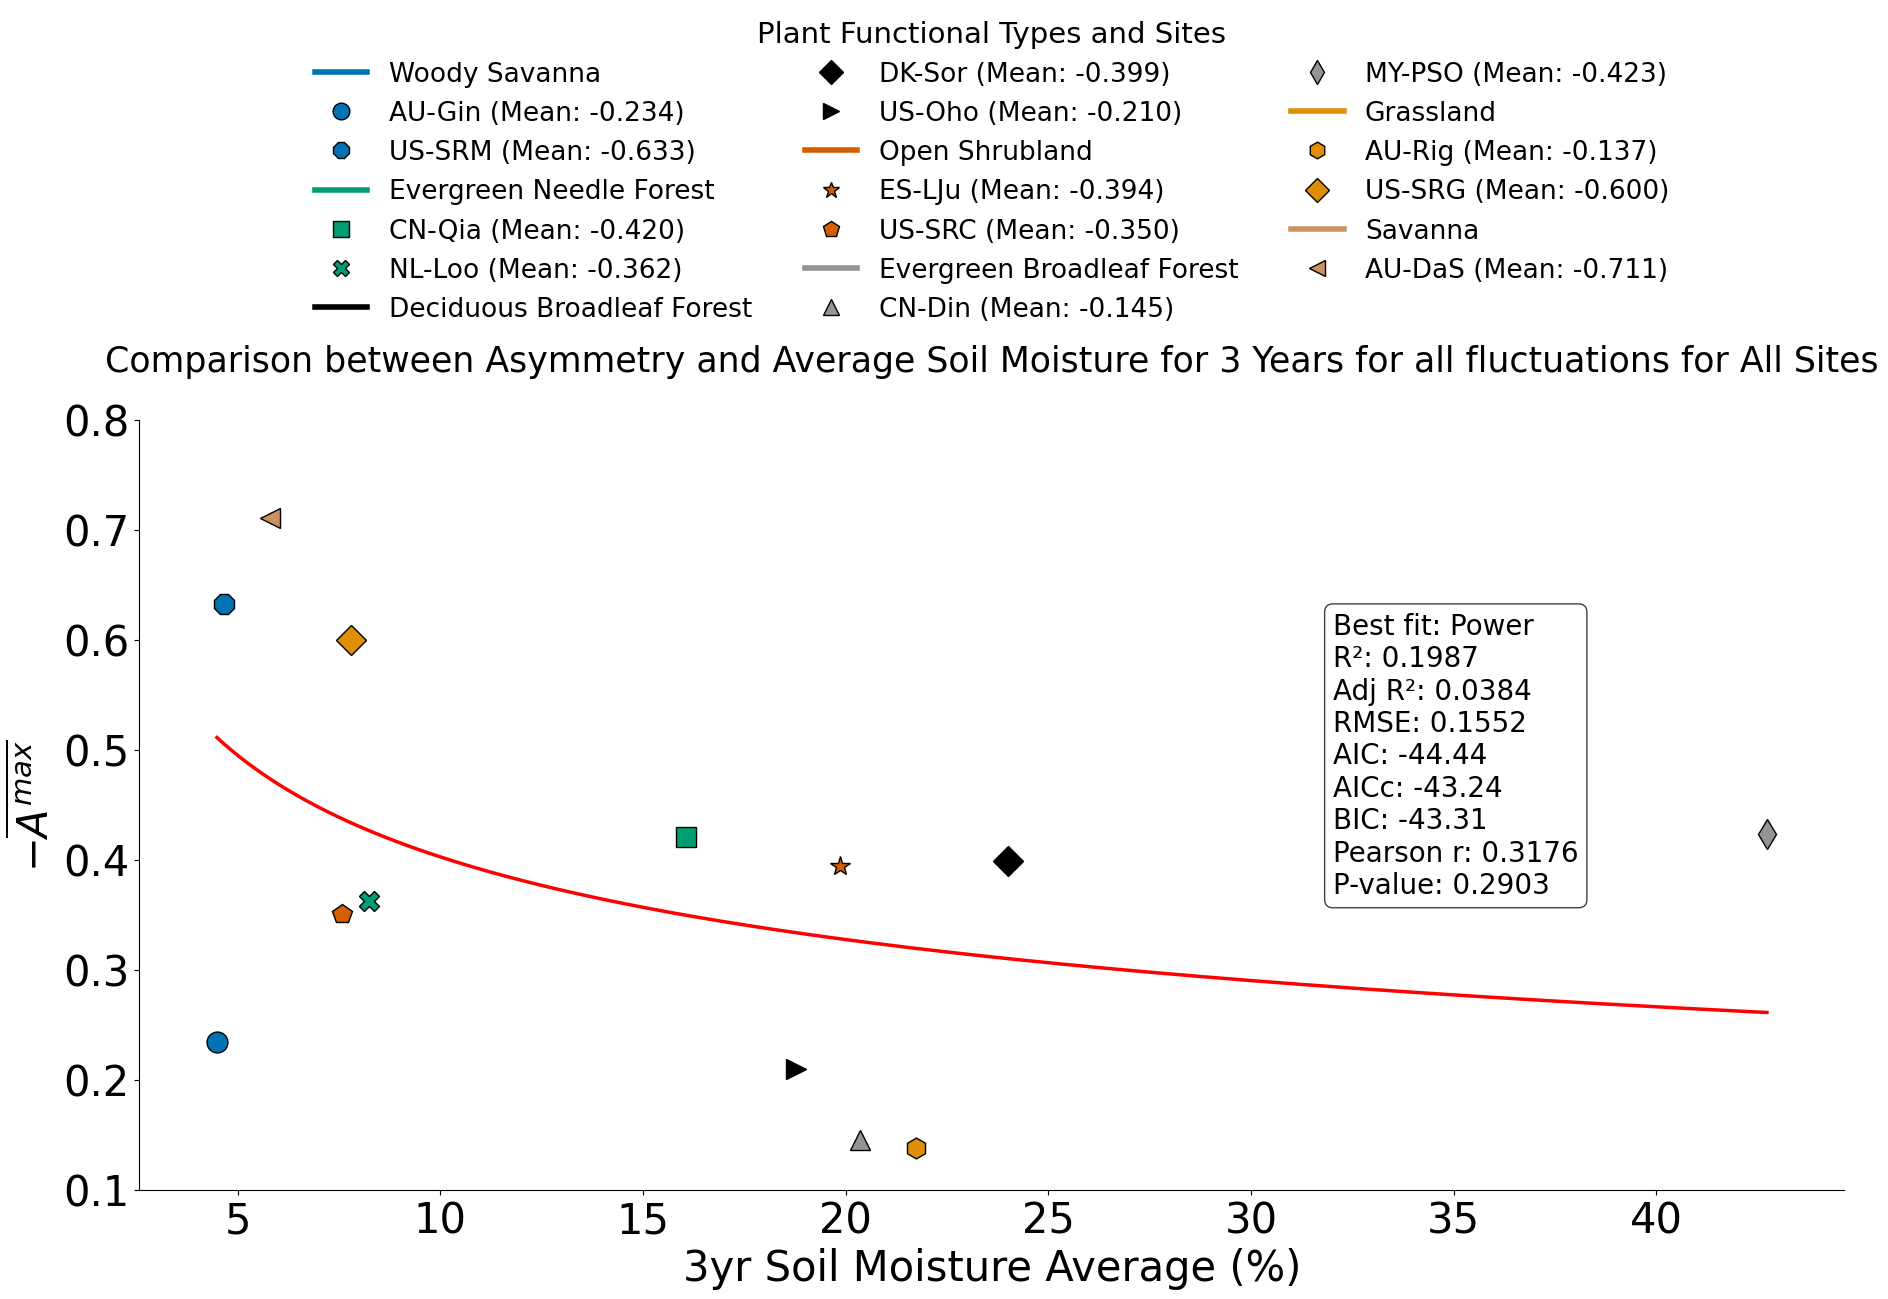

In [35]:
x_data = np.array([v["sm_3yr"] for v in sm_data.values()], dtype=float)
y_data = np.array([v["meanacsm"] for v in sm_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)  # general Hill only

def fit_models_sm(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),  # general Hill (no temp scaling)
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({
                "name": name, "func": func, "params": popt,
                "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                "aic": aic, "aicc": aicc, "bic": bic
            })
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_sm(x_data, y_data)
best = fits[0] if len(fits) else None

# Plotting
fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in sm_data.items():
    ax_main.plot(d["sm_3yr"], d["meanacsm"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)

ax_main.set_xlabel('3yr Soil Moisture Average (%)', fontsize=30)
ax_main.set_ylabel('$-\\overline{A^{max}}$', fontsize=30)
ax_main.set_ylim(-0.1, -0.7)
ax_main.set_yticks(-np.arange(0.1, 0.81, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, pos: f"{abs(v):.1f}"))
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title(
    'Comparison between Asymmetry and Average Soil Moisture for 3 Years for all fluctuations for All Sites',
    fontsize=25, pad=35
)
if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

# Stats box
if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'

props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax_main.text(0.7, 0.75, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=props)

pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in sm_data:
        pft_groups.setdefault(pft, []).append(site_label)

legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = sm_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['meanacsm']:.3f})",
                                              markerfacecolor=color, markersize=12,
                                              markeredgecolor='black'))

legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()

Figure S23 in the Supplementary information - Relationship between average NEE asymmetry and daily soil moisture average for all fluctuations
for all sites

In [36]:
# Daily soil moisture average data
mtch_sm_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"/Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/ALLFLUC_SM/{file}")
        sm_mtch = df.iloc[0, 2]
        allflucpeakssm_mtch = df.iloc[:, 0]
        meanacsm_mtch = np.mean(allflucpeakssm_mtch)
        stdacsm_mtch = np.std(allflucpeakssm_mtch)
        mtch_sm_data[label] = {"sm_mtch": sm_mtch, "meanacsm_mtch": meanacsm_mtch, "stdacsm_mtch": stdacsm_mtch, "marker": marker, "color": color}

/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/400659591.py:28: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)


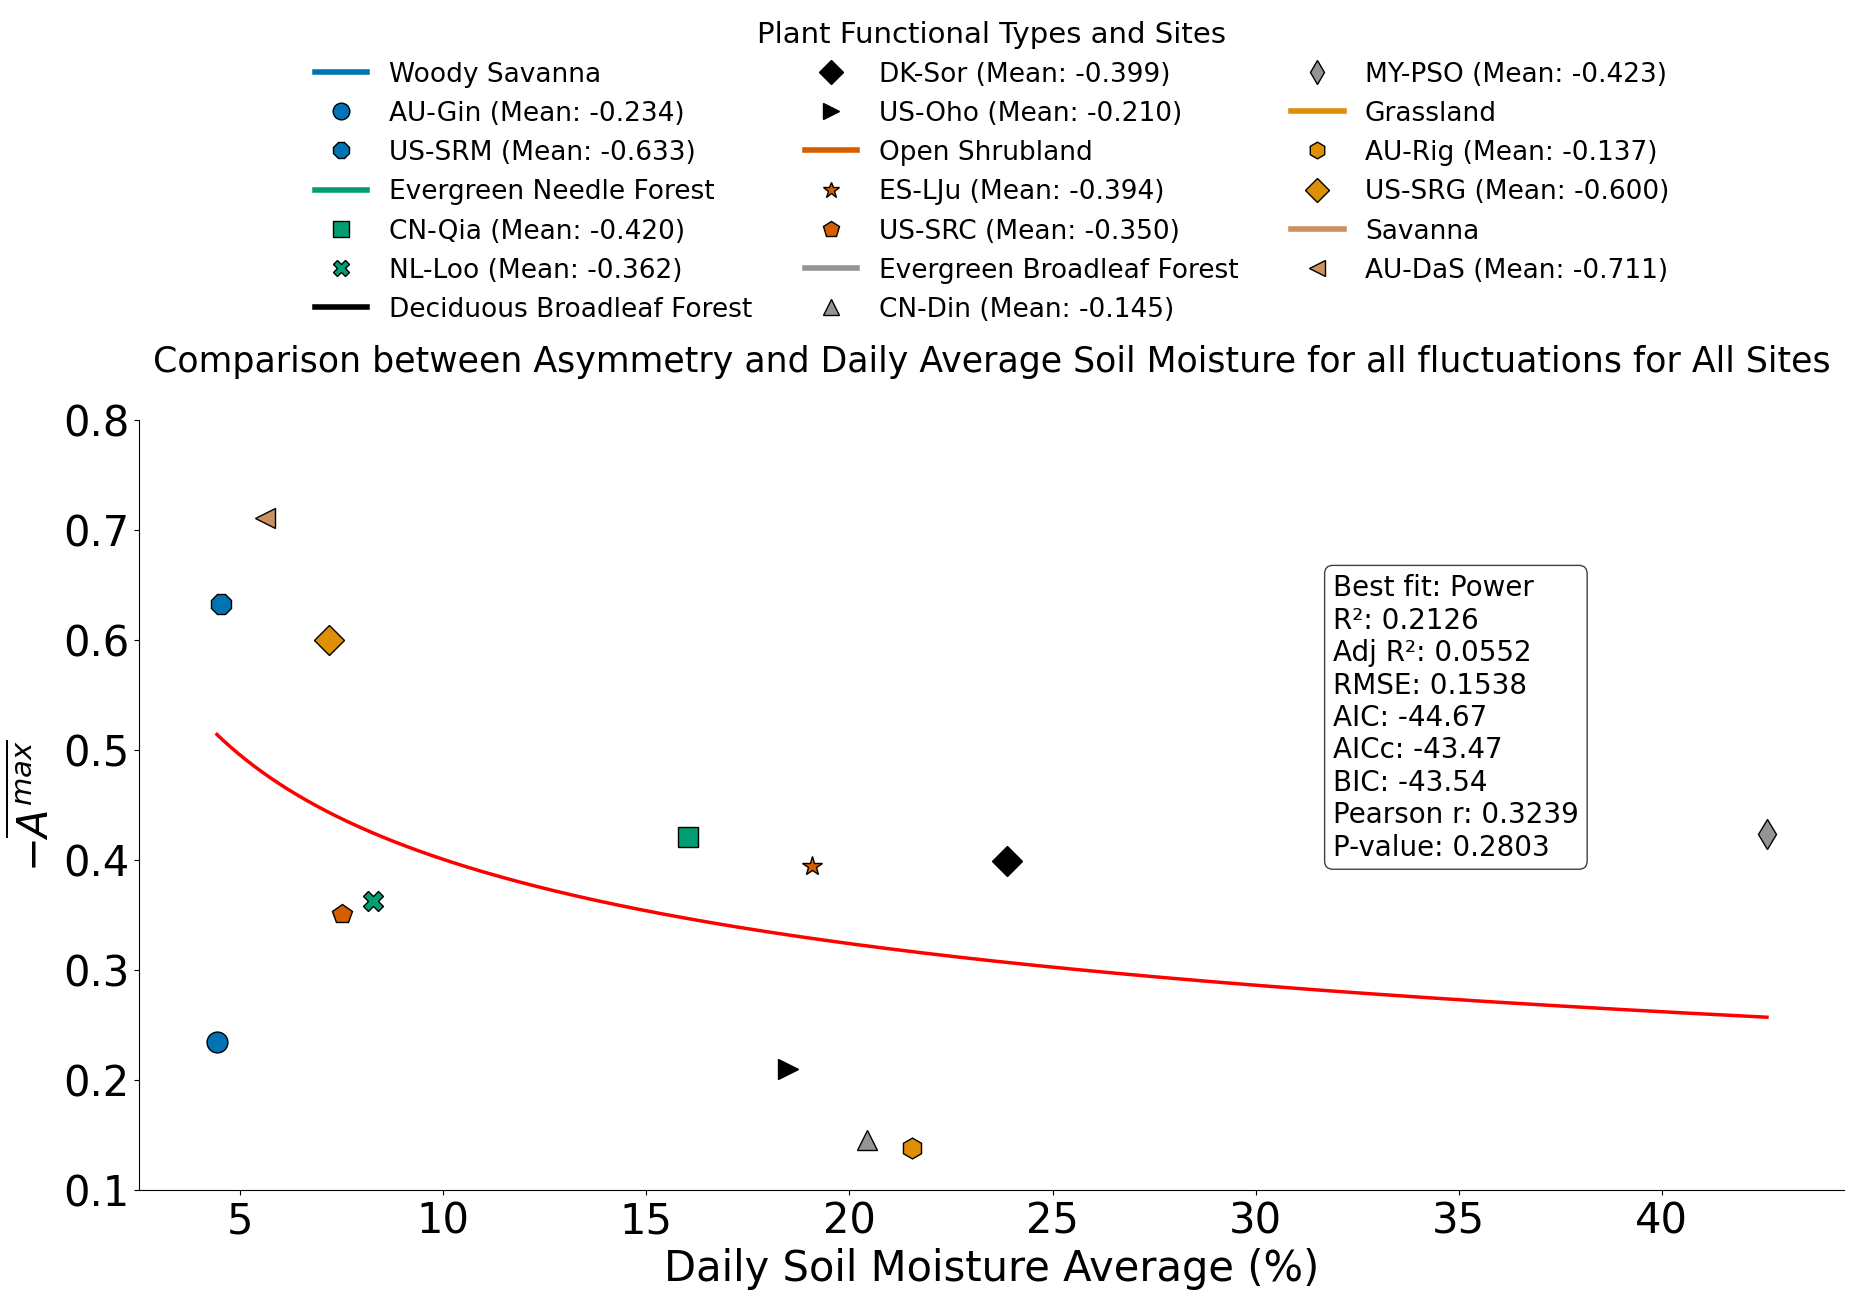

In [37]:
x_data = np.array([v["sm_mtch"] for v in mtch_sm_data.values()], dtype=float)
y_data = np.array([v["meanacsm_mtch"] for v in mtch_sm_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)  # general Hill only

def fit_models_mtch_sm(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),  # general Hill (no temp scaling)
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({
                "name": name, "func": func, "params": popt,
                "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                "aic": aic, "aicc": aicc, "bic": bic
            })
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_mtch_sm(x_data, y_data)
best = fits[0] if len(fits) else None

# Plotting
fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in mtch_sm_data.items():
    ax_main.plot(d["sm_mtch"], d["meanacsm_mtch"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)
ax_main.set_xlabel('Daily Soil Moisture Average (%)', fontsize=30)
ax_main.set_ylabel('$-\\overline{A^{max}}$', fontsize=30)
ax_main.set_ylim(-0.1, -0.7)
ax_main.set_yticks(-np.arange(0.1, 0.81, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, pos: f"{abs(v):.1f}"))
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title(
    'Comparison between Asymmetry and Daily Average Soil Moisture for all fluctuations for All Sites',
    fontsize=25, pad=35
)

if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'

props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax_main.text(0.7, 0.8, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=props)

pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in mtch_sm_data:
        pft_groups.setdefault(pft, []).append(site_label)

legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = mtch_sm_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['meanacsm_mtch']:.3f})",
                                              markerfacecolor=color, markersize=12,
                                              markeredgecolor='black'))

legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()

Figure S24 in the Supplementary information - Relationship between average NEE asymmetry and 3yr precipitation average for all fluctuations
for all sites

In [38]:
# 3yr precipitation average data
p_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"/Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/ALLFLUC_P/{file}")
        p_3yr = df.iloc[0, 1]   
        allflucpeaksp = df.iloc[:, 0]
        meanacp = np.mean(allflucpeaksp)
        stdacp = np.std(allflucpeaksp)
        p_data[label] = {"p_3yr": p_3yr, "meanacp": meanacp, "stdacp": stdacp, "marker": marker, "color": color}

/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/3689909228.py:28: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/3689909228.py:28: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)


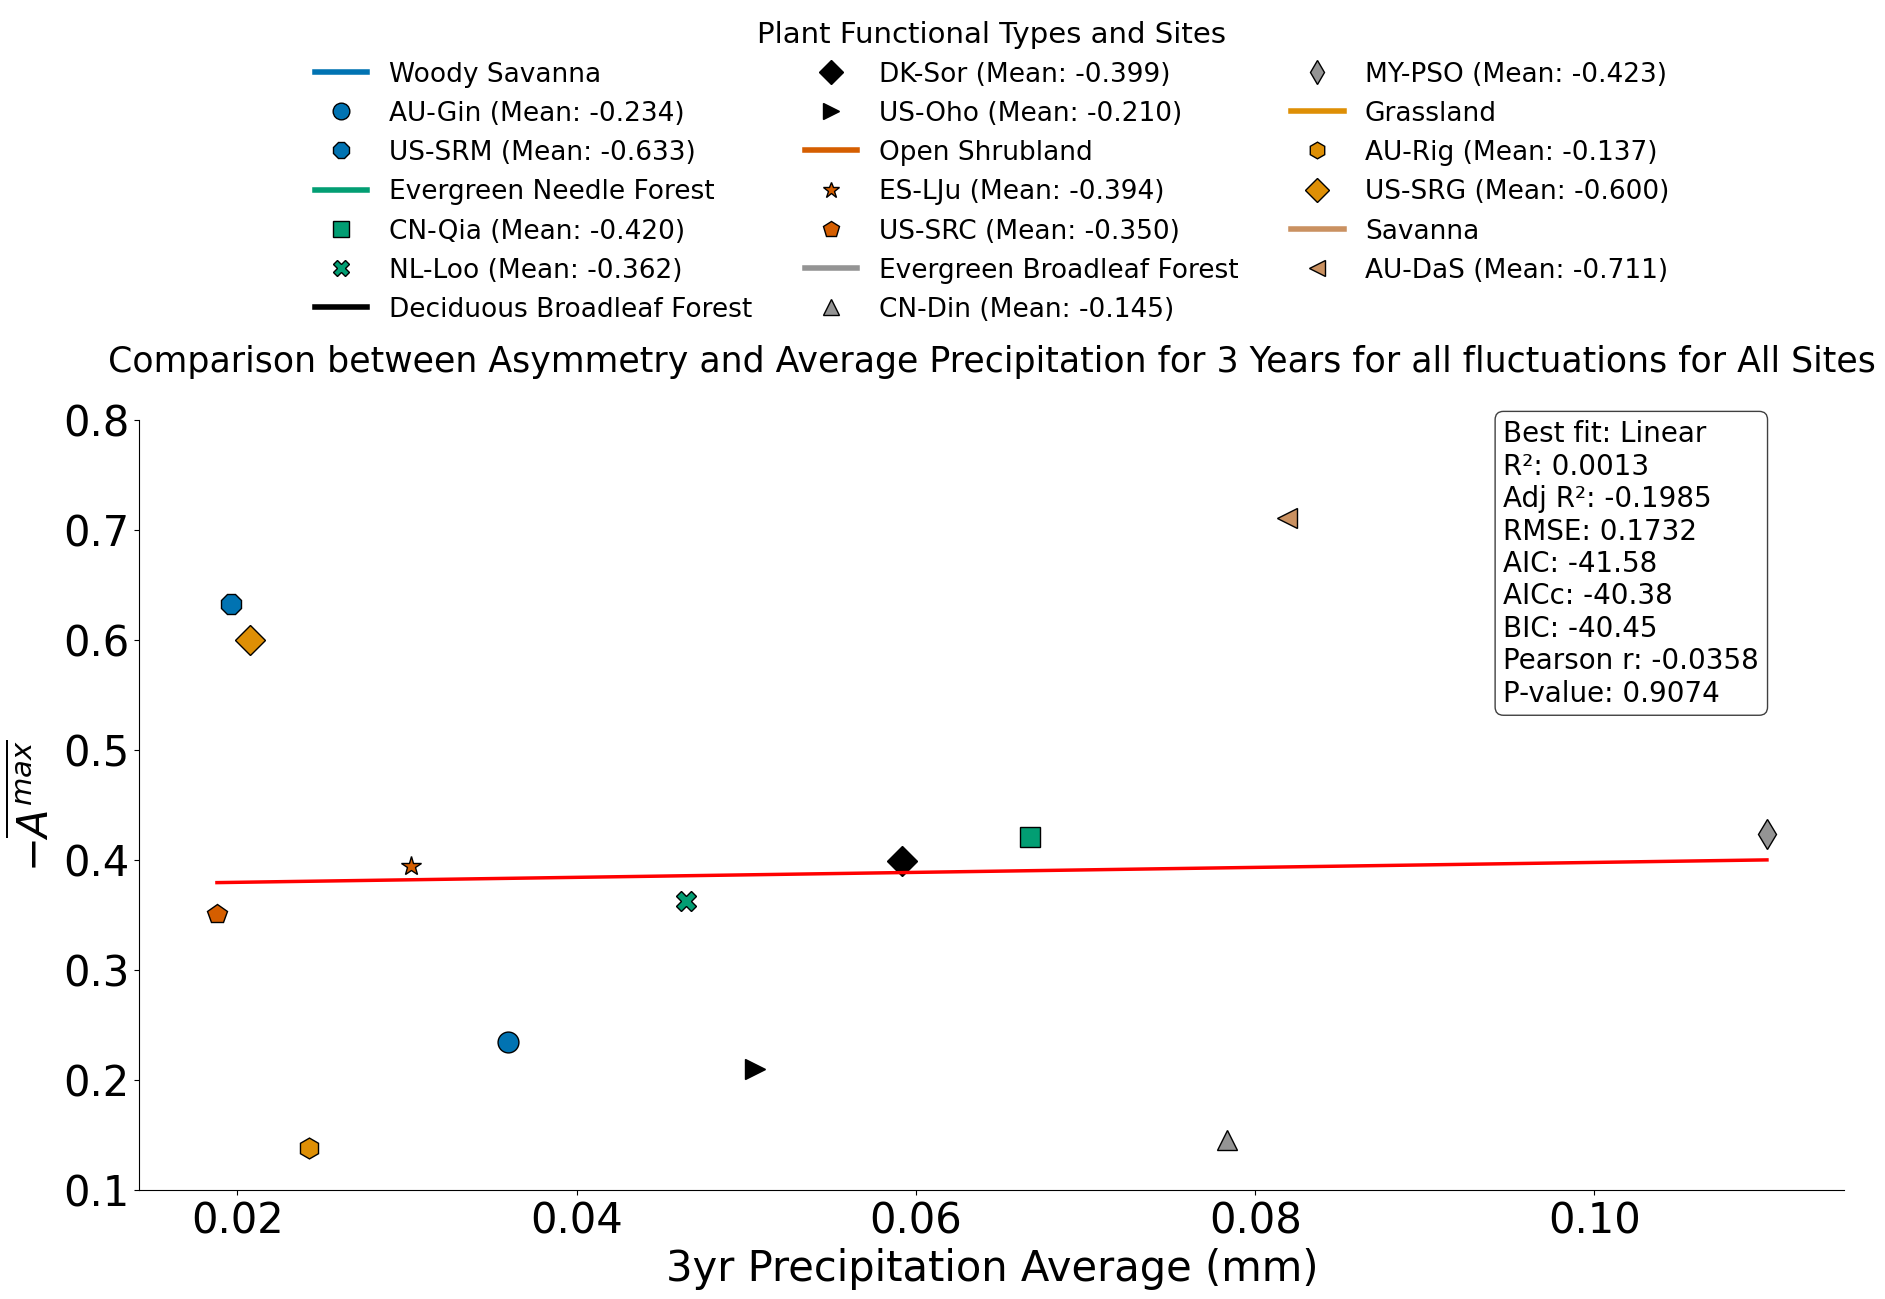

In [39]:
x_data = np.array([v["p_3yr"] for v in p_data.values()], dtype=float)
y_data = np.array([v["meanacp"] for v in p_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)  # general Hill only

def fit_models_p(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),  # general Hill (no temp scaling)
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({
                "name": name, "func": func, "params": popt,
                "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                "aic": aic, "aicc": aicc, "bic": bic
            })
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_p(x_data, y_data)
best = fits[0] if len(fits) else None

# Plotting
fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in p_data.items():
    ax_main.plot(d["p_3yr"], d["meanacp"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)
                 
ax_main.set_xlabel('3yr Precipitation Average (mm)', fontsize=30)
ax_main.set_ylabel('$-\\overline{A^{max}}$', fontsize=30)
ax_main.set_ylim(-0.1, -0.7)
ax_main.set_yticks(-np.arange(0.1, 0.81, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, pos: f"{abs(v):.1f}"))
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title(
    'Comparison between Asymmetry and Average Precipitation for 3 Years for all fluctuations for All Sites',
    fontsize=25, pad=35
)

if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')
if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'

props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax_main.text(0.8, 1.0, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=props)

pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in p_data:
        pft_groups.setdefault(pft, []).append(site_label)

legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = p_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['meanacp']:.3f})",
                                              markerfacecolor=color, markersize=12,
                                              markeredgecolor='black'))

legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()

Figure S25 in the Supplementary information - Relationship between average NEE asymmetry and daily precipitation average for all fluctuations
for all sites

In [40]:
# Daily precipitation average data
mtch_p_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"/Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/ALLFLUC_P/{file}")  
        allflucpeaksp = df.iloc[:, 0]
        p_mtch = df.iloc[0, 2]
        mtch_meanacp = np.mean(allflucpeaksp)
        mtch_stdacp = np.std(allflucpeaksp)
        mtch_p_data[label] = {"p_mtch": p_mtch, "mtch_meanacp": mtch_meanacp, "mtch_stdacp": mtch_stdacp, "marker": marker, "color": color}

/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/4164775917.py:28: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)


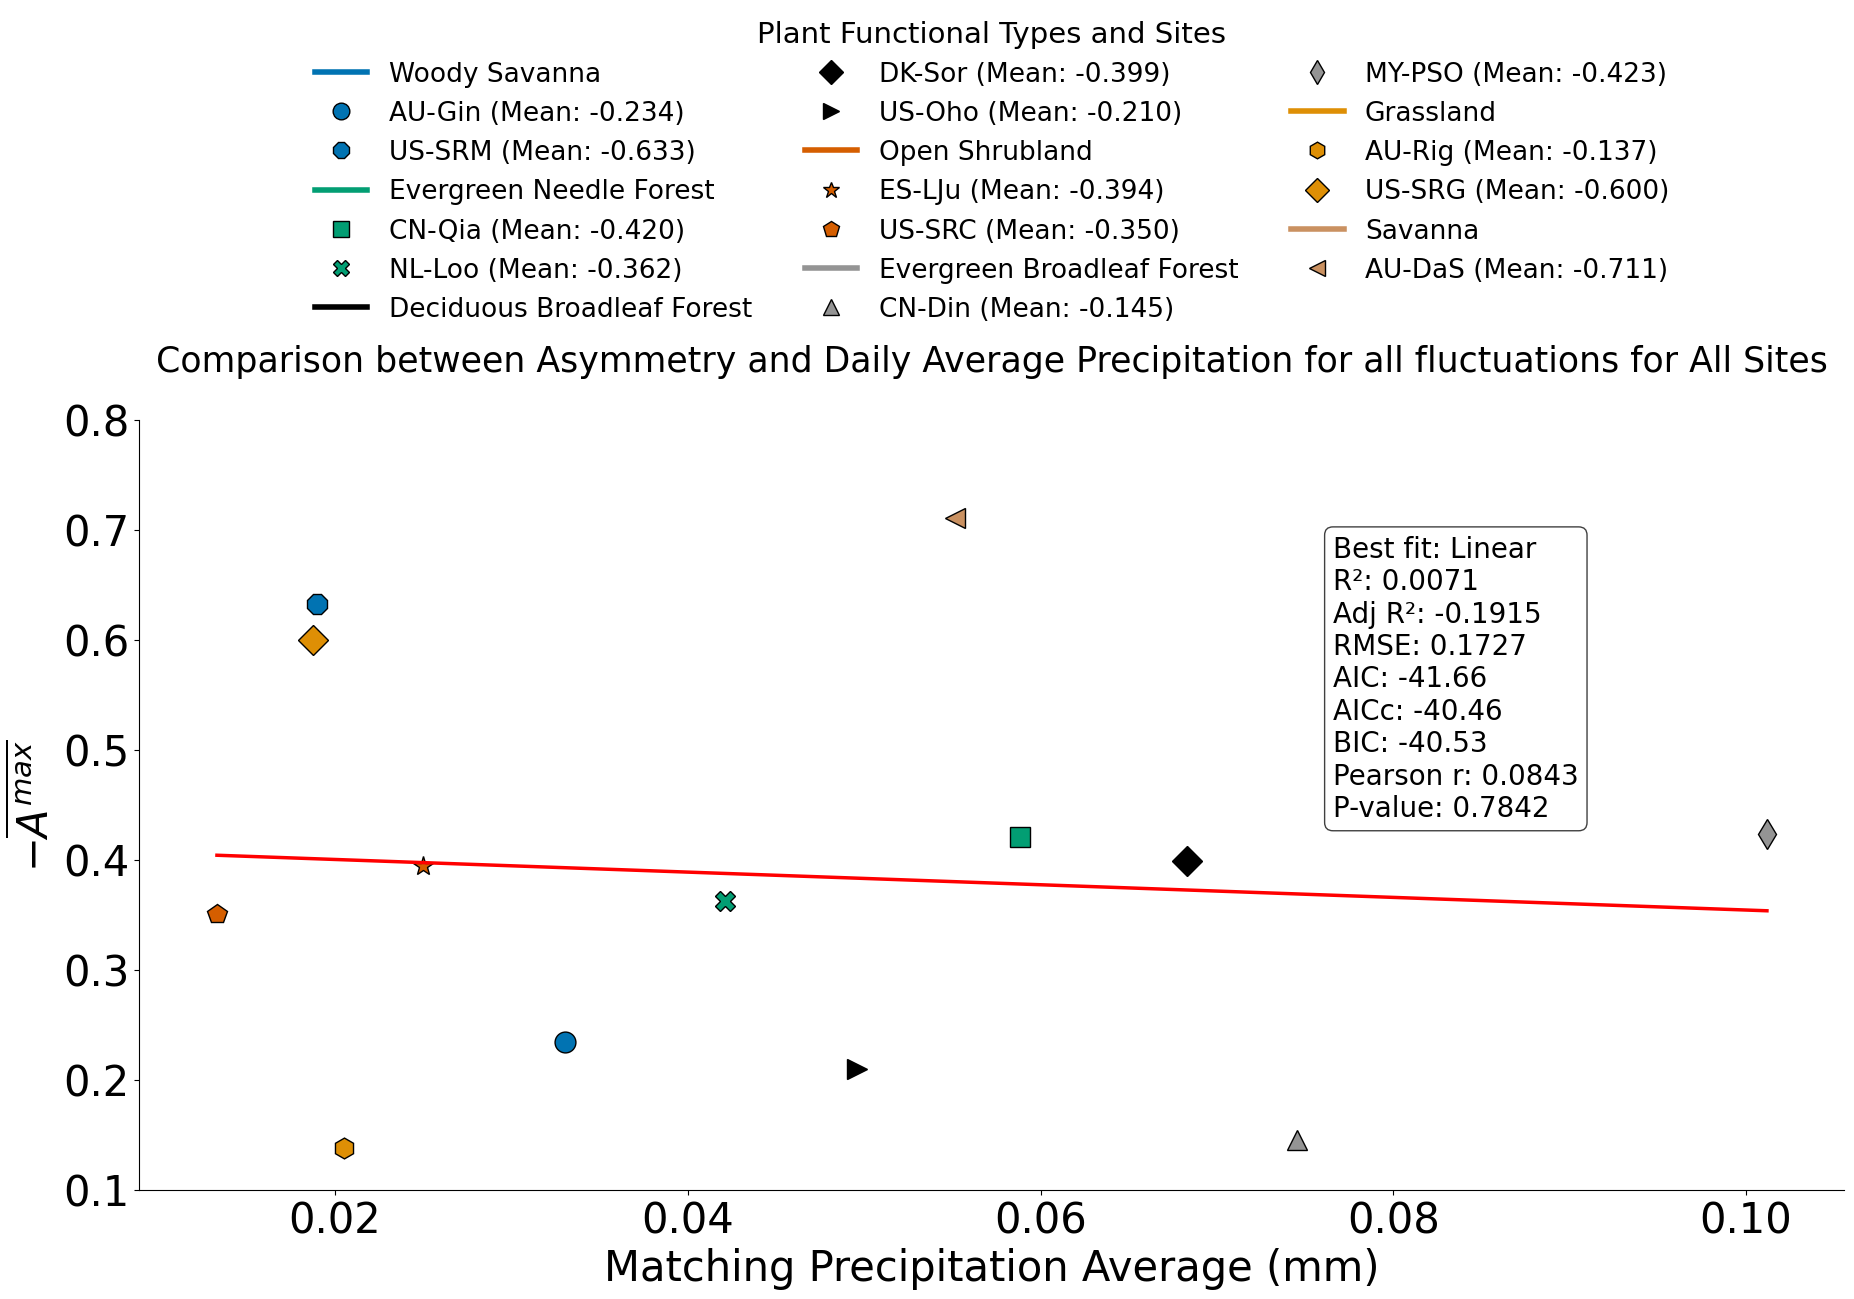

In [41]:
x_data = np.array([v["p_mtch"] for v in mtch_p_data.values()], dtype=float)
y_data = np.array([v["mtch_meanacp"] for v in mtch_p_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)  # general Hill only

def fit_models_mtch_p(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),  # general Hill (no temp scaling)
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({
                "name": name, "func": func, "params": popt,
                "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                "aic": aic, "aicc": aicc, "bic": bic
            })
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_mtch_p(x_data, y_data)
best = fits[0] if len(fits) else None

# Plotting
fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in mtch_p_data.items():
    ax_main.plot(d["p_mtch"], d["mtch_meanacp"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)

ax_main.set_xlabel('Matching Precipitation Average (mm)', fontsize=30)
ax_main.set_ylabel('$-\\overline{A^{max}}$', fontsize=30)
ax_main.set_ylim(-0.1, -0.7)
ax_main.set_yticks(-np.arange(0.1, 0.81, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, pos: f"{abs(v):.1f}"))
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title(
    'Comparison between Asymmetry and Daily Average Precipitation for all fluctuations for All Sites',
    fontsize=25, pad=35
)

if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'

props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax_main.text(0.7, 0.85, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=props)

pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in mtch_p_data:
        pft_groups.setdefault(pft, []).append(site_label)

legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = mtch_p_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['mtch_meanacp']:.3f})",
                                              markerfacecolor=color, markersize=12,
                                              markeredgecolor='black'))

legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()

Figure S26 in the Supplementary information - Relationship between average NEE asymmetry and 3yr vapor pressure deficit average for all
fluctuations for all sites

In [42]:
# 3yr vapor pressure deficit average data
vpd_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"/Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/ALLFLUC_VPD/{file}")
        vpd_3yr = df.iloc[0, 1]   
        allflucpeaksvpd = df.iloc[:, 0]
        meanacvpd = np.mean(allflucpeaksvpd)
        stdacvpd = np.std(allflucpeaksvpd)
        vpd_data[label] = {"vpd_3yr": vpd_3yr, "meanacvpd": meanacvpd, "stdacvpd": stdacvpd, "marker": marker, "color": color}

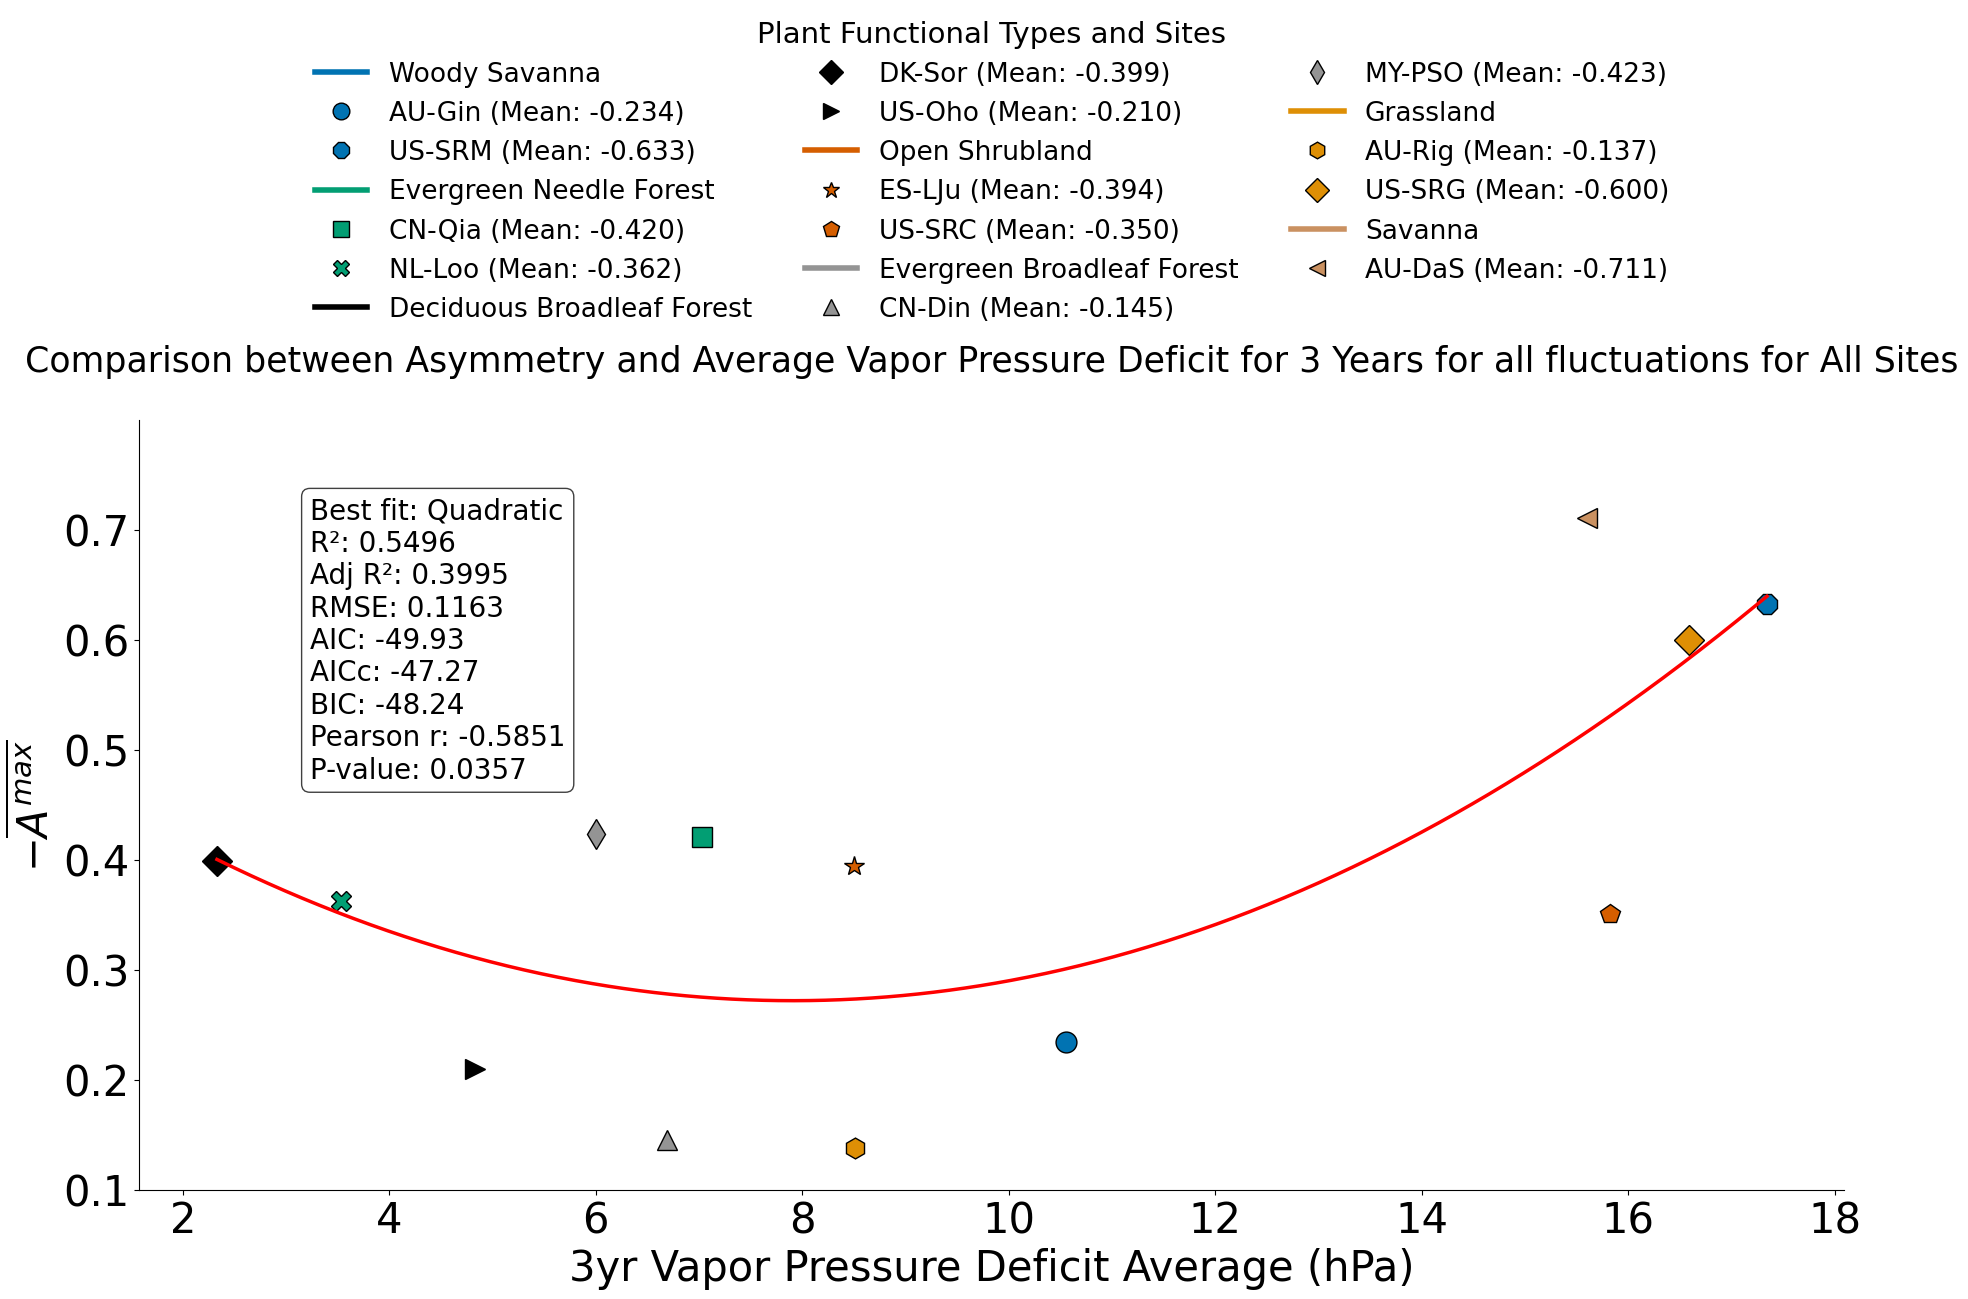

In [43]:
x_data = np.array([v["vpd_3yr"] for v in vpd_data.values()], dtype=float)
y_data = np.array([v["meanacvpd"] for v in vpd_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)  # general Hill only

def fit_models_vpd(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),  # general Hill (no temp scaling)
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({
                "name": name, "func": func, "params": popt,
                "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                "aic": aic, "aicc": aicc, "bic": bic
            })
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

# Getting best fit model

candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_vpd(x_data, y_data)
best = fits[0] if len(fits) else None

# Plotting
fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in vpd_data.items():
    ax_main.plot(d["vpd_3yr"], d["meanacvpd"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)

ax_main.set_xlabel('3yr Vapor Pressure Deficit Average (hPa)', fontsize=30)
ax_main.set_ylabel('$-\\overline{A^{max}}$', fontsize=30)
ax_main.set_ylim(-0.1, -0.8)
ax_main.set_yticks(-np.arange(0.1, 0.71, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, pos: f"{abs(v):.1f}"))
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title(
    'Comparison between Asymmetry and Average Vapor Pressure Deficit for 3 Years for all fluctuations for All Sites',
    fontsize=25, pad=35
)

if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'

props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax_main.text(0.10, 0.90, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=props)

pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in vpd_data:
        pft_groups.setdefault(pft, []).append(site_label)

legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = vpd_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['meanacvpd']:.3f})",
                                              markerfacecolor=color, markersize=12,
                                              markeredgecolor='black'))

legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()



Figure S27 in the Supplementary information - Relationship between average NEE asymmetry and 3yr Mean Annual Temperature: 3yr Mean
Annual Precipitation for all fluctuations for all sites

In [44]:
# 3yr Mean Annual Temperature: 3yr Mean Annual Precipitation data
tp3yr_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"/Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/ALLFLUC_TEMP_PREC/{file}")
        tp_3yr = df.iloc[0, 5]   
        allflucpeakstp3yr = df.iloc[:, 0]
        meanactp3yr = np.mean(allflucpeakstp3yr)
        stdactp3yr = np.std(allflucpeakstp3yr)
        tp3yr_data[label] = {"tp_3yr": tp_3yr, "meanactp3yr": meanactp3yr, "stdactp3yr": stdactp3yr, "marker": marker, "color": color}

/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/496992109.py:10: RuntimeWarning: invalid value encountered in log
  def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/496992109.py:28: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)


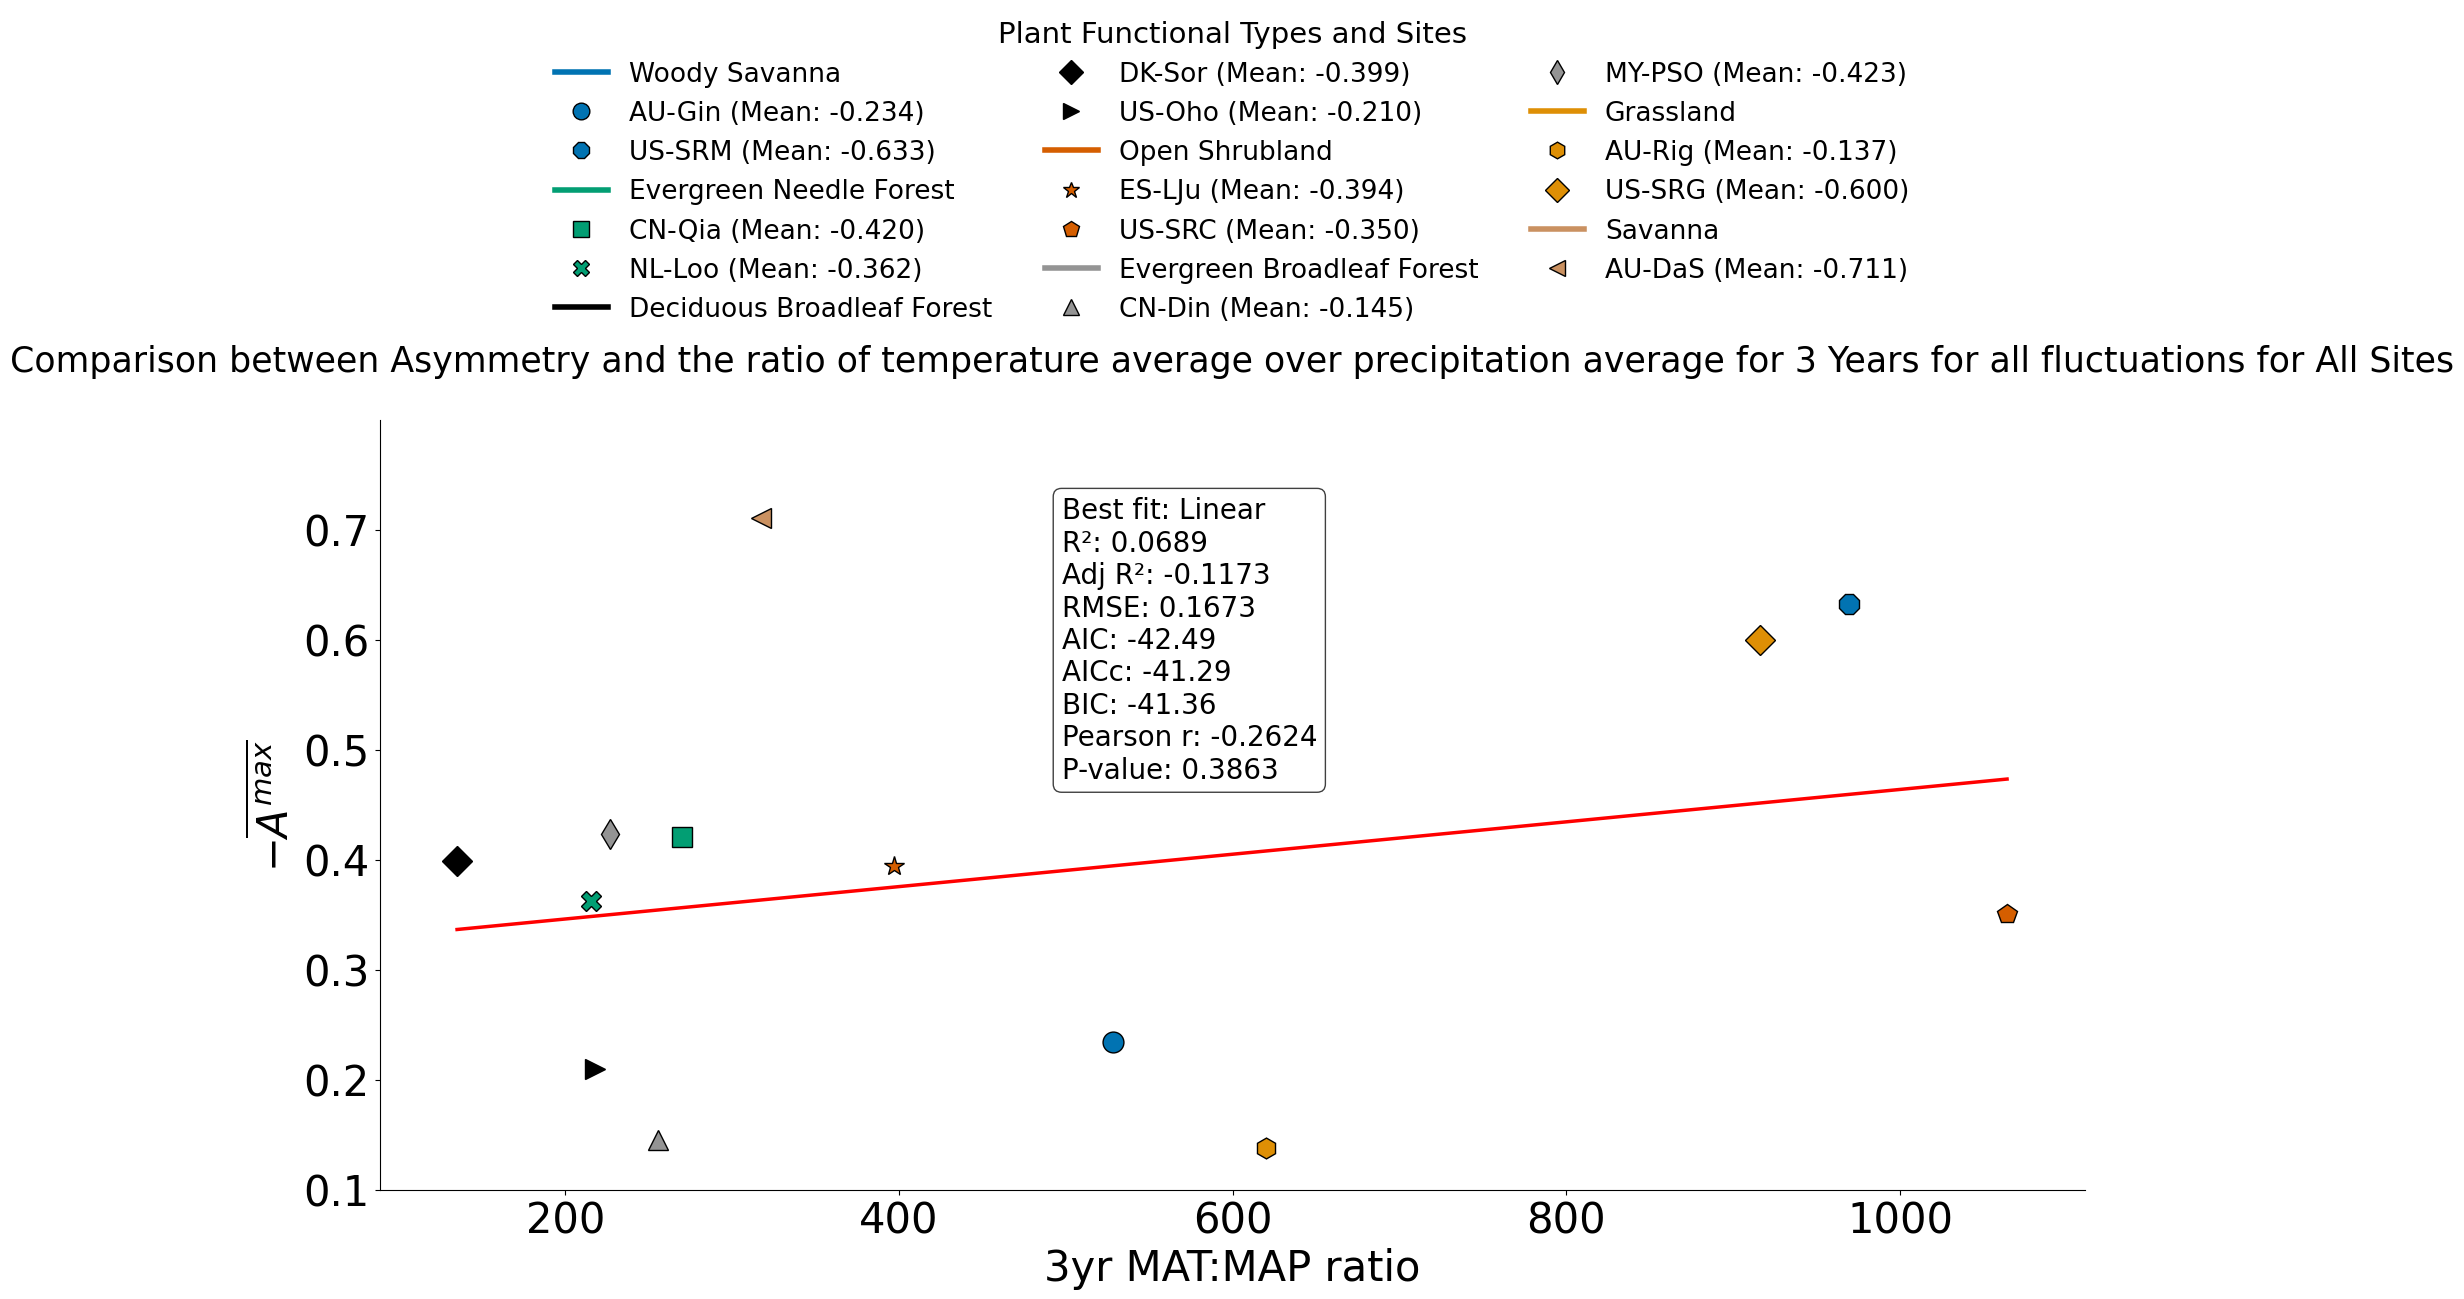

In [45]:
x_data = np.array([v["tp_3yr"] for v in tp3yr_data.values()], dtype=float)
y_data = np.array([v["meanactp3yr"] for v in tp3yr_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)  # general Hill only

def fit_models_tp3yr(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),  # general Hill (no temp scaling)
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({
                "name": name, "func": func, "params": popt,
                "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                "aic": aic, "aicc": aicc, "bic": bic
            })
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_tp3yr(x_data, y_data)
best = fits[0] if len(fits) else None

# Plotting
fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in tp3yr_data.items():
    ax_main.plot(d["tp_3yr"], d["meanactp3yr"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)

ax_main.set_xlabel('3yr MAT:MAP ratio', fontsize=30)
ax_main.set_ylabel('$-\\overline{A^{max}}$', fontsize=30)
ax_main.set_ylim(-0.1, -0.8)
ax_main.set_yticks(-np.arange(0.1, 0.71, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, pos: f"{abs(v):.1f}"))
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title(
    'Comparison between Asymmetry and the ratio of temperature average over precipitation average for 3 Years for all fluctuations for All Sites',
    fontsize=25, pad=35
)

if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'

props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax_main.text(0.4, 0.90, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=props)

pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in tp3yr_data:
        pft_groups.setdefault(pft, []).append(site_label)

legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = tp3yr_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['meanactp3yr']:.3f})",
                                              markerfacecolor=color, markersize=12,
                                              markeredgecolor='black'))

legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()



Figure S28 in the Supplementary information - Relationship between average NEE asymmetry and daily Mean Annual Temperature: daily Mean
Annual Precipitation for all fluctuations for all sites

In [46]:
# daily Mean Annual Temperature: daily Mean Annual Precipitation data
tpmtch_data = {}

for file, marker in zip(file_names, markers):
    site_val = file[:5]
    
    if site_val in site_labels:
        pft, label = site_labels[site_val]
        color = pft_colors[pft]
        df = pd.read_excel(f"//Users/nikhi/Desktop/PROJ1LIT/SI_EXCELFILES/ALLFLUC_TEMP_PREC/{file}")
        tp_mtch = df.iloc[0, 6]   
        allflucpeakstpmtch = df.iloc[:, 0]
        meanactpmtch = np.mean(allflucpeakstpmtch)
        stdactpmtch = np.std(allflucpeakstpmtch)
        tpmtch_data[label] = {"tp_mtch": tp_mtch, "meanactpmtch": meanactpmtch, "stdactpmtch": stdactpmtch, "marker": marker, "color": color}

/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/3208900563.py:10: RuntimeWarning: invalid value encountered in log
  def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/3208900563.py:11: RuntimeWarning: overflow encountered in exp
  def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/3208900563.py:28: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
/var/folders/tc/krjl03bn2cgbs5z5128vc9y80000gn/T/ipykernel_3739/3208900563.py:28: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)


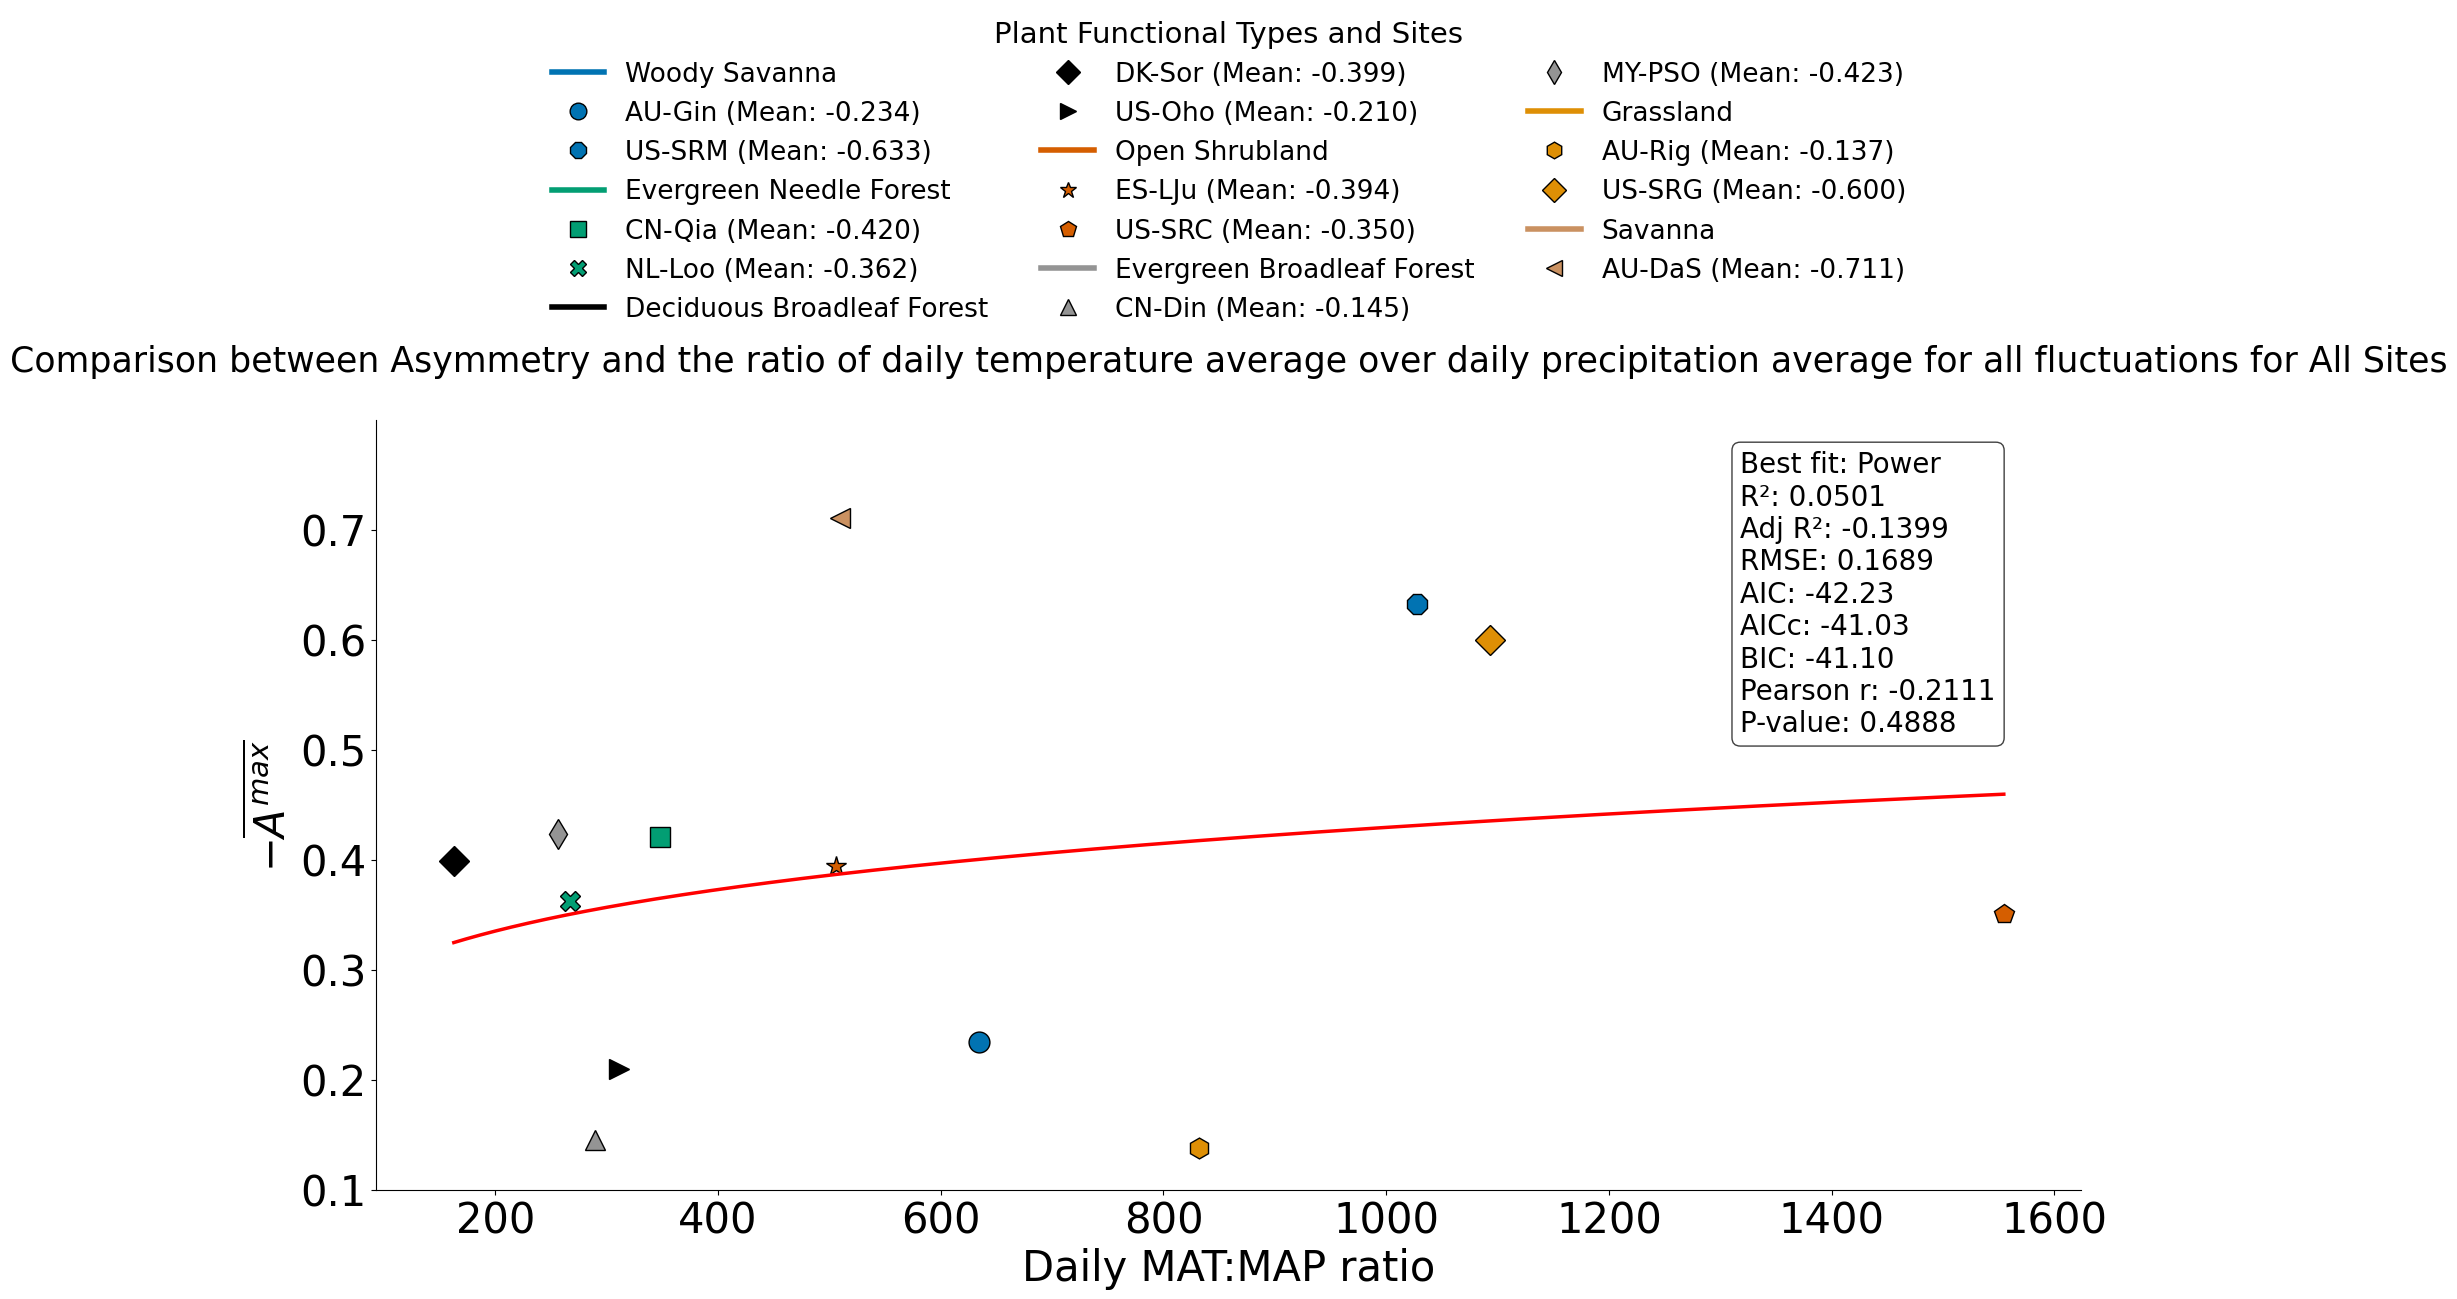

In [47]:
x_data = np.array([v["tp_mtch"] for v in tpmtch_data.values()], dtype=float)
y_data = np.array([v["meanactpmtch"] for v in tpmtch_data.values()], dtype=float)
corr, p_value = stats.pearsonr(x_data, y_data)

# Setting up models
def f_linear(x, a, b):        return a*x + b
def f_quadratic(x, a, b, c):  return a*x**2 + b*x + c
def f_power(x, a, b):         return a*np.power(x, b)
def f_expo(x, a, b, c):       return a*np.exp(b*x) + c
def f_log(x, a, b, c):        return a*np.log(b*x + 1) + c
def f_sigmoid(x, L, k, x0):   return L / (1 + np.exp(-k*(x - x0)))
def f_hill_gen(x, K_A, n):    return (x**n) / (K_A**n + x**n)  # general Hill only

def fit_models_tpmtch(x, y):
    results = []
    n_samples = len(y)
    MODEL_SET = {
        "Linear":      (f_linear,     [1.0, 0.0]),
        "Quadratic":   (f_quadratic,  [0.0, 1.0, 0.0]),
        "Power":       (f_power,      [1.0, 1.0]),
        "Exponential": (f_expo,       [1.0, 0.01, float(np.nanmin(y))]),
        "Logarithmic": (f_log,        [1.0, 0.01, float(np.nanmin(y))]),
        "Sigmoid":     (f_sigmoid,    [float(np.max(y) - np.min(y)), 0.1, float(np.median(x))]),
        "Hill":        (f_hill_gen,   [float(np.median(x)), 1.0]),  # general Hill (no temp scaling)
    }
    for name, (func, p0) in MODEL_SET.items():
        try:
            popt, _ = curve_fit(func, x, y, p0=p0, maxfev=20000)
            y_pred = func(x, *popt)
            r2   = float(r2_score(y, y_pred))
            rmse = float(np.sqrt(mean_squared_error(y, y_pred)))
            mse  = mean_squared_error(y, y_pred)
            k    = len(popt)
            aic  = n_samples * np.log(mse) + 2 * k
            aicc = aic + (2 * k * (k + 1)) / (n_samples - k - 1) if n_samples > k + 1 else aic
            bic  = n_samples * np.log(mse) + k * np.log(n_samples)
            adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - k - 1) if n_samples > k + 1 else r2
            results.append({
                "name": name, "func": func, "params": popt,
                "r2": r2, "adj_r2": adj_r2, "rmse": rmse,
                "aic": aic, "aicc": aicc, "bic": bic
            })
        except Exception:
            pass
    results.sort(key=lambda d: (d["bic"], d["aic"], -d["adj_r2"]))
    return results

# Getting best fit model
candidates = ["Linear","Quadratic","Power","Exponential","Logarithmic","Sigmoid","Hill"]
fits = fit_models_tpmtch(x_data, y_data)
best = fits[0] if len(fits) else None

# Plotting
fig, ax_main = plt.subplots(figsize=(22, 10))

for site, d in tpmtch_data.items():
    ax_main.plot(d["tp_mtch"], d["meanactpmtch"],
                 marker=d["marker"], color=d["color"],
                 markeredgecolor='black', markerfacecolor=d["color"],
                 label=site, markersize=15)

ax_main.set_xlabel('Daily MAT:MAP ratio', fontsize=30)
ax_main.set_ylabel('$-\\overline{A^{max}}$', fontsize=30)
ax_main.set_ylim(-0.1, -0.8)
ax_main.set_yticks(-np.arange(0.1, 0.71, 0.1))
ax_main.yaxis.set_major_formatter(mticker.FuncFormatter(lambda v, pos: f"{abs(v):.1f}"))
ax_main.tick_params(axis='both', which='major', labelsize=30)
ax_main.spines['right'].set_visible(False)
ax_main.spines['top'].set_visible(False)
ax_main.set_title(
    'Comparison between Asymmetry and the ratio of daily temperature average over daily precipitation average for all fluctuations for All Sites',
    fontsize=25, pad=35
)
if best is not None:
    x_min, x_max = float(np.nanmin(x_data)), float(np.nanmax(x_data))
    x_line = np.linspace(x_min, x_max, 1000)
    y_line = best["func"](x_line, *best["params"])
    ax_main.plot(x_line, y_line, color='red', linewidth=2.5, linestyle='-')

if best is not None:
    textstr = (f'Best fit: {best["name"]}\n'
               f'R²: {best["r2"]:.4f}\n'
               f'Adj R²: {best["adj_r2"]:.4f}\n'
               f'RMSE: {best["rmse"]:.4f}\n'
               f'AIC: {best["aic"]:.2f}\n'
               f'AICc: {best["aicc"]:.2f}\n'
               f'BIC: {best["bic"]:.2f}\n'
               f'Pearson r: {corr:.4f}\n'
               f'P-value: {p_value:.4f}')
else:
    textstr = f'Pearson r: {corr:.4f}\nP-value: {p_value:.4f}'

props = dict(boxstyle='round', facecolor='white', alpha=0.75)
ax_main.text(0.8, 0.96, textstr, transform=ax_main.transAxes,
             fontsize=20, va='top', bbox=props)

pft_groups = {}
for site_key, (pft, site_label) in site_labels.items():
    if site_label in tpmtch_data:
        pft_groups.setdefault(pft, []).append(site_label)

legend_elements = []
for pft, color in pft_colors.items():
    if pft in pft_groups:
        legend_elements.append(plt.Line2D([0], [0], color=color, lw=4, label=pft))
        for site in pft_groups[pft]:
            d = tpmtch_data[site]
            legend_elements.append(plt.Line2D([0], [0], marker=d['marker'], color='w',
                                              label=f"{site} (Mean: {d['meanactpmtch']:.3f})",
                                              markerfacecolor=color, markersize=12,
                                              markeredgecolor='black'))

legend = ax_main.legend(handles=legend_elements, loc='upper center',
                        bbox_to_anchor=(0.5, 1.55), fontsize=19,
                        title="Plant Functional Types and Sites", ncol=3, frameon=False)
legend.get_title().set_fontsize(21)

plt.show()
